https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Análise Exploratória de Dados
* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes) 
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por 0
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 20 e top 50)
    * Seleçaõ de atributos com teste ANOVA (top 20 e top 50)
    * Seleção de atributos com análise de correlação (top 20 e top 50)
* Balanceamento de classes
    * Undersample com Resample e RUS
    * Oversample com Resample e ROS
* Separação entre base de treino e de teste, a partir da base de treino
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Random Forest
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * Logistic Regression
        * KNN
        * Naive Bayes
    * Métricas de desempenho
        * Acurácia
        * F1-score
        * Recall
        * Precision
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from scipy import stats
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [3]:
start_time = time.time()

In [4]:
%%time

#limpando cache do CUDA
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

SystemError: initialization of _internal failed without raising an exception

In [5]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [6]:
#limpando cache do CUDA
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [7]:
t0 = time.time()

In [8]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [9]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

Olhando as estatísticas básicas através da função `resumetable`

In [10]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [11]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [12]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


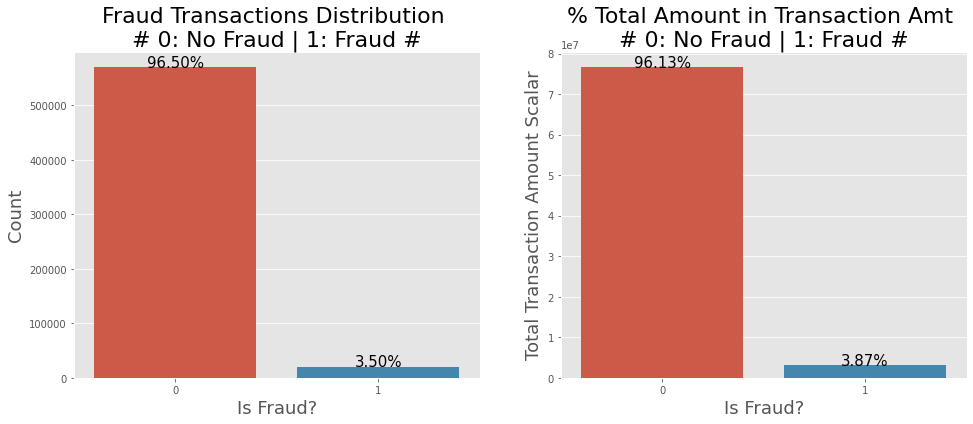

In [13]:
# checando o desbalanceamento dos dados através da contagem de linhas e TransactionAmt
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)
    
#plt.show()

In [14]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [15]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [16]:
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

V324: 86.05496664070174%
V325: 86.05496664070174%
V326: 86.05496664070174%
V327: 86.05496664070174%
V328: 86.05496664070174%
V329: 86.05496664070174%
V330: 86.05496664070174%
V331: 86.05496664070174%
V332: 86.05496664070174%
V333: 86.05496664070174%
V334: 86.05496664070174%
V335: 86.05496664070174%
V336: 86.05496664070174%
V337: 86.05496664070174%
V338: 86.05496664070174%
V339: 86.05496664070174%
id_01: 75.5760829071697%
id_02: 76.14522301622245%
id_03: 88.76892335828225%
id_04: 88.76892335828225%
id_05: 76.82375452975243%
id_06: 76.82375452975243%
id_07: 99.12707013919463%
id_08: 99.12707013919463%
id_09: 87.31229044603245%
id_10: 87.31229044603245%
id_11: 76.12727334304196%
id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 

In [17]:
for i in list(train):
    #str() converte número em string
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

## Gráficos

### Tabela Identidade

Utilizando a visão de gráficos para apoiar a parte de Feature Engineering

In [18]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values)#, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    #plt.show()

In [19]:
for col in ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 
            'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']:
    train[col] = train[col].fillna('NaN')
    #cat_feat_ploting(train, col)

Features com alguns padrões:

* `id_12`, `id_15`, `id_16`, `id_23`, `id_27`, `id_28`, `id_29`, `id_32`, `id_34`, `id_35`, `id_36`, `id_37`, `id_38`: `NaN` corresponde a mais de 75% dos valores

* `id_13`, `id_14`, `id_17`, `id_18`, `id_19`, `id_20`, `id_21`, `id_22`, `id_24`, `id_25`, `id_26`, `id_30`, `id_31`, `id_33`, `id_37`: pequena concentração dos valores em grupos

#### Operating System

Apesar das pequenas concentrações, é possível concentrar os valores de algumas colunas

In [20]:
train.loc[train['id_30'].str.contains('Windows', na = False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na = False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na = False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na = False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace = True)

In [21]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black')#, legend=False)
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black')#, legend=False)
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    #plt.show()

In [22]:
#ploting_cnt_amt(train, 'id_30')

Mesmo com a concentração, `id_30` demonstra muitos valores `NaN`. Faremos o mesmo para outras colunas da tabela Identidade

#### Browser column

In [23]:
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() 
                                                               < 200].index), 'id_31'] = "Others"

In [24]:
#ploting_cnt_amt(train, 'id_31')

#### Device Type

<AxesSubplot:title={'center':'Percentage of Fraud by Device Type'}, ylabel='DeviceType'>

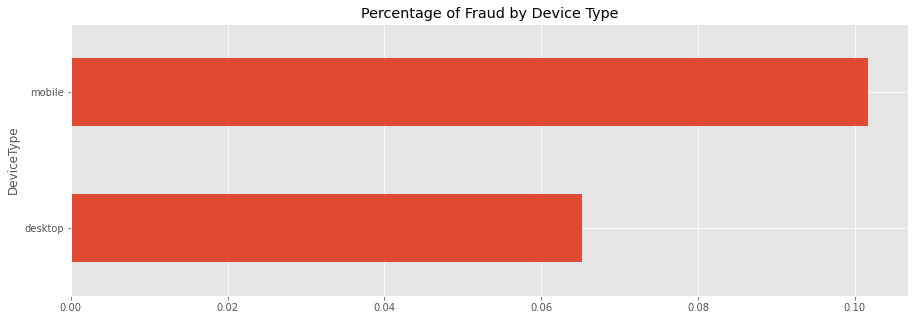

In [25]:
train.groupby('DeviceType') \
.mean()['isFraud'] \
.sort_values() \
.plot(kind = 'barh', 
     figsize = (15, 5), 
     title = 'Percentage of Fraud by Device Type')
#plt.show()

#### Device Info

<AxesSubplot:title={'center':'Top 20 Devices in Train'}, ylabel='DeviceInfo'>

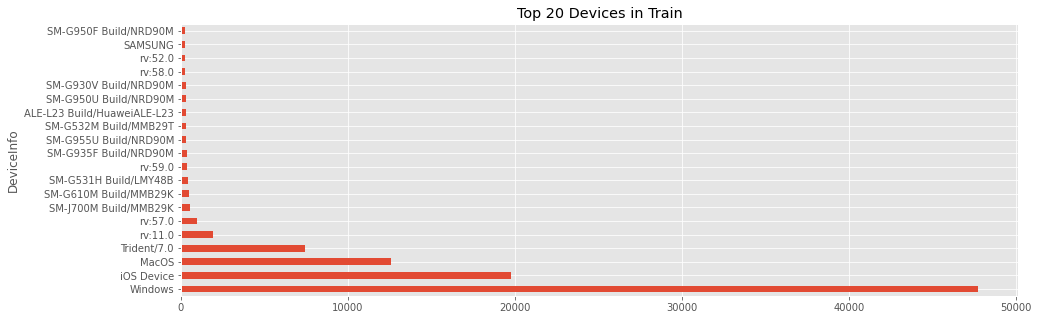

In [26]:
train.groupby('DeviceInfo') \
.count()['TransactionID'] \
.sort_values(ascending = False) \
.head(20) \
.plot(kind = 'barh', figsize = (15, 5), title = 'Top 20 Devices in Train')
#plt.show()

### Tabela Transação

#### Transaction Amount

In [27]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
print("Transaction Amount Quantiles: ")
print(train['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amount Quantiles: 
0.010       9.244000000000000
0.025      14.500999999999999
0.100      25.949999999999999
0.250      43.320999999999998
0.500      68.769000000000005
0.750     125.000000000000000
0.900     275.293000000000006
0.975     648.334500000004141
0.990    1104.000000000000000
Name: TransactionAmt, dtype: float64


In [28]:
# observando os percentis para transações fraudulentas e genuínas
print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']
                 .quantile([.01, .1, .25, .5, .75, .9, .99])
                 .reset_index(),
                 train[train['isFraud'] == 0]['TransactionAmt']
                 .quantile([.01, .1, .25, .5, .75, .9, .99])
                 .reset_index()], 
                axis = 1, keys = ['Fraud', 'NoFraud']))

  Fraud                      NoFraud                      
  index       TransactionAmt   index        TransactionAmt
0  0.01    6.740960000000000    0.01     9.512880000000003
1  0.10   18.936000000000000    0.10    26.309999999999999
2  0.25   35.043999999999997    0.25    43.969999999999999
3  0.50   75.000000000000000    0.50    68.500000000000000
4  0.75  161.000000000000000    0.75   120.000000000000000
5  0.90  335.000000000000000    0.90   267.112000000001842
6  0.99  994.000000000000000    0.99  1104.000000000000000


In [29]:
print('Mean transaction amt for fraud is {:.4f}'
      .format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'
      .format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


#### Product Feature

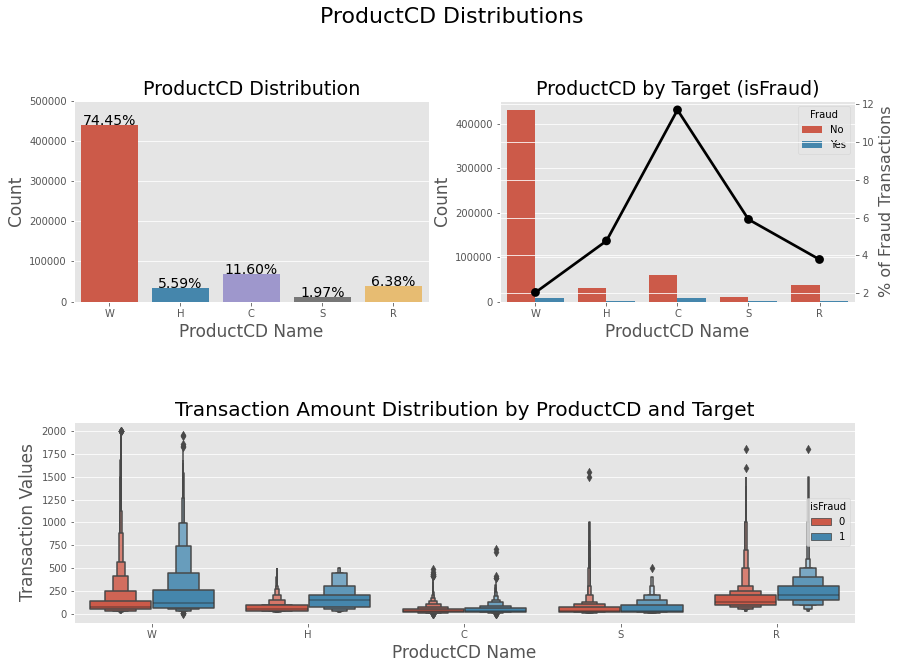

In [30]:
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0: 'No Fraud', 1: 'Fraud'}, inplace = True)

plt.figure(figsize = (14, 10))
plt.suptitle('ProductCD Distributions', fontsize = 22)

plt.subplot(221)
g = sns.countplot(x = 'ProductCD', data = train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize = 19)
g.set_xlabel("ProductCD Name", fontsize = 17)
g.set_ylabel("Count", fontsize = 17)
g.set_ylim(0, 500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3, 
          '{:1.2f}%'.format(height / total * 100),
          ha = "center", fontsize = 14)

plt.subplot(222)
g1 = sns.countplot(x = 'ProductCD', hue = 'isFraud', data = train)
plt.legend(title = 'Fraud', loc = 'best', labels = ['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x = 'ProductCD', y = 'Fraud', data = tmp, color = 'black', 
                  order = ['W', 'H', 'C', 'S', 'R'])#, legend = False)
gt.set_ylabel("% of Fraud Transactions", fontsize = 16)

g1.set_title("ProductCD by Target (isFraud)", fontsize = 19)
g1.set_xlabel("ProductCD Name", fontsize = 17)
g1.set_ylabel("Count", fontsize = 17)

plt.subplot(212)
g3 = sns.boxenplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud',
                  data = train[train['TransactionAmt'] <= 2000])
g3.set_title("Transaction Amount Distribution by ProductCD and Target", fontsize = 20)
g3.set_xlabel("ProductCD Name", fontsize = 17)
g3.set_ylabel("Transaction Values", fontsize = 17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

#plt.show()

<AxesSubplot:title={'center':'Percentage of Fraud by ProductCD'}, ylabel='ProductCD'>

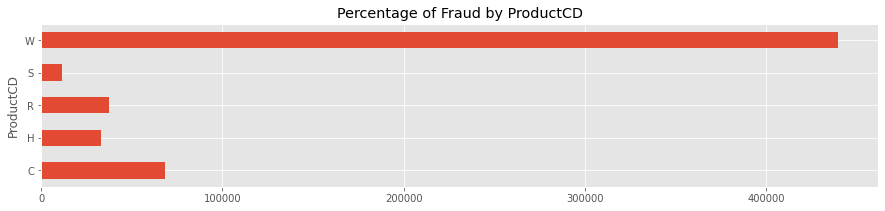

In [31]:
train.groupby('ProductCD') \
['TransactionID'].count() \
.sort_index() \
.plot(kind = 'barh', 
     figsize = (15, 3), 
     title = 'Percentage of Fraud by ProductCD')
#plt.show()

A maior parte das transações estão relacionadas com o produto `W`

#### Card Features

In [32]:
resumetable(train[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int64,0,13553,13926,2755,4663,9.970000000000001
1,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
2,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
3,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
4,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
5,card6,object,1571,4,credit,credit,debit,0.820000000000000


In [33]:
# percentis para as colunas de cartão
print("Card Features Quantiles: ")
print(train[['card1', 'card2', 'card3', 'card5']].quantile([.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


`Card 1` e `Card 2` com uma ampla distribuição de valores. Melhor tirar o log dessas colunas

In [34]:
train.loc[train.card3.isin(train.card3.value_counts()[train.card3.value_counts() < 200]
                                 .index), 'card3'] = "Others"
train.loc[train.card5.isin(train.card5.value_counts()[train.card5.value_counts() < 300]
                                .index), 'card5'] = "Others"

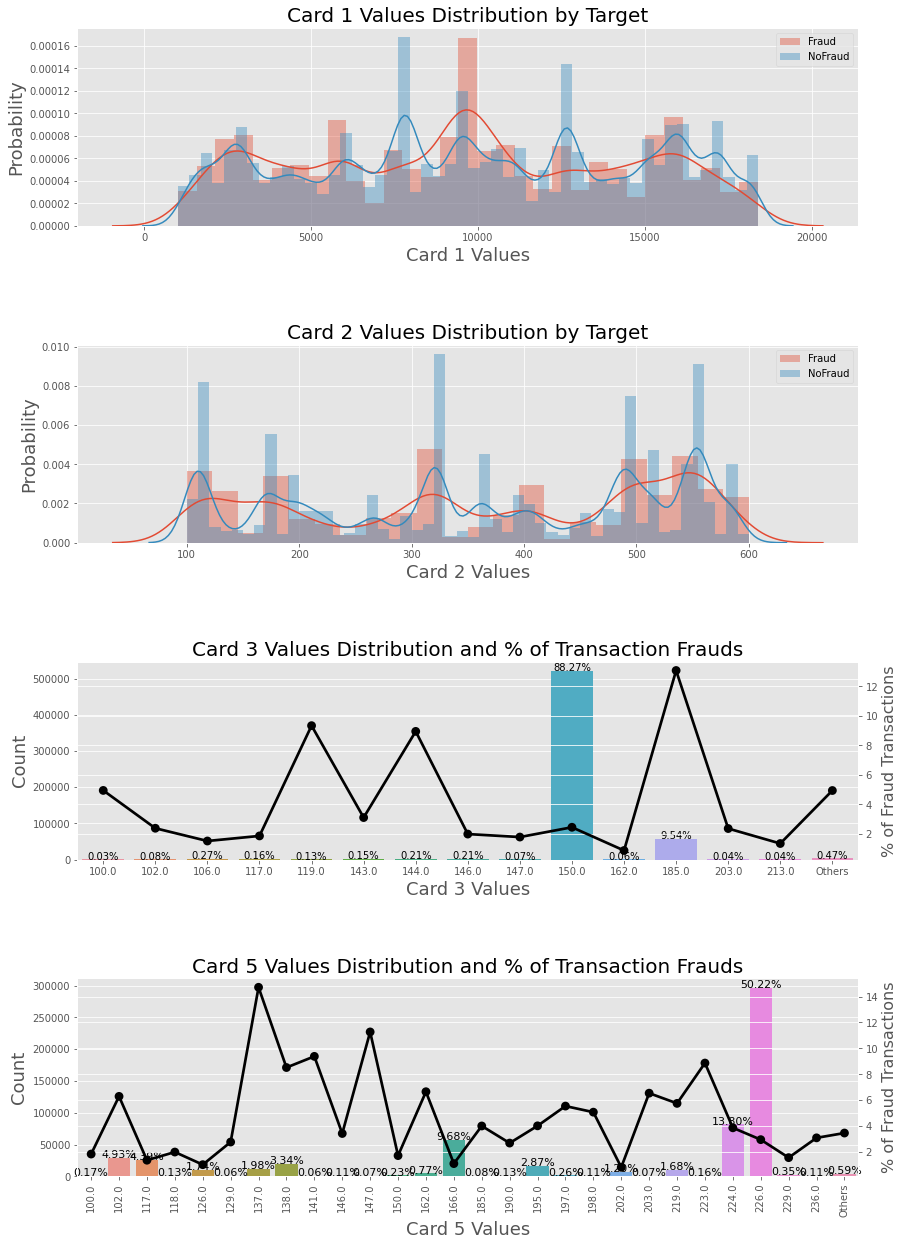

In [35]:
# visualizando as distribuições de Card 1, Card 2 e Card 3
tmp = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=train, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=train, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


#plt.show()

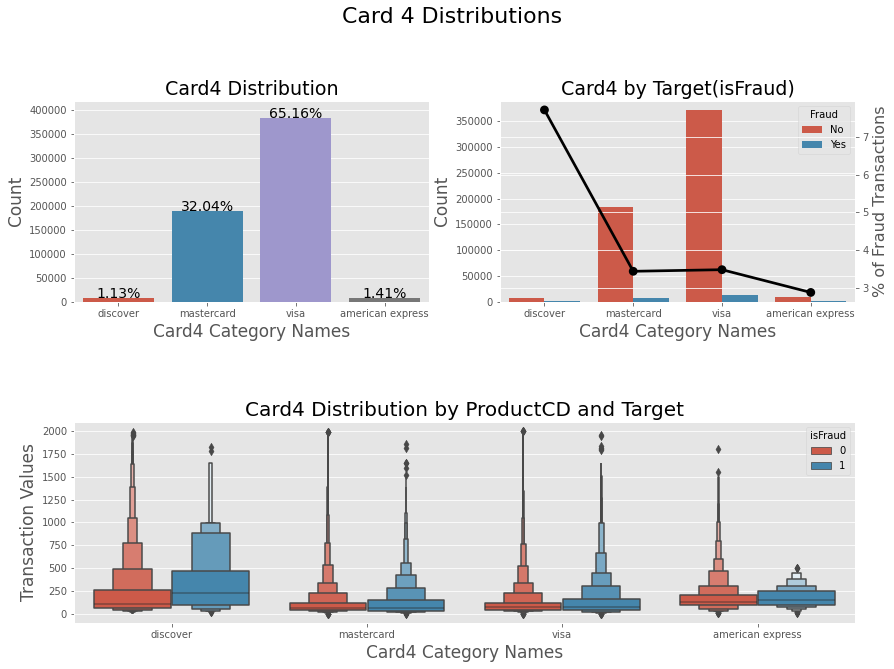

In [36]:
# Card 4
tmp = pd.crosstab(train['card4'], train['isFraud'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0: 'No Fraud', 1: 'Fraud'}, inplace = True)

plt.figure(figsize = (14, 10))
plt.suptitle('Card 4 Distributions', fontsize = 22)

plt.subplot(221)
g = sns.countplot(x = 'card4', data = train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize = 19)
g.set_ylim(0, 420000)
g.set_xlabel("Card4 Category Names", fontsize = 17)
g.set_ylabel("Count", fontsize = 17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 14)

plt.subplot(222)
g1 = sns.countplot(x = 'card4', hue = 'isFraud', data = train)
plt.legend(title = 'Fraud', loc = 'best', labels = ['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x = 'card4', y = 'Fraud', data = tmp,
                  color = 'black',
                  order = ['discover', 'mastercard', 'visa', 'american express'])#, legend = False)
gt.set_ylabel("% of Fraud Transactions", fontsize = 16)
g1.set_title("Card4 by Target(isFraud)", fontsize = 19)
g1.set_xlabel("Card4 Category Names", fontsize = 17)
g1.set_ylabel("Count", fontsize = 17)

plt.subplot(212)
g3 = sns.boxenplot(x = 'card4', y = 'TransactionAmt', hue = 'isFraud', 
                   data = train[train['TransactionAmt'] <= 2000])
g3.set_title("Card4 Distribution by ProductCD and Target", fontsize = 20)
g3.set_xlabel("Card4 Category Names", fontsize = 17)
g3.set_ylabel("Transaction Values", fontsize = 17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

#plt.show()

* 97% dos dados de `Card 4` são Mastercard(32%) e Visa(65%);

* As maiores taxas de fraude estão em Discover (~8%), contra ~3.5% de Mastercard + Visa e 2.87% in American Express

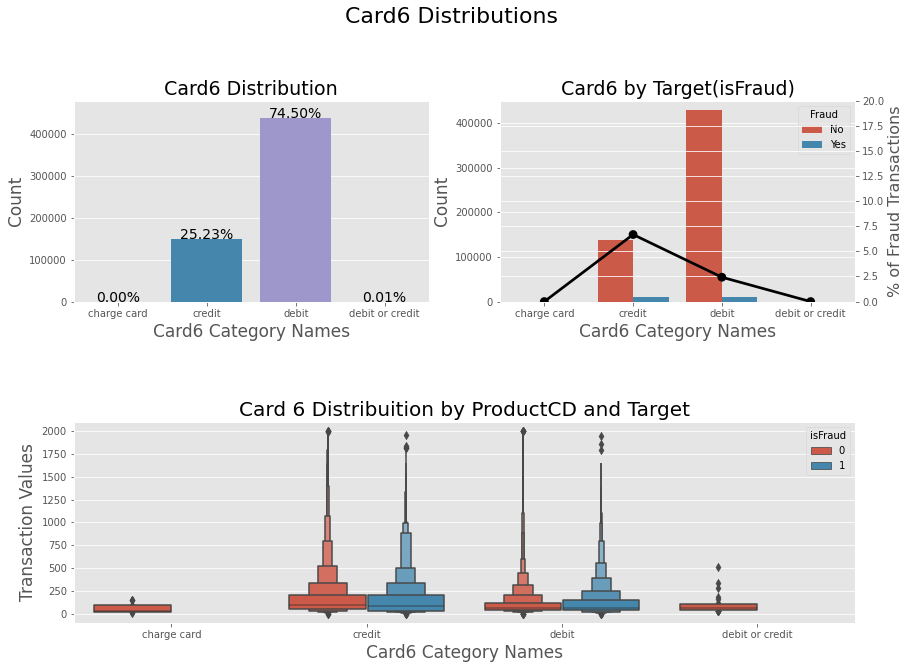

In [37]:
# Card 6
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0: 'NoFraud', 1: 'Fraud'}, inplace = True)

plt.figure(figsize = (14, 10))
plt.suptitle('Card6 Distributions', fontsize = 22)

plt.subplot(221)
g = sns.countplot(x = 'card6', data = train, order = list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize = 19)
g.set_ylim(0, 480000)
g.set_xlabel("Card6 Category Names", fontsize = 17)
g.set_ylabel("Count", fontsize = 17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black')#, legend=False)
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train[train['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

#plt.show()

* 89% dos dados são de cartão de crédito (25%) e débito (74%);

* Maiores taxas de fraudes em débito (~20%) contra 5% de crédito

#### M1-M9

In [38]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train[col] = train[col].fillna("Miss")
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black')#, legend=False)
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train.groupby(['isFraud',col])['TransactionAmt'].sum() / 
                total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black')#, legend=False)
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    #plt.show()

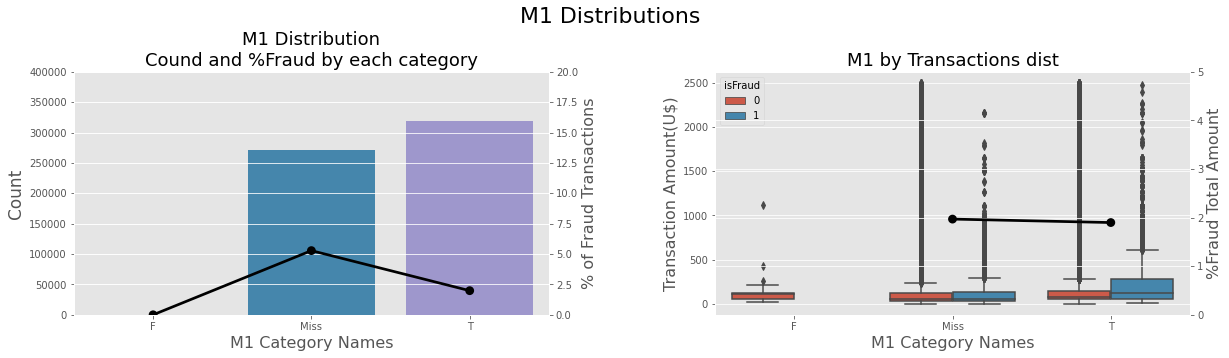

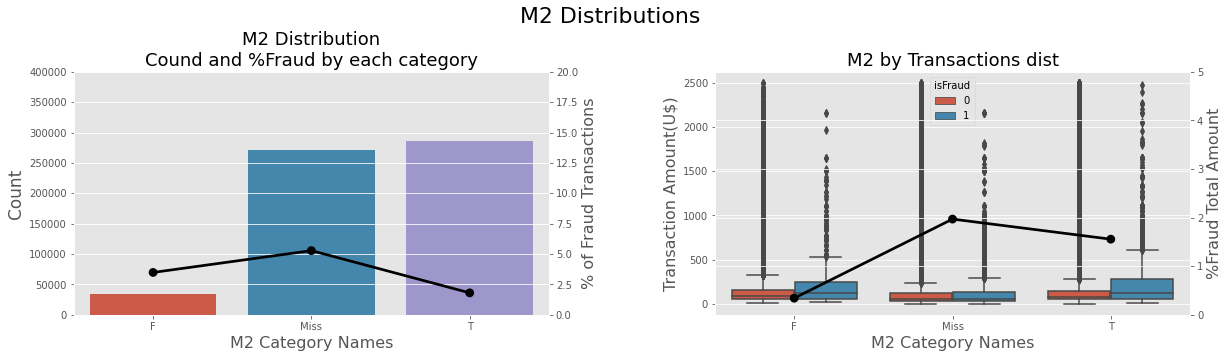

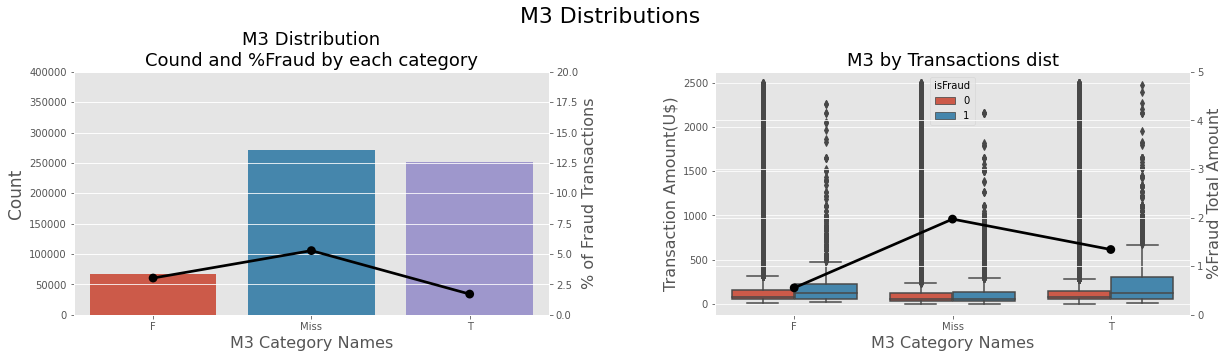

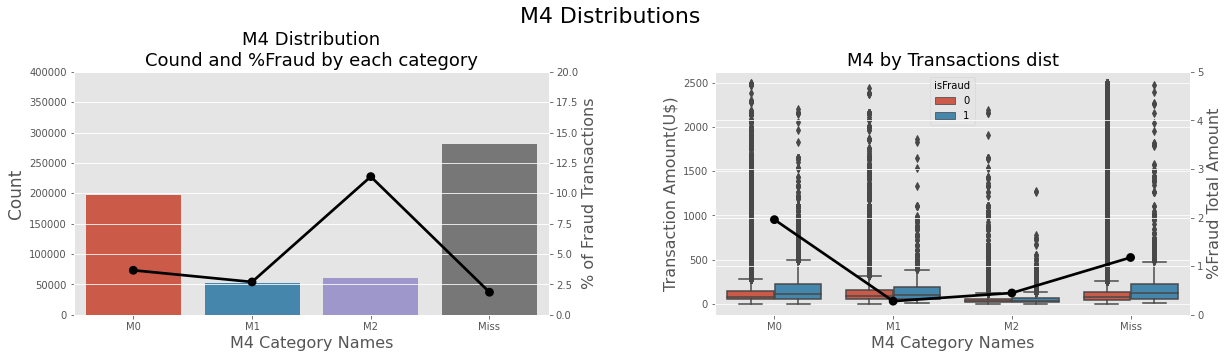

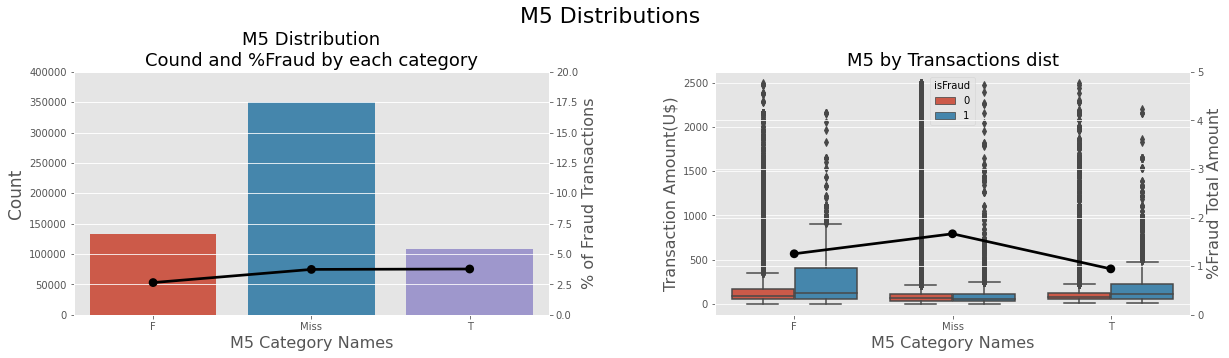

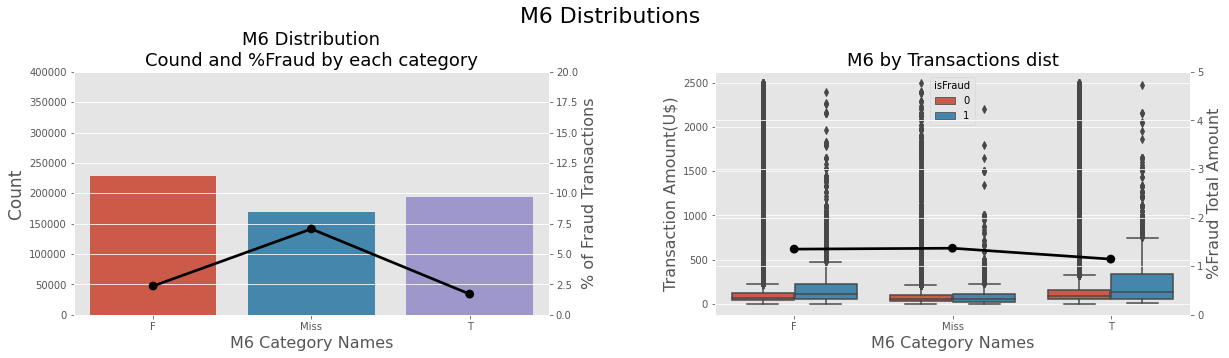

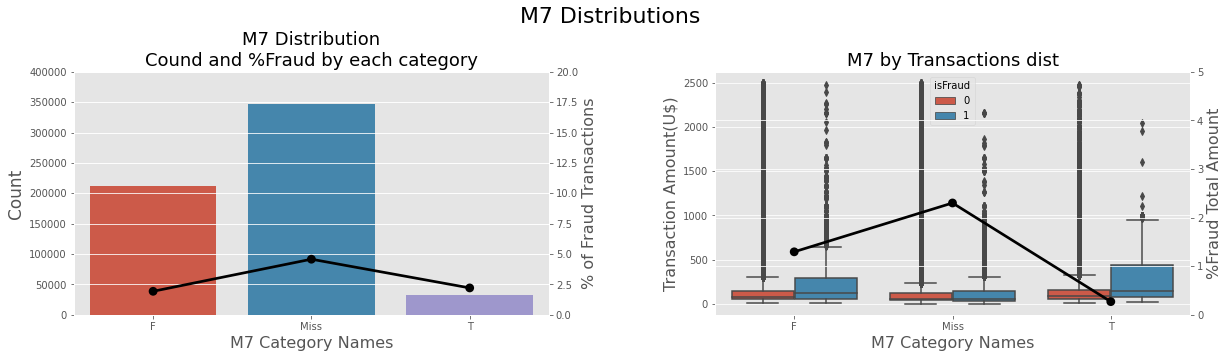

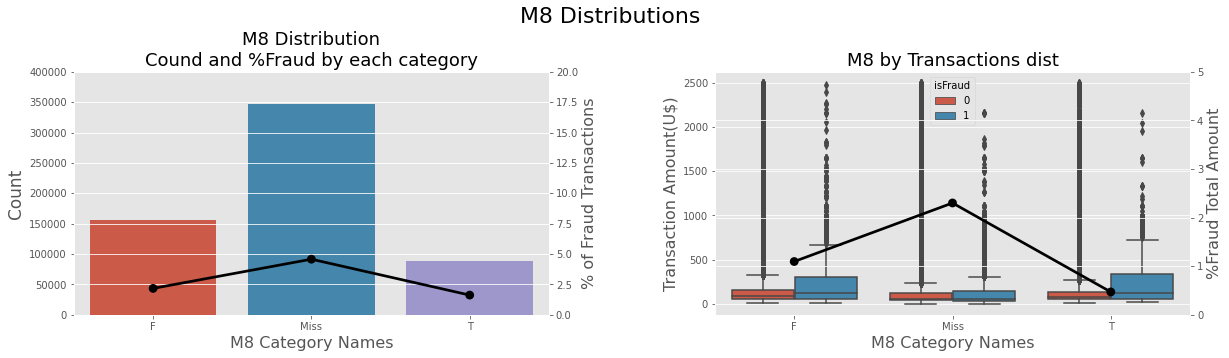

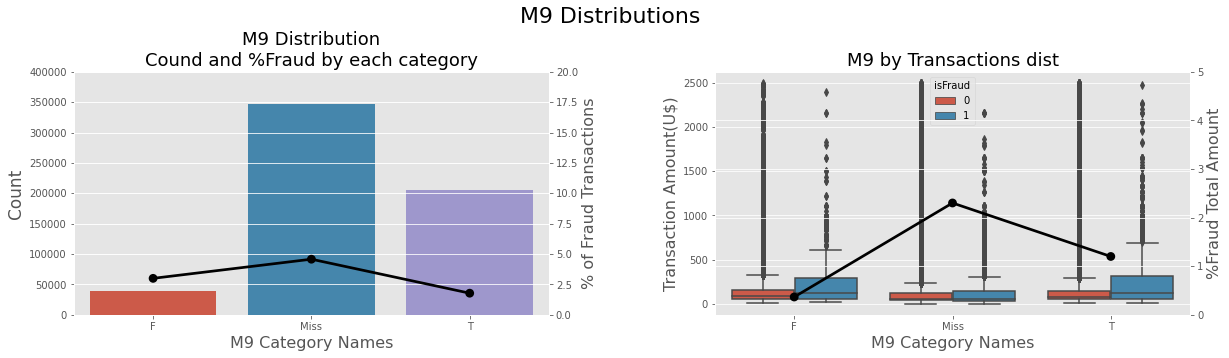

In [39]:
# distribuições M: distribuição de contagem, percentual de fraude e valor total de transação
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train, col, lim=2500)

Em todos os casos, mais da metade das transações tem valores faltantes.

#### Addr1 and Addr2

In [40]:
print("Card Features Quantiles")
print(train[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90, .975, .99]))

Card Features Quantiles
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [41]:
train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 
                                                               5000].index), 'addr1'] = "Others"
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 
                                                              50].index), 'addr2'] = "Others"

In [42]:
# distribuição de addr1
#ploting_cnt_amt(train, 'addr1')

Baixa concentração verificada na feature `addr1`

In [43]:
# Addr2 Distributions
#ploting_cnt_amt(train, 'addr2')

In [44]:
print(' addr1 - has {} NA values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


#### P Emaildomain

In [45]:
train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train.P_emaildomain.isin(train.P_emaildomain\
                                         .value_counts()[train.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train.P_emaildomain.fillna("NoInf", inplace=True)

In [46]:
# domínio dos emails
#ploting_cnt_amt(train, 'P_emaildomain')

#### R-Email Domain

In [47]:
train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train.R_emaildomain.isin(train.R_emaildomain\
                                         .value_counts()[train.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
train.R_emaildomain.fillna("NoInf", inplace=True)

In [48]:
#ploting_cnt_amt(train, 'R_emaildomain')

#### C1-C14

In [49]:
resumetable(train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                    'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float64,0,1657,1.0,1.0,1.0,2.72
1,C2,float64,0,1216,1.0,1.0,1.0,2.75
2,C3,float64,0,27,0.0,0.0,0.0,0.04
3,C4,float64,0,1260,0.0,0.0,0.0,1.12
4,C5,float64,0,319,0.0,0.0,0.0,2.06
5,C6,float64,0,1328,1.0,1.0,1.0,2.52
6,C7,float64,0,1103,0.0,0.0,0.0,0.71
7,C8,float64,0,1253,0.0,0.0,0.0,1.25
8,C9,float64,0,205,1.0,0.0,1.0,2.62
9,C10,float64,0,1231,0.0,0.0,0.0,1.23


In [50]:
train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000
mean,14.092457750533411,15.269734480306161,0.005643986859485,4.092185118704914,5.571526060893420,9.071082399160090,2.848477664510448,5.144574457276391,4.480240119212924,5.240342737155824,10.241521319470316,4.076226843228231,32.539917702441834,8.295214549395469
std,133.569017999404849,154.668899215115431,0.150535621816861,68.848458559012954,25.786975821564244,71.508467387029469,61.727303516294882,95.378573649118124,16.674896706250987,95.581442962408531,94.336291830343100,86.666217674160464,129.364844445589540,49.544262418729545
min,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
25%,1.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,1.000000000000000,1.000000000000000
50%,1.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,3.000000000000000,1.000000000000000
75%,3.000000000000000,3.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000,2.000000000000000,0.000000000000000,0.000000000000000,2.000000000000000,0.000000000000000,2.000000000000000,0.000000000000000,12.000000000000000,2.000000000000000
max,4685.000000000000000,5691.000000000000000,26.000000000000000,2253.000000000000000,349.000000000000000,2253.000000000000000,2255.000000000000000,3331.000000000000000,210.000000000000000,3257.000000000000000,3188.000000000000000,3188.000000000000000,2918.000000000000000,1429.000000000000000


In [51]:
train.loc[train.C1.isin(train.C1\
                              .value_counts()[train.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

In [52]:
# C1 Distribution Plot
#ploting_cnt_amt(train, 'C1')

In [53]:
train.loc[train.C2.isin(train.C2.value_counts()[train.C2.value_counts() <= 350]
                             .index), 'C2'] = 'Others'

In [54]:
# C2 Distribution Plot
#ploting_cnt_amt(train, 'C2')

In [55]:
# C3 Distribution Plot
#ploting_cnt_amt(train, 'C3')

In [56]:
train.loc[train.C4.isin(train.C4.value_counts()[train.C4.value_counts() <= 350]
                             .index), 'C4'] = 'Others'

In [57]:
# C4 Distribution Plot
#ploting_cnt_amt(train, 'C4')

In [58]:
train.loc[train.C5.isin(train.C5.value_counts()[train.C5.value_counts() <= 350]
                             .index), 'C5'] = 'Others'

In [59]:
# C5 Distribution Plot
#ploting_cnt_amt(train, 'C5')

In [60]:
train.loc[train.C6.isin(train.C6.value_counts()[train.C6.value_counts() <= 500]
                             .index), 'C6'] = 'Others'

In [61]:
# C6 Distribution Plot
#ploting_cnt_amt(train, 'C6')

In [62]:
train.loc[train.C7.isin(train.C7.value_counts()[train.C7.value_counts() <= 500]
                             .index), 'C7'] = 'Others'

In [63]:
# C7 Distribution Plot
#ploting_cnt_amt(train, 'C7')

In [64]:
train.loc[train.C8.isin(train.C8.value_counts()[train.C8.value_counts() <= 500]
                             .index), 'C8'] = 'Others'

In [65]:
# C8 Distribution Plot
#ploting_cnt_amt(train, 'C8')

In [66]:
train.loc[train.C9.isin(train.C9.value_counts()[train.C9.value_counts() <= 500]
                             .index), 'C9'] = 'Others'
# C9 Distribution Plot
#ploting_cnt_amt(train, 'C9')

In [67]:
train.loc[train.C10.isin(train.C10.value_counts()[train.C10.value_counts() <= 500]
                             .index), 'C10'] = 'Others'
# C10 Distribution Plot
#ploting_cnt_amt(train, 'C10')

In [68]:
train.loc[train.C11.isin(train.C11.value_counts()[train.C11.value_counts() <= 500]
                             .index), 'C11'] = 'Others'
# C11 Distribution Plot
#ploting_cnt_amt(train, 'C11')

In [69]:
train.loc[train.C12.isin(train.C12.value_counts()[train.C12.value_counts() <= 500]
                             .index), 'C12'] = 'Others'
# C12 Distribution Plot
#ploting_cnt_amt(train, 'C12')

In [70]:
train.loc[train.C13.isin(train.C13.value_counts()[train.C13.value_counts() <= 10000]
                             .index), 'C13'] = 'Others'
# C13 Distribution Plot
#ploting_cnt_amt(train, 'C13')

In [71]:
train.loc[train.C14.isin(train.C14.value_counts()[train.C14.value_counts() <= 500]
                             .index), 'C14'] = 'Others'
# C14 Distribution Plot
#ploting_cnt_amt(train, 'C14')

#### Dist1 and Dist2

In [72]:
resumetable(train[['dist1', 'dist2']])

Dataset Shape: (590540, 2)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,dist1,float64,352271,2651,19.0,NaN,287.0,6.34
1,dist2,float64,552913,1751,NaN,NaN,NaN,7.42


In [73]:
train[['dist1', 'dist2']].describe()

,dist1,dist2
count,238269.000000000000000,37627.000000000000000
mean,118.502180308810637,231.855422967549885
std,371.872026491167389,529.053493552950727
min,0.000000000000000,0.000000000000000
25%,3.000000000000000,7.000000000000000
50%,8.000000000000000,37.000000000000000
75%,24.000000000000000,206.000000000000000
max,10286.000000000000000,11623.000000000000000


In [74]:
train.loc[train.dist1.isin(train.dist1.value_counts()[train.dist1.value_counts() <= 500]
                             .index), 'dist1'] = 'Others'
# dist1 Distribution Plot
#ploting_cnt_amt(train, 'dist1')

In [75]:
train.loc[train.dist2.isin(train.dist2.value_counts()[train.dist2.value_counts() <= 500]
                             .index), 'dist2'] = 'Others'
# dist2 Distribution Plot
#ploting_cnt_amt(train, 'dist2')

#### D1-D15

In [76]:
resumetable(train[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']])

Dataset Shape: (590540, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,D1,float64,1269,641,14.0,0.0,0.0,5.57
1,D2,float64,280797,641,NaN,NaN,NaN,8.57
2,D3,float64,262878,649,13.0,NaN,NaN,5.60
3,D4,float64,168922,808,NaN,0.0,0.0,6.42
4,D5,float64,309841,688,NaN,NaN,NaN,5.95
5,D6,float64,517353,829,NaN,NaN,NaN,4.09
6,D7,float64,551623,597,NaN,NaN,NaN,4.29
7,D8,float64,515614,12353,NaN,NaN,NaN,11.32
8,D9,float64,515614,24,NaN,NaN,NaN,4.29
9,D10,float64,76022,818,13.0,0.0,0.0,6.09


In [77]:
train[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,589271.000000000000000,309743.000000000000000,327662.000000000000000,421618.000000000000000,280699.000000000000000,73187.000000000000000,38917.000000000000000,74926.000000000000000,74926.000000000000000,514518.000000000000000,311253.000000000000000,64717.000000000000000,61952.000000000000000,62187.000000000000000,501427.000000000000000
mean,94.347568436254292,169.563231453172477,28.343347718075332,140.002440597887187,42.335964859155183,69.805716862284285,41.638949559318547,146.058107646878710,0.561057126596166,123.982136679377589,146.621465495914890,54.037532642118762,17.901294550619834,57.724444015630276,163.744578971614999
std,157.660386520898697,177.315864942072068,62.384721370068242,191.096773526366064,89.000144339782452,143.669252942601588,99.743263540217356,231.663839969046478,0.316879565697502,182.615224535141010,186.042622014270705,124.274558380139581,67.614425024841864,136.312450288663740,202.726659900955582
min,0.000000000000000,0.000000000000000,0.000000000000000,-122.000000000000000,0.000000000000000,-83.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,-53.000000000000000,-83.000000000000000,0.000000000000000,-193.000000000000000,-83.000000000000000
25%,0.000000000000000,26.000000000000000,1.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.958333015441894,0.208333000540733,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
50%,3.000000000000000,97.000000000000000,8.000000000000000,26.000000000000000,10.000000000000000,0.000000000000000,0.000000000000000,37.875000000000000,0.666665971279144,15.000000000000000,43.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,52.000000000000000
75%,122.000000000000000,276.000000000000000,27.000000000000000,253.000000000000000,32.000000000000000,40.000000000000000,17.000000000000000,187.958328247070312,0.833333015441895,197.000000000000000,274.000000000000000,13.000000000000000,0.000000000000000,2.000000000000000,314.000000000000000
max,640.000000000000000,640.000000000000000,819.000000000000000,869.000000000000000,819.000000000000000,873.000000000000000,843.000000000000000,1707.791625976562500,0.958333015441894,876.000000000000000,670.000000000000000,648.000000000000000,847.000000000000000,878.000000000000000,879.000000000000000


In [78]:
train.loc[train.D1.isin(train.D1.value_counts()[train.D1.value_counts() <= 500]
                             .index), 'D1'] = 'Others'
# D1 Distribution Plot
#ploting_cnt_amt(train, 'D1')

In [79]:
train.loc[train.D2.isin(train.D2.value_counts()[train.D2.value_counts() <= 500]
                             .index), 'D2'] = 'Others'
# D2 Distribution Plot
#ploting_cnt_amt(train, 'D2')

In [80]:
train.loc[train.D3.isin(train.D3.value_counts()[train.D3.value_counts() <= 500]
                             .index), 'D3'] = 'Others'
# D3 Distribution Plot
#ploting_cnt_amt(train, 'D3')

In [81]:
train.loc[train.D4.isin(train.D4.value_counts()[train.D4.value_counts() <= 1000]
                             .index), 'D4'] = 'Others'
# D4 Distribution Plot
#ploting_cnt_amt(train, 'D4')

In [82]:
train.loc[train.D5.isin(train.D5.value_counts()[train.D5.value_counts() <= 1000]
                             .index), 'D5'] = 'Others'
# D5 Distribution Plot
#ploting_cnt_amt(train, 'D5')

In [83]:
train.loc[train.D6.isin(train.D6.value_counts()[train.D6.value_counts() <= 500]
                             .index), 'D6'] = 'Others'
# D6 Distribution Plot
#ploting_cnt_amt(train, 'D6')

In [84]:
train.loc[train.D7.isin(train.D7.value_counts()[train.D7.value_counts() <= 500]
                             .index), 'D7'] = 'Others'
# D7 Distribution Plot
#ploting_cnt_amt(train, 'D7')

In [85]:
train.loc[train.D8.isin(train.D8.value_counts()[train.D8.value_counts() <= 500]
                             .index), 'D8'] = 'Others'
# D8 Distribution Plot
#ploting_cnt_amt(train, 'D8')

In [86]:
train.loc[train.D9.isin(train.D9.value_counts()[train.D9.value_counts() <= 500]
                             .index), 'D9'] = 'Others'
# D9 Distribution Plot
#ploting_cnt_amt(train, 'D9')

In [87]:
train.loc[train.D10.isin(train.D10.value_counts()[train.D10.value_counts() <= 1000]
                             .index), 'D10'] = 'Others'
# D10 Distribution Plot
#ploting_cnt_amt(train, 'D10')

In [88]:
train.loc[train.D11.isin(train.D11.value_counts()[train.D11.value_counts() <= 1000]
                             .index), 'D11'] = 'Others'
# D11 Distribution Plot
#ploting_cnt_amt(train, 'D11')

In [89]:
train.loc[train.D12.isin(train.D12.value_counts()[train.D12.value_counts() <= 500]
                             .index), 'D12'] = 'Others'
# D12 Distribution Plot
#ploting_cnt_amt(train, 'D12')

In [90]:
train.loc[train.D13.isin(train.D13.value_counts()[train.D13.value_counts() <= 500]
                             .index), 'D13'] = 'Others'
# D13 Distribution Plot
#ploting_cnt_amt(train, 'D13')

In [91]:
train.loc[train.D14.isin(train.D14.value_counts()[train.D14.value_counts() <= 500]
                             .index), 'D14'] = 'Others'
# D14 Distribution Plot
#ploting_cnt_amt(train, 'D14')

In [92]:
train.loc[train.D15.isin(train.D15.value_counts()[train.D15.value_counts() <= 1000]
                             .index), 'D15'] = 'Others'
# D15 Distribution Plot
#ploting_cnt_amt(train, 'D15')

#### V1 - V339

In [93]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,311253.000000000000000,...,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000,82351.000000000000000
mean,0.999945382052542,1.045204383572206,1.078074749480326,0.846456098415116,0.876990743864316,1.045686306638008,1.072869980369667,1.027704150642725,1.041528916990358,0.463915207242982,...,0.775874002744350,721.741882916404506,1375.783644036513351,1014.622781509143010,9.807015093927214,59.164549671486512,28.530902964203371,55.352421950538890,151.160542070513145,100.700881592801892
std,0.007390205667367,0.240132888213394,0.320889824940622,0.440053286680472,0.475902496321142,0.239384928778582,0.304778806855747,0.186069364493091,0.226338728710295,0.521522084010931,...,4.727971393408287,6217.223583406429498,11169.275702404978801,7955.735481948921006,243.861390570583268,387.629479999626142,274.576919719621969,668.486832619135953,1095.034386884882679,814.946721848684888
min,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
25%,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
50%,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
75%,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,...,0.000000000000000,0.000000000000000,25.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
max,1.000000000000000,8.000000000000000,9.000000000000000,6.000000000000000,6.000000000000000,9.000000000000000,9.000000000000000,8.000000000000000,8.000000000000000,4.000000000000000,...,55.000000000000000,160000.000000000000000,160000.000000000000000,160000.000000000000000,55125.000000000000000,55125.000000000000000,55125.000000000000000,104060.000000000000000,104060.000000000000000,104060.000000000000000


In [95]:
train['v_mean'] = train[v_cols].mean(axis = 1)

In [96]:
# fazendo o mesmo para a base de teste
test['v_mean'] = test[v_cols].mean(axis = 1)

#### Time Delta Feature

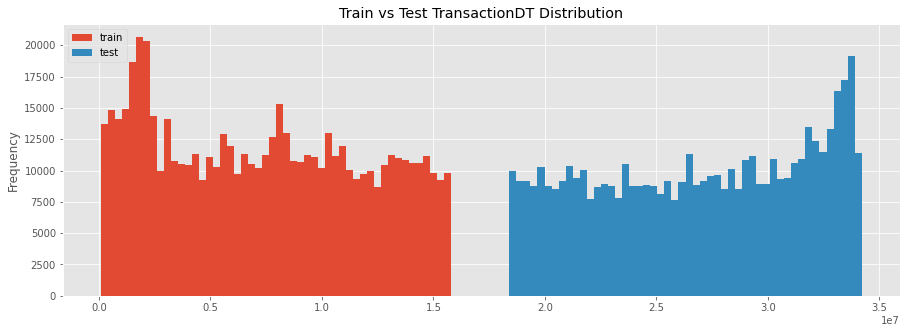

In [97]:
train['TransactionDT'].plot(kind = 'hist', 
                            figsize = (15, 5), 
                            label = 'train', 
                            bins = 50, 
                            title = 'Train vs Test TransactionDT Distribution')

test['TransactionDT'].plot(kind = 'hist', 
                           label = 'test', 
                           bins = 50)
plt.legend()
#plt.show()

Checando se as fraudes apresentam horários específicos de maior taxa

In [98]:
# Converting to Total Days, Weekdays and Hours
# We will use the first date as 2017-12-01 and use the delta time to compute datetime features

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [99]:
# Top Days With Highest Total Transaction Amount¶
#ploting_cnt_amt(train, '_Days')

In [100]:
# Ploting WeekDays Distributions
#ploting_cnt_amt(train, '_Weekdays')

In [101]:
# Ploting Hours Distributions
#ploting_cnt_amt(train, '_Hours')

In [102]:
# Top Days With Highest Total Transaction Amount¶
#pd.options.display.max_rows = 999
#pd.set_option('display.max_rows', None)
#train['Date']

In [103]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [104]:
#pd.set_option('display.max_rows', None)
#test['Date']

In [105]:
pd.reset_option('display.max_rows')

# Feature Engineering

## Equalizando nomes de colunas entre bases de treino e teste

In [106]:
# checando as diferenças entre nomes de colunas da base treino e teste
# para equalizar mudanças
pd.set_option('display.max_rows', 500)
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [107]:
# renomear colunas de teste e de treino
test.columns = test.columns.str.replace('-', '_')
#test.rename(columns = {'id-07':'id_07', 'id-08': 'id_08', 'id-21': 'id_21', 'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24', 'id-25': 'id_25', 
#                       'id-26':'id_26', 'id-27': 'id_27', 'id-18': 'id_18'}, inplace = True)

In [108]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [109]:
# colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]

# colunas com mais de 90% de valores únicos
big_top_value_cols_train = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]

# colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]

many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [110]:
# concatenar todas as colunas desnecessárias
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [111]:
train = train.drop(cols_to_drop, axis=1)

In [112]:
test = test.drop(cols_to_drop, axis=1)

In [113]:
# checando diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Linhas com Valores Faltantes 

In [114]:
# Delete rows containing either 75% or more than 75% NaN Values
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

In [115]:
# Delete rows containing either 75% or more than 75% NaN Values
perc = 75.0 
min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [116]:
train.shape

(590540, 93)

In [117]:
test.shape

(506691, 92)

## Substituindo NaNs remanescentes por 0 para pacotes de balanceamento e redução de dimensionalidade

In [118]:
# replace NaN by 0 to run PCA and t-SNE
train.replace(np.nan, 0, inplace=True)

## Encoding de variáveis categóricas (para pacotes de redução de dimensionalidade)

### Encoding categorical features

#### Using LabelEncoder

In [119]:
# finding out the featues identified as "object" to encode them
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'card5', 'addr1', 'dist1', 'P_emaildomain', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9'],
      dtype='object')


In [120]:
object_columns_treated = ['ProductCD', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_28', 'id_29',
       'id_31', 'D2', 'D3', 'D15', 'C5', 'D4', 'D5', 'D1', 'C9', 'C11', 'D10', 'D11', 'C14', 'C6', 'dist1', 'C13']

In [121]:
from sklearn import preprocessing
le = LabelEncoder()

In [122]:
for col in object_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [123]:
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 93)


,Name,dtypes


In [124]:
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 92)


,Name,dtypes


In [125]:
# You could use df._get_numeric_data() to get numeric columns and then find out categorical columns
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['Date']

In [126]:
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['Date']

In [127]:
# checking for columns difference between train and test
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Separando a variável target da base de treino

In [128]:
# fazer cópia dos datasets antes de retirar as colunas para balanceamento e redução de dimensionalidade
train_0 = train.copy()
test_0 = test.copy()

# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [129]:
# checking for columns difference between train and test
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

In [130]:
X_train = train.drop('isFraud',axis = 1)
y_train = train['isFraud'].astype('uint8')

In [131]:
y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

# Redução de Dimensionalidade

## Filtragem

Advantages of Filter methods
* Filter methods are model agnostic
* Rely entirely on features in the data set
* Computationally very fast
* Based on different statistical methods

The disadvantage of Filter methods
* The filter method looks at individual features for identifying it’s relative importance. A feature may not be useful on its own but maybe an important influencer when combined with other features. Filter methods may miss such features.

#### Removing quasi-constant features

Quasi-constant features, as the name suggests, are the features that are almost constant. Such features are not very useful for making predictions. There is no rule as to what should be the threshold for the variance of quasi-constant features.

However, as a rule of thumb, remove those quasi-constant features that have more than 99% similar values for the output observations.

Thus, instead of passing 0 as the value for the threshold parameter, we will pass 0.01, which means that if the variance of the values in a column is less than 0.01, remove that column. In other words, remove the feature column where approximately 99% of the values are similar.

In [132]:
qcons_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_qcons = qcons_filter.fit_transform(X_train)
print(data_qcons.shape)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in X_train.columns
                    if column not in X_train.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns))

#Quasi Constant columns names:
for column in qcons_columns:
    print(column)

(590540, 89)
0


## Seleção de Features com Teste do Qui-Quadrado

This is a form of non-parametric test (a test wherein median is an important parameter) in which feature selection is done with the help of hypothesis testing and p-value. The feature selection is only suited to categorical features or features having discrete data contained within it. The continuous features are not taken into account and therefore should not be used while performing this test. The formula for this type of test is given as:

Summation (Observed Value – Expected Value) / Expected Value

If the p-value is less than 0.05 then we reject the null hypothesis and go with the alternate hypothesis in this type of test.

In [133]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [134]:
# 20 features
model_20_chi2 = SelectKBest(chi2, k = 20)
new_20_chi2 = model_20_chi2.fit(X_train, y_train)
X_20_chi2 = new_20_chi2.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_20_chi2.get_support(indices = True)
features_df_new_20_chi2 = X_train.iloc[:, cols]
#features_df_new_20_chi2

In [135]:
# 50 features
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train, y_train)
X_50_chi2 = new_50_chi2.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train.iloc[:, cols]
#features_df_new_50_chi2

## Seleção de Features com Teste ANOVA

A feature selection technique is most suited to filter features wherein categorical and continuous data is involved. It is a type of parametric test which means it assumes a normal distribution of data forming a bell shape curve. There are many types of Anova test out there and a user can try out these as per their need. The assumption here is made as per the hypothesis testing where the null hypothesis states that there is no difference in the means and alternate says that there is a difference. If the p-value is less than 0.05 then the null hypothesis is rejected and the features are selected or else dropped if the null hypothesis becomes true. The implementation of this feature selection technique is given below with the help of Scikit Learn library

In [136]:
from sklearn.feature_selection import f_classif

In [137]:
# 20 features
model_20_anova = SelectKBest(score_func = f_classif, k = 20)
new_20_anova = model_20_anova.fit(X_train, y_train)
X_20_anova = new_20_anova.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_20_anova.get_support(indices = True)
features_df_new_20_anova = X_train.iloc[:, cols]
#features_df_new_20_anova

In [138]:
# 50 features
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train, y_train)
X_50_anova = new_50_anova.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train.iloc[:, cols]
#features_df_new_50_anova

## Seleção de Features com Análise de Correlação

In [139]:
train = pd.concat([X_train, y_train], axis = 1)

In [140]:
import time

In [141]:
pd.set_option('display.max_rows', 500)

In [142]:
%%time
topcorr = train.corr(method = 'spearman')['isFraud'].sort_values()[:-1]
topcorr_tail_20 = topcorr.tail(20)
#topcorr_tail_20

CPU times: user 23.9 s, sys: 59.8 ms, total: 24 s
Wall time: 24 s


In [143]:
topcorr_tail_50 = topcorr.tail(50)
#topcorr_tail_50

# Balanceamento de Classes

## Usando sklearn-resample

### Informações Gerais

https://www.kaggle.com/code/arthursilveirasc/resampling-strategies-for-imbalanced-datasets/edit

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

### Undersample da classe majoritária com Resample

In [144]:
from sklearn.utils import resample

In [145]:
not_fraud = train[train.isFraud == 0]
fraud = train[train.isFraud == 1]


not_fraud_undersampled = resample(not_fraud,
                                  replace = False, # sample without replacement
                                  n_samples = len(fraud), # match minority n
                                  random_state = 27)

# combine minority and undersampled majority
undersample_with_resample = pd.concat([not_fraud_undersampled, fraud])

# checking counts
undersample_with_resample.isFraud.value_counts()


X_undersample_with_resample = undersample_with_resample.drop('isFraud',axis = 1)
y_undersample_with_resample = undersample_with_resample['isFraud'].astype('uint8')

# utilizando seleção de features
cols_20_chi2 = features_df_new_20_chi2.columns
cols_50_chi2 = features_df_new_50_chi2.columns
cols_20_anova = features_df_new_20_anova.columns
cols_50_anova = features_df_new_50_anova.columns
cols_topcorr_20 = topcorr_tail_20.index
cols_topcorr_50 = topcorr_tail_50.index

### Oversample da classe minoritária com Resample

In [146]:
# oversample
fraud_upsampled = resample(fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(not_fraud), # match number in majority class
                           random_state = 27)

# combine majority and upsampled minority
oversample_with_resample = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
oversample_with_resample.isFraud.value_counts()

X_oversample_with_resample = oversample_with_resample.drop('isFraud',axis = 1)
y_oversample_with_resample = oversample_with_resample['isFraud'].astype('uint8')

## Usando o módulo imbalanced-learn

### Random under-sampling com imbalanced-learn

In [147]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [148]:
rus = RandomUnderSampler(random_state=0)

In [149]:
X_undersample_with_rus, y_undersample_with_rus = rus.fit_resample(X_train, y_train)

undersample_with_rus = pd.concat([X_undersample_with_rus, y_undersample_with_rus], axis = 1, ignore_index=False)

### Random over-sampling com imbalanced-learn

In [150]:
from imblearn.over_sampling import RandomOverSampler

In [151]:
ros = RandomOverSampler(random_state=0)

In [152]:
X_oversample_with_ros, y_oversample_with_ros = ros.fit_resample(X_train, y_train)

oversample_with_ros = pd.concat([X_oversample_with_ros, y_oversample_with_ros], axis = 1, ignore_index=False)

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [153]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [154]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [155]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_xgb = XGBClassifier()
clf_lgbm = lgbm.LGBMClassifier()
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_svm = svm.SVC()
clf_gnb = GaussianNB()

## Validação Cruzada para Undersample com Resample

In [156]:
X_undersample_with_resample_train, X_undersample_with_resample_test, \
y_undersample_with_resample_train, y_undersample_with_resample_test = train_test_split(X_undersample_with_resample, y_undersample_with_resample, test_size = .2, random_state = 1)

### 20 Chi-Square

In [157]:
%%time

clf_et.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7571954115198023
Avg f1_score : 0.7497324890527917
Avg recall : 0.7344266205498242
Avg precision : 0.766011432045165
CPU times: user 21.7 s, sys: 2.95 ms, total: 21.7 s
Wall time: 21.7 s


In [158]:
%%time

clf_rf.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7287667141949519
Avg f1_score : 0.7168120697017095
Avg recall : 0.6931832548154333
Avg precision : 0.7424972368842467
CPU times: user 8.51 s, sys: 4.05 ms, total: 8.51 s
Wall time: 8.51 s


In [159]:
%%time

clf_dt.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7011807899845117
Avg f1_score : 0.7013966132722494
Avg recall : 0.7090357206750552
Avg precision : 0.6943260890021196
CPU times: user 1.88 s, sys: 90 µs, total: 1.88 s
Wall time: 1.88 s


In [160]:
%%time

clf_cb.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6577124	total: 61.5ms	remaining: 246ms
1:	learn: 0.6308775	total: 73.9ms	remaining: 111ms
2:	learn: 0.6082640	total: 84.1ms	remaining: 56.1ms
3:	learn: 0.5929536	total: 89.9ms	remaining: 22.5ms
4:	learn: 0.5782705	total: 94.8ms	remaining: 0us
0:	learn: 0.6627153	total: 8.81ms	remaining: 35.2ms
1:	learn: 0.6383940	total: 17.2ms	remaining: 25.8ms
2:	learn: 0.6172264	total: 24.8ms	remaining: 16.6ms
3:	learn: 0.5981784	total: 30.2ms	remaining: 7.54ms
4:	learn: 0.5835593	total: 34.2ms	remaining: 0us
0:	learn: 0.6597466	total: 5.82ms	remaining: 23.3ms
1:	learn: 0.6373674	total: 11.5ms	remaining: 17.3ms
2:	learn: 0.6120887	total: 17.1ms	remaining: 11.4ms
3:	learn: 0.5932935	total: 20ms	remaining: 5ms
4:	learn: 0.5787067	total: 21.6ms	remaining: 0us
0:	learn: 0.6606004	total: 2.5ms	remaining: 10ms
1:	learn: 0.6347032	total: 5.12ms	remaining: 7.68ms
2:	learn: 0.6125083	total: 7.61ms	remaining: 5.07ms
3:	learn: 0.5971398	total: 10.1ms	remaining: 2.53ms
4:	learn: 0.5821139	total: 12.6

0:	learn: 0.6606004	total: 6.74ms	remaining: 26.9ms
1:	learn: 0.6347032	total: 15.1ms	remaining: 22.7ms
2:	learn: 0.6125083	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.5971398	total: 30.2ms	remaining: 7.54ms
4:	learn: 0.5821139	total: 35.2ms	remaining: 0us
0:	learn: 0.6602078	total: 1.94ms	remaining: 7.76ms
1:	learn: 0.6380906	total: 4.09ms	remaining: 6.14ms
2:	learn: 0.6160066	total: 6.1ms	remaining: 4.07ms
3:	learn: 0.5972244	total: 8.1ms	remaining: 2.02ms
4:	learn: 0.5820284	total: 10.1ms	remaining: 0us
0:	learn: 0.6609565	total: 1.96ms	remaining: 7.86ms
1:	learn: 0.6369174	total: 4.03ms	remaining: 6.04ms
2:	learn: 0.6119224	total: 6.03ms	remaining: 4.02ms
3:	learn: 0.5956267	total: 8.09ms	remaining: 2.02ms
4:	learn: 0.5812998	total: 10.1ms	remaining: 0us
0:	learn: 0.6602489	total: 7.92ms	remaining: 31.7ms
1:	learn: 0.6350369	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.6147934	total: 23.5ms	remaining: 15.7ms
3:	learn: 0.5966912	total: 29.8ms	remaining: 7.46ms
4:	learn: 0.5815983	tot

%%time

clf_xgb.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [161]:
%%time

clf_gbc.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7504229236629375
Avg f1_score : 0.7435949838545766
Avg recall : 0.7312552925040253
Avg precision : 0.757130710371063
CPU times: user 15.5 s, sys: 4.25 ms, total: 15.5 s
Wall time: 15.5 s


In [162]:
%%time

clf_ada.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7527190668450685
Avg f1_score : 0.7438220734748116
Avg recall : 0.725392688890214
Avg precision : 0.7636596191158004
CPU times: user 21.5 s, sys: 10.1 ms, total: 21.5 s
Wall time: 21.5 s


In [163]:
%%time

clf_lr.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6403283843408452
Avg f1_score : 0.6662441208665775
Avg recall : 0.7249048840121652
Avg precision : 0.6166904514398113
CPU times: user 8.3 s, sys: 19.3 s, total: 27.6 s
Wall time: 2.31 s


In [164]:
%%time

clf_knn.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6676708602814806
Avg f1_score : 0.6669221113892633
Avg recall : 0.6714562585723657
Avg precision : 0.6629826191697835
CPU times: user 10 s, sys: 947 ms, total: 11 s
Wall time: 1.3 s


%%time

clf_svm.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [165]:
%%time

clf_gnb.fit(X_undersample_with_resample_train[cols_20_chi2], y_undersample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6275055555392899
Avg f1_score : 0.6721565480662205
Avg recall : 0.7715135070666111
Avg precision : 0.5959921307975584
CPU times: user 193 ms, sys: 238 µs, total: 193 ms
Wall time: 192 ms


### 50 Chi-Square

In [166]:
%%time

clf_et.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.800509147974973
Avg f1_score : 0.793317976031935
Avg recall : 0.7729954081936907
Avg precision : 0.8152087611112059
CPU times: user 25.9 s, sys: 23.3 ms, total: 26 s
Wall time: 26 s


In [167]:
%%time

clf_rf.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7186089339512987
Avg f1_score : 0.7386584807109516
Avg recall : 0.802048422684716
Avg precision : 0.6847918801856562
CPU times: user 8.82 s, sys: 2.78 ms, total: 8.82 s
Wall time: 8.82 s


In [168]:
%%time

clf_dt.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7271924251429508
Avg f1_score : 0.7275932260705706
Avg recall : 0.7356538851452084
Avg precision : 0.720019927539721
CPU times: user 2.9 s, sys: 839 µs, total: 2.9 s
Wall time: 2.89 s


In [169]:
%%time

clf_cb.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6510289	total: 8.41ms	remaining: 33.7ms
1:	learn: 0.6202047	total: 12ms	remaining: 17.9ms
2:	learn: 0.5970736	total: 15.1ms	remaining: 10.1ms
3:	learn: 0.5762304	total: 18.4ms	remaining: 4.59ms
4:	learn: 0.5565005	total: 21.7ms	remaining: 0us
0:	learn: 0.6537534	total: 9.86ms	remaining: 39.4ms
1:	learn: 0.6242270	total: 19ms	remaining: 28.5ms
2:	learn: 0.6013190	total: 27.6ms	remaining: 18.4ms
3:	learn: 0.5814729	total: 33.7ms	remaining: 8.42ms
4:	learn: 0.5617752	total: 38.3ms	remaining: 0us
0:	learn: 0.6534282	total: 9.67ms	remaining: 38.7ms
1:	learn: 0.6195584	total: 19.2ms	remaining: 28.9ms
2:	learn: 0.5981266	total: 26.6ms	remaining: 17.8ms
3:	learn: 0.5784579	total: 31.8ms	remaining: 7.96ms
4:	learn: 0.5589878	total: 35.9ms	remaining: 0us
0:	learn: 0.6567267	total: 9.15ms	remaining: 36.6ms
1:	learn: 0.6248629	total: 18.3ms	remaining: 27.5ms
2:	learn: 0.6020615	total: 25.9ms	remaining: 17.3ms
3:	learn: 0.5833642	total: 31.2ms	remaining: 7.8ms
4:	learn: 0.5680034	total:

0:	learn: 0.6567267	total: 8.7ms	remaining: 34.8ms
1:	learn: 0.6248629	total: 18.1ms	remaining: 27.2ms
2:	learn: 0.6020615	total: 25.6ms	remaining: 17.1ms
3:	learn: 0.5833642	total: 30.7ms	remaining: 7.67ms
4:	learn: 0.5680034	total: 34.6ms	remaining: 0us
0:	learn: 0.6540004	total: 9.16ms	remaining: 36.6ms
1:	learn: 0.6208890	total: 19.2ms	remaining: 28.8ms
2:	learn: 0.5992763	total: 26.3ms	remaining: 17.5ms
3:	learn: 0.5794604	total: 31.2ms	remaining: 7.8ms
4:	learn: 0.5617884	total: 35.2ms	remaining: 0us
0:	learn: 0.6545794	total: 8.86ms	remaining: 35.4ms
1:	learn: 0.6212931	total: 18.4ms	remaining: 27.6ms
2:	learn: 0.5989482	total: 26.1ms	remaining: 17.4ms
3:	learn: 0.5825305	total: 31.4ms	remaining: 7.84ms
4:	learn: 0.5654398	total: 35.4ms	remaining: 0us
0:	learn: 0.6565620	total: 6.62ms	remaining: 26.5ms
1:	learn: 0.6248359	total: 13.5ms	remaining: 20.2ms
2:	learn: 0.6019634	total: 20ms	remaining: 13.4ms
3:	learn: 0.5842592	total: 26.7ms	remaining: 6.66ms
4:	learn: 0.5673534	total

%%time

clf_xgb.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [170]:
%%time

clf_gbc.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.775465596645889
Avg f1_score : 0.7680567897848414
Avg recall : 0.7512696046275866
Avg precision : 0.7861773646248736
CPU times: user 22.7 s, sys: 3.72 ms, total: 22.8 s
Wall time: 22.8 s


In [171]:
%%time

clf_ada.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7735306001153561
Avg f1_score : 0.7646614044153517
Avg recall : 0.7437056473254219
Avg precision : 0.7875619175047978
CPU times: user 30.7 s, sys: 12.4 ms, total: 30.7 s
Wall time: 30.7 s


In [172]:
%%time

clf_lr.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6671865987802701
Avg f1_score : 0.676821096427916
Avg recall : 0.7034158268233048
Avg precision : 0.6532053725586111
CPU times: user 13.6 s, sys: 22.1 s, total: 35.6 s
Wall time: 2.98 s


In [173]:
%%time

clf_knn.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6755338148622021
Avg f1_score : 0.6732075194534974
Avg recall : 0.6746341463414633
Avg precision : 0.6721817460381292
CPU times: user 9.51 s, sys: 376 ms, total: 9.88 s
Wall time: 1.19 s


%%time

clf_svm.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [174]:
%%time

clf_gnb.fit(X_undersample_with_resample_train[cols_50_chi2], y_undersample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_chi2], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6849685698475484
Avg f1_score : 0.6921291679936967
Avg recall : 0.7163510048303416
Avg precision : 0.6709067224093676
CPU times: user 263 ms, sys: 4.09 ms, total: 267 ms
Wall time: 266 ms


### 20 Anova

In [175]:
%%time

clf_et.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7006987243486332
Avg f1_score : 0.680241972986772
Avg recall : 0.6436156002146818
Avg precision : 0.7224107431681306
CPU times: user 10.2 s, sys: 1.67 ms, total: 10.2 s
Wall time: 10.2 s


In [176]:
%%time

clf_rf.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6856949620993644
Avg f1_score : 0.6394542003931601
Avg recall : 0.564049138290894
Avg precision : 0.7394220471958437
CPU times: user 5.85 s, sys: 5.68 ms, total: 5.86 s
Wall time: 5.85 s


In [177]:
%%time

clf_dt.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.6979168557550702
Avg f1_score : 0.6761360798656073
Avg recall : 0.6370308306995051
Avg precision : 0.7212163092069545
CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 328 ms


In [178]:
%%time

clf_cb.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.6690276	total: 12ms	remaining: 48ms
1:	learn: 0.6481953	total: 14.6ms	remaining: 21.9ms
2:	learn: 0.6328811	total: 17.1ms	remaining: 11.4ms
3:	learn: 0.6192215	total: 19.5ms	remaining: 4.89ms
4:	learn: 0.6097858	total: 21.9ms	remaining: 0us
0:	learn: 0.6712834	total: 6.21ms	remaining: 24.9ms
1:	learn: 0.6520515	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.6361464	total: 19.4ms	remaining: 12.9ms
3:	learn: 0.6230242	total: 25.8ms	remaining: 6.44ms
4:	learn: 0.6140380	total: 30.8ms	remaining: 0us
0:	learn: 0.6706355	total: 6.51ms	remaining: 26ms
1:	learn: 0.6507569	total: 13.5ms	remaining: 20.2ms
2:	learn: 0.6345833	total: 19.9ms	remaining: 13.3ms
3:	learn: 0.6214473	total: 26ms	remaining: 6.5ms
4:	learn: 0.6125521	total: 30.5ms	remaining: 0us
0:	learn: 0.6712088	total: 6.37ms	remaining: 25.5ms
1:	learn: 0.6515707	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.6348985	total: 19.6ms	remaining: 13.1ms
3:	learn: 0.6228089	total: 25.1ms	remaining: 6.28ms
4:	learn: 0.6125681	total: 29.

0:	learn: 0.6712088	total: 6.44ms	remaining: 25.8ms
1:	learn: 0.6515707	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.6348985	total: 19.7ms	remaining: 13.1ms
3:	learn: 0.6228089	total: 25.4ms	remaining: 6.34ms
4:	learn: 0.6125681	total: 27.8ms	remaining: 0us
0:	learn: 0.6705239	total: 6.38ms	remaining: 25.5ms
1:	learn: 0.6506991	total: 13.3ms	remaining: 19.9ms
2:	learn: 0.6342440	total: 19.6ms	remaining: 13.1ms
3:	learn: 0.6209604	total: 25.8ms	remaining: 6.45ms
4:	learn: 0.6118305	total: 30.3ms	remaining: 0us
0:	learn: 0.6715555	total: 6.24ms	remaining: 24.9ms
1:	learn: 0.6525124	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.6369080	total: 19.7ms	remaining: 13.2ms
3:	learn: 0.6241965	total: 25.1ms	remaining: 6.26ms
4:	learn: 0.6156737	total: 29.1ms	remaining: 0us
0:	learn: 0.6710493	total: 6.44ms	remaining: 25.8ms
1:	learn: 0.6517304	total: 13.3ms	remaining: 19.9ms
2:	learn: 0.6356409	total: 19.8ms	remaining: 13.2ms
3:	learn: 0.6225371	total: 26.1ms	remaining: 6.52ms
4:	learn: 0.6136104	t

%%time

clf_xgb.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [179]:
%%time

clf_gbc.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.6986410521415543
Avg f1_score : 0.6879422445278129
Avg recall : 0.673623948953426
Avg precision : 0.706676967616966
CPU times: user 5.91 s, sys: 230 µs, total: 5.91 s
Wall time: 5.91 s


In [180]:
%%time

clf_ada.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.6987619711258348
Avg f1_score : 0.6838692963848353
Avg recall : 0.6602075257916394
Avg precision : 0.7136691727568831
CPU times: user 11.2 s, sys: 796 µs, total: 11.2 s
Wall time: 11.2 s


In [181]:
%%time

clf_lr.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6997307869103003
Avg f1_score : 0.6879048523484832
Avg recall : 0.6682843341880852
Avg precision : 0.7088852644872429
CPU times: user 8.05 s, sys: 18.6 s, total: 26.7 s
Wall time: 2.23 s


In [182]:
%%time

clf_knn.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.5630261659312957
Avg f1_score : 0.6397728712693344
Avg recall : 0.7827622398473373
Avg precision : 0.5410171073357244
CPU times: user 8.56 s, sys: 388 ms, total: 8.94 s
Wall time: 1.08 s


%%time

clf_svm.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [183]:
%%time

clf_gnb.fit(X_undersample_with_resample_train[cols_20_anova], y_undersample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_20_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.657265240037359
Avg f1_score : 0.5614240472504743
Avg recall : 0.4442095533424772
Avg precision : 0.7651757230144367
CPU times: user 193 ms, sys: 138 µs, total: 193 ms
Wall time: 192 ms


### 50 Anova

In [184]:
%%time

clf_et.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.77897400388229
Avg f1_score : 0.7686229073174813
Avg recall : 0.7412576778579523
Avg precision : 0.7988077281217764
CPU times: user 23.3 s, sys: 1.61 ms, total: 23.3 s
Wall time: 23.3 s


In [185]:
%%time

clf_rf.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6990120069916352
Avg f1_score : 0.7022626469493976
Avg recall : 0.7161369193154034
Avg precision : 0.6890678034993443
CPU times: user 7.18 s, sys: 772 µs, total: 7.18 s
Wall time: 7.18 s


In [186]:
%%time

clf_dt.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7280458848019769
Avg f1_score : 0.7203020303085903
Avg recall : 0.7068465621086528
Avg precision : 0.7351940536121114
CPU times: user 1.59 s, sys: 101 µs, total: 1.59 s
Wall time: 1.59 s


In [187]:
%%time

clf_cb.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.6538599	total: 7.82ms	remaining: 31.3ms
1:	learn: 0.6225133	total: 10.8ms	remaining: 16.2ms
2:	learn: 0.5982074	total: 13.9ms	remaining: 9.25ms
3:	learn: 0.5769535	total: 16.8ms	remaining: 4.2ms
4:	learn: 0.5604730	total: 19.7ms	remaining: 0us
0:	learn: 0.6571277	total: 7.88ms	remaining: 31.5ms
1:	learn: 0.6255354	total: 16ms	remaining: 24ms
2:	learn: 0.6035292	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.5817196	total: 29.5ms	remaining: 7.38ms
4:	learn: 0.5648579	total: 33.9ms	remaining: 0us
0:	learn: 0.6553436	total: 7.89ms	remaining: 31.6ms
1:	learn: 0.6224049	total: 15.8ms	remaining: 23.8ms
2:	learn: 0.6006445	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.5787934	total: 29.8ms	remaining: 7.44ms
4:	learn: 0.5611651	total: 34.4ms	remaining: 0us
0:	learn: 0.6559933	total: 7.55ms	remaining: 30.2ms
1:	learn: 0.6288282	total: 15.6ms	remaining: 23.5ms
2:	learn: 0.6032757	total: 23.2ms	remaining: 15.5ms
3:	learn: 0.5820801	total: 28.4ms	remaining: 7.1ms
4:	learn: 0.5644077	total: 

0:	learn: 0.6559933	total: 7.67ms	remaining: 30.7ms
1:	learn: 0.6288282	total: 15.6ms	remaining: 23.3ms
2:	learn: 0.6032757	total: 23.2ms	remaining: 15.4ms
3:	learn: 0.5820801	total: 29.1ms	remaining: 7.27ms
4:	learn: 0.5644077	total: 33.3ms	remaining: 0us
0:	learn: 0.6563580	total: 7.71ms	remaining: 30.8ms
1:	learn: 0.6252416	total: 15.6ms	remaining: 23.4ms
2:	learn: 0.6027179	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.5810842	total: 29.3ms	remaining: 7.32ms
4:	learn: 0.5652971	total: 33.5ms	remaining: 0us
0:	learn: 0.6552915	total: 8ms	remaining: 32ms
1:	learn: 0.6255909	total: 16.1ms	remaining: 24.1ms
2:	learn: 0.6020457	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.5807666	total: 29.7ms	remaining: 7.43ms
4:	learn: 0.5658211	total: 33.9ms	remaining: 0us
0:	learn: 0.6545230	total: 5.88ms	remaining: 23.5ms
1:	learn: 0.6237897	total: 11.8ms	remaining: 17.7ms
2:	learn: 0.6028395	total: 17.5ms	remaining: 11.7ms
3:	learn: 0.5828362	total: 20.5ms	remaining: 5.13ms
4:	learn: 0.5682309	total:

%%time

clf_xgb.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [188]:
%%time

clf_gbc.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7696597287081578
Avg f1_score : 0.7584451770876048
Avg recall : 0.7300363766473851
Avg precision : 0.789639278820796
CPU times: user 14 s, sys: 2.8 ms, total: 14 s
Wall time: 14 s


In [189]:
%%time

clf_ada.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7663935986133843
Avg f1_score : 0.7549021244303518
Avg recall : 0.7263784364005008
Avg precision : 0.7862357989974946
CPU times: user 20.8 s, sys: 5.12 ms, total: 20.8 s
Wall time: 20.8 s


In [190]:
%%time

clf_lr.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7325176913550245
Avg f1_score : 0.7195187687582028
Avg recall : 0.6929363706840002
Avg precision : 0.748857119287571
CPU times: user 13.5 s, sys: 22.2 s, total: 35.6 s
Wall time: 2.98 s


In [191]:
%%time

clf_knn.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.7115909483503196
Avg f1_score : 0.6991801010286667
Avg recall : 0.6765746317609875
Avg precision : 0.7240412476877571
CPU times: user 9.33 s, sys: 366 ms, total: 9.7 s
Wall time: 1.17 s


%%time

clf_svm.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [192]:
%%time

clf_gnb.fit(X_undersample_with_resample_train[cols_50_anova], y_undersample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_50_anova], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6785578142063704
Avg f1_score : 0.6670676896555785
Avg recall : 0.650942811139603
Avg precision : 0.68450802571285
CPU times: user 280 ms, sys: 64 µs, total: 280 ms
Wall time: 279 ms


### 20 Top Corr

In [193]:
%%time

clf_et.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7120740387233532
Avg f1_score : 0.6959704054155639
Avg recall : 0.6651112171268412
Avg precision : 0.7300518320154367
CPU times: user 17.7 s, sys: 5.31 ms, total: 17.7 s
Wall time: 17.7 s


In [194]:
%%time

clf_rf.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6963438842222684
Avg f1_score : 0.6743491012858308
Avg recall : 0.6350927306339077
Avg precision : 0.7193758696920572
CPU times: user 6.74 s, sys: 4.19 ms, total: 6.74 s
Wall time: 6.74 s


In [195]:
%%time

clf_dt.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.6886049228372922
Avg f1_score : 0.6642826264670646
Avg recall : 0.6221527819190171
Avg precision : 0.7129426635848565
CPU times: user 862 ms, sys: 0 ns, total: 862 ms
Wall time: 861 ms


In [196]:
%%time

clf_cb.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.6620564	total: 4.08ms	remaining: 16.3ms
1:	learn: 0.6378347	total: 7.08ms	remaining: 10.6ms
2:	learn: 0.6182616	total: 9.8ms	remaining: 6.53ms
3:	learn: 0.6026254	total: 12.8ms	remaining: 3.19ms
4:	learn: 0.5908467	total: 15.5ms	remaining: 0us
0:	learn: 0.6636653	total: 7.48ms	remaining: 29.9ms
1:	learn: 0.6395775	total: 15.2ms	remaining: 22.8ms
2:	learn: 0.6233511	total: 22.3ms	remaining: 14.9ms
3:	learn: 0.6074357	total: 28.1ms	remaining: 7.02ms
4:	learn: 0.5972022	total: 32.4ms	remaining: 0us
0:	learn: 0.6618611	total: 7.4ms	remaining: 29.6ms
1:	learn: 0.6373241	total: 15.5ms	remaining: 23.2ms
2:	learn: 0.6204744	total: 22.9ms	remaining: 15.3ms
3:	learn: 0.6040242	total: 29.4ms	remaining: 7.36ms
4:	learn: 0.5931576	total: 34.1ms	remaining: 0us
0:	learn: 0.6629128	total: 7.36ms	remaining: 29.5ms
1:	learn: 0.6383491	total: 15.4ms	remaining: 23.1ms
2:	learn: 0.6210598	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.6049892	total: 28.4ms	remaining: 7.11ms
4:	learn: 0.5939418	tot

0:	learn: 0.6629128	total: 7.5ms	remaining: 30ms
1:	learn: 0.6383491	total: 15.4ms	remaining: 23.1ms
2:	learn: 0.6210598	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.6049892	total: 27.9ms	remaining: 6.97ms
4:	learn: 0.5939418	total: 32.1ms	remaining: 0us
0:	learn: 0.6625325	total: 7.38ms	remaining: 29.5ms
1:	learn: 0.6383307	total: 15.3ms	remaining: 23ms
2:	learn: 0.6212809	total: 22.7ms	remaining: 15.1ms
3:	learn: 0.6055085	total: 27.9ms	remaining: 6.97ms
4:	learn: 0.5954483	total: 30.8ms	remaining: 0us
0:	learn: 0.6636427	total: 7.53ms	remaining: 30.1ms
1:	learn: 0.6402234	total: 15.4ms	remaining: 23.1ms
2:	learn: 0.6243973	total: 22.8ms	remaining: 15.2ms
3:	learn: 0.6088544	total: 29.3ms	remaining: 7.32ms
4:	learn: 0.5980089	total: 34ms	remaining: 0us
0:	learn: 0.6633677	total: 7.36ms	remaining: 29.4ms
1:	learn: 0.6396756	total: 15.2ms	remaining: 22.8ms
2:	learn: 0.6220678	total: 22.5ms	remaining: 15ms
3:	learn: 0.6062953	total: 27.9ms	remaining: 6.96ms
4:	learn: 0.5962731	total: 31.

%%time

clf_xgb.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [197]:
%%time

clf_gbc.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7261043006754482
Avg f1_score : 0.7168740767054749
Avg recall : 0.700251058500805
Avg precision : 0.7346486331538685
CPU times: user 8.95 s, sys: 339 µs, total: 8.95 s
Wall time: 8.95 s


In [198]:
%%time

clf_ada.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.72404736042348
Avg f1_score : 0.7149010161676495
Avg recall : 0.698546723120043
Avg precision : 0.7324449468642809
CPU times: user 14.5 s, sys: 2.59 ms, total: 14.5 s
Wall time: 14.5 s


In [199]:
%%time

clf_lr.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6754111391856561
Avg f1_score : 0.6220228398332557
Avg recall : 0.5398837139960643
Avg precision : 0.7343983584464443
CPU times: user 7.79 s, sys: 20.4 s, total: 28.2 s
Wall time: 2.36 s


In [200]:
%%time

clf_knn.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6811044324273681
Avg f1_score : 0.6764955130438054
Avg recall : 0.6726799451368597
Avg precision : 0.681436240240341
CPU times: user 8.56 s, sys: 384 ms, total: 8.94 s
Wall time: 1.07 s


%%time

clf_svm.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [201]:
%%time

clf_gnb.fit(X_undersample_with_resample_train[cols_topcorr_20], y_undersample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_20], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.6559346920372067
Avg f1_score : 0.5580239202803705
Avg recall : 0.43981513507066616
Avg precision : 0.7656881367214636
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 186 ms


### 50 Top Corr

In [202]:
%%time

clf_et.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7990560706892967
Avg f1_score : 0.7895953056343987
Avg recall : 0.7617687399367881
Avg precision : 0.8200550149117065
CPU times: user 27.3 s, sys: 5.97 ms, total: 27.3 s
Wall time: 27.3 s


In [203]:
%%time

clf_rf.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6970674950446638
Avg f1_score : 0.6579513523907952
Avg recall : 0.5894406345041445
Avg precision : 0.7456472259067605
CPU times: user 9 s, sys: 5.74 ms, total: 9.01 s
Wall time: 9.01 s


In [204]:
%%time

clf_dt.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7054229090238354
Avg f1_score : 0.7047847361340323
Avg recall : 0.7102671596398116
Avg precision : 0.7000583026903361
CPU times: user 3.02 s, sys: 347 µs, total: 3.02 s
Wall time: 3.02 s


In [205]:
%%time

clf_cb.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.6630745	total: 7.18ms	remaining: 28.7ms
1:	learn: 0.6357030	total: 10.9ms	remaining: 16.3ms
2:	learn: 0.6122832	total: 14.5ms	remaining: 9.63ms
3:	learn: 0.5949434	total: 18ms	remaining: 4.5ms
4:	learn: 0.5794995	total: 21.5ms	remaining: 0us
0:	learn: 0.6636540	total: 4.33ms	remaining: 17.3ms
1:	learn: 0.6356077	total: 9.13ms	remaining: 13.7ms
2:	learn: 0.6103772	total: 13.7ms	remaining: 9.11ms
3:	learn: 0.5912749	total: 18.2ms	remaining: 4.56ms
4:	learn: 0.5757706	total: 22.8ms	remaining: 0us
0:	learn: 0.6653152	total: 8.51ms	remaining: 34ms
1:	learn: 0.6374398	total: 17.7ms	remaining: 26.6ms
2:	learn: 0.6131358	total: 26.3ms	remaining: 17.5ms
3:	learn: 0.5976752	total: 32ms	remaining: 8ms
4:	learn: 0.5826023	total: 36.5ms	remaining: 0us
0:	learn: 0.6658753	total: 9.13ms	remaining: 36.5ms
1:	learn: 0.6382574	total: 18.7ms	remaining: 28.1ms
2:	learn: 0.6144810	total: 27.7ms	remaining: 18.5ms
3:	learn: 0.5945087	total: 33.6ms	remaining: 8.4ms
4:	learn: 0.5776548	total: 38.1m

0:	learn: 0.6658753	total: 8.81ms	remaining: 35.3ms
1:	learn: 0.6382574	total: 18.2ms	remaining: 27.3ms
2:	learn: 0.6144810	total: 27ms	remaining: 18ms
3:	learn: 0.5945087	total: 33.3ms	remaining: 8.33ms
4:	learn: 0.5776548	total: 37.9ms	remaining: 0us
0:	learn: 0.6664330	total: 3.21ms	remaining: 12.8ms
1:	learn: 0.6385255	total: 6.85ms	remaining: 10.3ms
2:	learn: 0.6138749	total: 10.3ms	remaining: 6.84ms
3:	learn: 0.5985531	total: 13.5ms	remaining: 3.37ms
4:	learn: 0.5806792	total: 16.8ms	remaining: 0us
0:	learn: 0.6665761	total: 8.85ms	remaining: 35.4ms
1:	learn: 0.6391358	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.6166997	total: 27.3ms	remaining: 18.2ms
3:	learn: 0.6000540	total: 32.8ms	remaining: 8.2ms
4:	learn: 0.5833612	total: 36.8ms	remaining: 0us
0:	learn: 0.6665777	total: 8.85ms	remaining: 35.4ms
1:	learn: 0.6384732	total: 18.1ms	remaining: 27.1ms
2:	learn: 0.6153138	total: 26.8ms	remaining: 17.9ms
3:	learn: 0.5979598	total: 32.3ms	remaining: 8.09ms
4:	learn: 0.5836435	total:

%%time

clf_xgb.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [206]:
%%time

clf_gbc.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7633678425769503
Avg f1_score : 0.7566868045286584
Avg recall : 0.7429721509929037
Avg precision : 0.7712986182088274
CPU times: user 23.8 s, sys: 5.7 ms, total: 23.8 s
Wall time: 23.8 s


In [207]:
%%time

clf_ada.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7616745376239566
Avg f1_score : 0.7537627839297277
Avg recall : 0.7368739936788121
Avg precision : 0.7719630581330146
CPU times: user 31.5 s, sys: 7.02 ms, total: 31.5 s
Wall time: 31.5 s


In [208]:
%%time

clf_lr.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6629599971892923
Avg f1_score : 0.6484264528227037
Avg recall : 0.6282402051404377
Avg precision : 0.6742358598077038
CPU times: user 14.1 s, sys: 21.1 s, total: 35.2 s
Wall time: 2.95 s


In [209]:
%%time

clf_knn.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6740868859994553
Avg f1_score : 0.6711134702574771
Avg recall : 0.670736478024927
Avg precision : 0.6718277029539208
CPU times: user 9.6 s, sys: 458 ms, total: 10.1 s
Wall time: 1.2 s


%%time

clf_svm.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [210]:
%%time

clf_gnb.fit(X_undersample_with_resample_train[cols_topcorr_50], y_undersample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test[cols_topcorr_50], y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.6784366024400456
Avg f1_score : 0.6098629023715313
Avg recall : 0.5103518397042162
Avg precision : 0.7616636828175342
CPU times: user 273 ms, sys: 262 µs, total: 273 ms
Wall time: 272 ms


### Todas as colunas

In [211]:
%%time

clf_et.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.817932900211096
Avg f1_score : 0.8104863241676574
Avg recall : 0.7856902617925935
Avg precision : 0.8373065833604668
CPU times: user 30.1 s, sys: 25.1 ms, total: 30.1 s
Wall time: 30.1 s


In [212]:
%%time

clf_rf.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7339693047304795
Avg f1_score : 0.7422782663636933
Avg recall : 0.7732422923251238
Avg precision : 0.7139727005035356
CPU times: user 9.07 s, sys: 5.78 ms, total: 9.07 s
Wall time: 9.07 s


In [213]:
%%time

clf_dt.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7262260980058615
Avg f1_score : 0.7283963991464819
Avg recall : 0.7415105253742025
Avg precision : 0.7159887059530045
CPU times: user 4.51 s, sys: 3.57 ms, total: 4.51 s
Wall time: 4.51 s


In [214]:
%%time

clf_cb.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.6540672	total: 9.62ms	remaining: 38.5ms
1:	learn: 0.6225703	total: 13.6ms	remaining: 20.4ms
2:	learn: 0.5965706	total: 17.5ms	remaining: 11.7ms
3:	learn: 0.5759339	total: 21.3ms	remaining: 5.33ms
4:	learn: 0.5585105	total: 25.3ms	remaining: 0us
0:	learn: 0.6559610	total: 2.76ms	remaining: 11ms
1:	learn: 0.6279738	total: 5.54ms	remaining: 8.31ms
2:	learn: 0.6032833	total: 8.2ms	remaining: 5.46ms
3:	learn: 0.5844842	total: 10.7ms	remaining: 2.69ms
4:	learn: 0.5671956	total: 13.3ms	remaining: 0us
0:	learn: 0.6563062	total: 10.3ms	remaining: 41.4ms
1:	learn: 0.6251156	total: 20.7ms	remaining: 31ms
2:	learn: 0.5984145	total: 29.9ms	remaining: 19.9ms
3:	learn: 0.5774870	total: 35.7ms	remaining: 8.92ms
4:	learn: 0.5606531	total: 40.1ms	remaining: 0us
0:	learn: 0.6547422	total: 5.58ms	remaining: 22.3ms
1:	learn: 0.6248062	total: 11.8ms	remaining: 17.7ms
2:	learn: 0.6009459	total: 18ms	remaining: 12ms
3:	learn: 0.5777070	total: 24.1ms	remaining: 6.03ms
4:	learn: 0.5630230	total: 27.

0:	learn: 0.6547422	total: 3.73ms	remaining: 14.9ms
1:	learn: 0.6248062	total: 7.53ms	remaining: 11.3ms
2:	learn: 0.6009459	total: 11.2ms	remaining: 7.46ms
3:	learn: 0.5777070	total: 14.8ms	remaining: 3.71ms
4:	learn: 0.5630230	total: 18.6ms	remaining: 0us
0:	learn: 0.6564286	total: 10.3ms	remaining: 41.3ms
1:	learn: 0.6264738	total: 20.8ms	remaining: 31.2ms
2:	learn: 0.6030852	total: 28.7ms	remaining: 19.2ms
3:	learn: 0.5815606	total: 33.9ms	remaining: 8.48ms
4:	learn: 0.5644253	total: 38.1ms	remaining: 0us
0:	learn: 0.6562564	total: 2.79ms	remaining: 11.2ms
1:	learn: 0.6270657	total: 5.75ms	remaining: 8.63ms
2:	learn: 0.6024566	total: 8.5ms	remaining: 5.67ms
3:	learn: 0.5825154	total: 11.3ms	remaining: 2.82ms
4:	learn: 0.5644360	total: 14.1ms	remaining: 0us
0:	learn: 0.6555468	total: 2.7ms	remaining: 10.8ms
1:	learn: 0.6254626	total: 5.47ms	remaining: 8.21ms
2:	learn: 0.6026015	total: 8.16ms	remaining: 5.44ms
3:	learn: 0.5838860	total: 10.3ms	remaining: 2.58ms
4:	learn: 0.5657904	tot

%%time

clf_xgb.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_xgb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [215]:
%%time

clf_gbc.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7841786438921273
Avg f1_score : 0.7777185371219594
Avg recall : 0.7627455423698491
Avg precision : 0.7939635597590379
CPU times: user 32.4 s, sys: 11.4 ms, total: 32.5 s
Wall time: 32.5 s


In [216]:
%%time

clf_ada.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7798224862465635
Avg f1_score : 0.7720658105335788
Avg recall : 0.7534700936251416
Avg precision : 0.7921885019954406
CPU times: user 43.3 s, sys: 14.2 ms, total: 43.4 s
Wall time: 43.4 s


In [217]:
%%time

clf_lr.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6601674420511138
Avg f1_score : 0.6746362002362417
Avg recall : 0.7117144731349514
Avg precision : 0.6417880492788165
CPU times: user 16.6 s, sys: 23.8 s, total: 40.5 s
Wall time: 3.38 s


In [218]:
%%time

clf_knn.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6817107840410364
Avg f1_score : 0.6793028223474846
Avg recall : 0.6800083487387442
Avg precision : 0.6791504735203001
CPU times: user 10.6 s, sys: 379 ms, total: 11 s
Wall time: 1.35 s


%%time

clf_svm.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_svm, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [219]:
%%time

clf_gnb.fit(X_undersample_with_resample_train, y_undersample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_resample_test, y_undersample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6798892405526554
Avg f1_score : 0.6795527180261368
Avg recall : 0.6860898085753473
Avg precision : 0.6737021071797712
CPU times: user 424 ms, sys: 4.06 ms, total: 428 ms
Wall time: 426 ms


In [220]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 8.1e+02 s


## Validação Cruzada para Undersample com RUS

In [221]:
X_undersample_with_rus_train, X_undersample_with_rus_test, \
y_undersample_with_rus_train, y_undersample_with_rus_test = \
train_test_split(X_undersample_with_rus, y_undersample_with_rus, test_size = .2, random_state = 1)

### 20 Chi-Square

In [222]:
%%time

clf_et.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7580421371918102
Avg f1_score : 0.7495038319110583
Avg recall : 0.7307627169181228
Avg precision : 0.7698777928320085
CPU times: user 21.8 s, sys: 14.8 ms, total: 21.8 s
Wall time: 21.8 s


In [223]:
%%time

clf_rf.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.73457580273517
Avg f1_score : 0.7236601837343679
Avg recall : 0.7014807084501162
Avg precision : 0.7482439779321185
CPU times: user 8.52 s, sys: 1.63 ms, total: 8.53 s
Wall time: 8.52 s


In [224]:
%%time

clf_dt.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.6975562946675606
Avg f1_score : 0.6945321871216289
Avg recall : 0.6939161548094699
Avg precision : 0.6956394514220521
CPU times: user 1.87 s, sys: 172 µs, total: 1.87 s
Wall time: 1.86 s


In [225]:
%%time

clf_cb.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6580608	total: 12.8ms	remaining: 51.1ms
1:	learn: 0.6318930	total: 15.7ms	remaining: 23.5ms
2:	learn: 0.6088706	total: 18.7ms	remaining: 12.5ms
3:	learn: 0.5900080	total: 21.7ms	remaining: 5.43ms
4:	learn: 0.5732365	total: 24.7ms	remaining: 0us
0:	learn: 0.6599735	total: 7.79ms	remaining: 31.1ms
1:	learn: 0.6371174	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.6149784	total: 23.6ms	remaining: 15.7ms
3:	learn: 0.5963528	total: 29.9ms	remaining: 7.47ms
4:	learn: 0.5816384	total: 34.6ms	remaining: 0us
0:	learn: 0.6591645	total: 7.77ms	remaining: 31.1ms
1:	learn: 0.6379217	total: 15.8ms	remaining: 23.7ms
2:	learn: 0.6145640	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.5945529	total: 30.3ms	remaining: 7.57ms
4:	learn: 0.5796699	total: 35.2ms	remaining: 0us
0:	learn: 0.6588050	total: 7.96ms	remaining: 31.8ms
1:	learn: 0.6369216	total: 16.2ms	remaining: 24.2ms
2:	learn: 0.6132910	total: 24ms	remaining: 16ms
3:	learn: 0.5940043	total: 30ms	remaining: 7.5ms
4:	learn: 0.5796112	total: 3

0:	learn: 0.6588050	total: 7.87ms	remaining: 31.5ms
1:	learn: 0.6369216	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.6132910	total: 23.6ms	remaining: 15.8ms
3:	learn: 0.5940043	total: 29.4ms	remaining: 7.36ms
4:	learn: 0.5796112	total: 33.5ms	remaining: 0us
0:	learn: 0.6609503	total: 7.86ms	remaining: 31.4ms
1:	learn: 0.6341784	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.6124615	total: 23.5ms	remaining: 15.6ms
3:	learn: 0.5930940	total: 29.1ms	remaining: 7.27ms
4:	learn: 0.5790106	total: 33.2ms	remaining: 0us
0:	learn: 0.6631355	total: 7.82ms	remaining: 31.3ms
1:	learn: 0.6421521	total: 16ms	remaining: 24ms
2:	learn: 0.6190681	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.6039370	total: 29.5ms	remaining: 7.37ms
4:	learn: 0.5898104	total: 33.8ms	remaining: 0us
0:	learn: 0.6611550	total: 2.5ms	remaining: 10ms
1:	learn: 0.6379899	total: 5.24ms	remaining: 7.86ms
2:	learn: 0.6142935	total: 7.9ms	remaining: 5.27ms
3:	learn: 0.5960469	total: 10.5ms	remaining: 2.63ms
4:	learn: 0.5817699	total: 13

%%time

clf_xgb.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [226]:
%%time

clf_gbc.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7591353853450874
Avg f1_score : 0.7543324770811193
Avg recall : 0.7466378436400501
Avg precision : 0.7626910500286541
CPU times: user 15.4 s, sys: 6.35 ms, total: 15.4 s
Wall time: 15.4 s


In [227]:
%%time

clf_ada.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7573205758437246
Avg f1_score : 0.7528526027976931
Avg recall : 0.7459055399844952
Avg precision : 0.7601497127332402
CPU times: user 21.5 s, sys: 13 ms, total: 21.5 s
Wall time: 21.5 s


In [228]:
%%time

clf_lr.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.636821001841599
Avg f1_score : 0.6661875245239635
Avg recall : 0.73173474864333
Avg precision : 0.6116366156115474
CPU times: user 8.23 s, sys: 20.2 s, total: 28.4 s
Wall time: 2.39 s


In [229]:
%%time

clf_knn.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6710602516168889
Avg f1_score : 0.6707172231547253
Avg recall : 0.6763390780607074
Avg precision : 0.665603447724639
CPU times: user 8.73 s, sys: 470 ms, total: 9.2 s
Wall time: 1.09 s


%%time

clf_svm.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [230]:
%%time

clf_gnb.fit(X_undersample_with_rus_train[cols_20_chi2], y_undersample_with_rus_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6269008142268652
Avg f1_score : 0.6714790101258729
Avg recall : 0.7698193094400383
Avg precision : 0.5958179154667329
CPU times: user 189 ms, sys: 218 µs, total: 189 ms
Wall time: 188 ms


### 50 Chi-Square

In [231]:
%%time

clf_et.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8060746418543644
Avg f1_score : 0.7991069636464837
Avg recall : 0.7781233227980201
Avg precision : 0.8221423503829092
CPU times: user 26.4 s, sys: 14.2 ms, total: 26.4 s
Wall time: 26.4 s


In [232]:
%%time

clf_rf.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7209104936012484
Avg f1_score : 0.7416019626107683
Avg recall : 0.8074178543741428
Avg precision : 0.6863302343380406
CPU times: user 8.85 s, sys: 3.81 ms, total: 8.86 s
Wall time: 8.86 s


In [233]:
%%time

clf_dt.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7223572760729731
Avg f1_score : 0.7217738100111829
Avg recall : 0.7263778400620191
Avg precision : 0.717662044136808
CPU times: user 2.87 s, sys: 577 µs, total: 2.87 s
Wall time: 2.87 s


In [234]:
%%time

clf_cb.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6531359	total: 8.03ms	remaining: 32.1ms
1:	learn: 0.6199604	total: 11.8ms	remaining: 17.6ms
2:	learn: 0.5964755	total: 15.1ms	remaining: 10ms
3:	learn: 0.5761515	total: 18.4ms	remaining: 4.59ms
4:	learn: 0.5577958	total: 21.7ms	remaining: 0us
0:	learn: 0.6528724	total: 8.92ms	remaining: 35.7ms
1:	learn: 0.6223882	total: 18.2ms	remaining: 27.3ms
2:	learn: 0.5989557	total: 25.7ms	remaining: 17.1ms
3:	learn: 0.5799721	total: 31ms	remaining: 7.74ms
4:	learn: 0.5640210	total: 35.2ms	remaining: 0us
0:	learn: 0.6565417	total: 9.13ms	remaining: 36.5ms
1:	learn: 0.6217507	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.5987330	total: 26.1ms	remaining: 17.4ms
3:	learn: 0.5792850	total: 31.3ms	remaining: 7.83ms
4:	learn: 0.5638803	total: 35.3ms	remaining: 0us
0:	learn: 0.6527150	total: 8.87ms	remaining: 35.5ms
1:	learn: 0.6199071	total: 18.3ms	remaining: 27.5ms
2:	learn: 0.5967011	total: 26ms	remaining: 17.3ms
3:	learn: 0.5773207	total: 31.2ms	remaining: 7.8ms
4:	learn: 0.5620878	total: 3

0:	learn: 0.6527150	total: 8.78ms	remaining: 35.1ms
1:	learn: 0.6199071	total: 17.3ms	remaining: 26ms
2:	learn: 0.5967011	total: 25.1ms	remaining: 16.7ms
3:	learn: 0.5773207	total: 30.6ms	remaining: 7.64ms
4:	learn: 0.5620878	total: 34.7ms	remaining: 0us
0:	learn: 0.6528073	total: 8.76ms	remaining: 35ms
1:	learn: 0.6192933	total: 18ms	remaining: 27ms
2:	learn: 0.5967035	total: 25.8ms	remaining: 17.2ms
3:	learn: 0.5771795	total: 31.1ms	remaining: 7.77ms
4:	learn: 0.5627850	total: 35.1ms	remaining: 0us
0:	learn: 0.6548056	total: 8.84ms	remaining: 35.4ms
1:	learn: 0.6251922	total: 18ms	remaining: 27ms
2:	learn: 0.6033229	total: 26.4ms	remaining: 17.6ms
3:	learn: 0.5836110	total: 32.3ms	remaining: 8.08ms
4:	learn: 0.5653168	total: 36.9ms	remaining: 0us
0:	learn: 0.6536153	total: 1.92ms	remaining: 7.7ms
1:	learn: 0.6206406	total: 4.08ms	remaining: 6.13ms
2:	learn: 0.5989296	total: 6.06ms	remaining: 4.04ms
3:	learn: 0.5820282	total: 8.11ms	remaining: 2.03ms
4:	learn: 0.5668027	total: 10.1ms	

%%time

clf_xgb.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [235]:
%%time

clf_gbc.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7851470205035265
Avg f1_score : 0.7789424329645437
Avg recall : 0.7642089570039954
Avg precision : 0.7949191499386722
CPU times: user 22.5 s, sys: 15 ms, total: 22.5 s
Wall time: 22.5 s


In [236]:
%%time

clf_ada.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7817586539052732
Avg f1_score : 0.7764259879624609
Avg recall : 0.7651827777446478
Avg precision : 0.7888344147047006
CPU times: user 30.3 s, sys: 13.5 ms, total: 30.3 s
Wall time: 30.3 s


In [237]:
%%time

clf_lr.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6711794139089038
Avg f1_score : 0.6800145486682114
Avg recall : 0.7056169121593416
Avg precision : 0.656670554394341
CPU times: user 13.2 s, sys: 23.1 s, total: 36.3 s
Wall time: 3.05 s


In [238]:
%%time

clf_knn.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6802552181079838
Avg f1_score : 0.6769062617385868
Avg recall : 0.6760987536525732
Avg precision : 0.6782417779351279
CPU times: user 9.25 s, sys: 373 ms, total: 9.62 s
Wall time: 1.16 s


%%time

clf_svm.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [239]:
%%time

clf_gnb.fit(X_undersample_with_rus_train[cols_50_chi2], y_undersample_with_rus_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_chi2], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6884790265582593
Avg f1_score : 0.6917329684157542
Avg recall : 0.7063593535690857
Avg precision : 0.6795751951154883
CPU times: user 274 ms, sys: 4.62 ms, total: 279 ms
Wall time: 278 ms


### 20 Anova

In [240]:
%%time

clf_et.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.6986431016158641
Avg f1_score : 0.6652426862487089
Avg recall : 0.6062693064583458
Avg precision : 0.7403234319165098
CPU times: user 10.2 s, sys: 3.89 ms, total: 10.2 s
Wall time: 10.2 s


In [241]:
%%time

clf_rf.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6900525836551497
Avg f1_score : 0.642199102909982
Avg recall : 0.5630729321963146
Avg precision : 0.7490203232144357
CPU times: user 5.9 s, sys: 2.47 ms, total: 5.9 s
Wall time: 5.9 s


In [242]:
%%time

clf_dt.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.6948927100198798
Avg f1_score : 0.6598428637410416
Avg recall : 0.5991901723418213
Avg precision : 0.7375695498231295
CPU times: user 335 ms, sys: 32 µs, total: 335 ms
Wall time: 334 ms


In [243]:
%%time

clf_cb.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.6682052	total: 7.65ms	remaining: 30.6ms
1:	learn: 0.6466412	total: 10.5ms	remaining: 15.7ms
2:	learn: 0.6308060	total: 12.9ms	remaining: 8.61ms
3:	learn: 0.6168527	total: 15.3ms	remaining: 3.83ms
4:	learn: 0.6069701	total: 17.7ms	remaining: 0us
0:	learn: 0.6689331	total: 6.48ms	remaining: 25.9ms
1:	learn: 0.6491395	total: 13.3ms	remaining: 20ms
2:	learn: 0.6330029	total: 19.9ms	remaining: 13.3ms
3:	learn: 0.6202977	total: 26.3ms	remaining: 6.58ms
4:	learn: 0.6095573	total: 31.1ms	remaining: 0us
0:	learn: 0.6701839	total: 6.32ms	remaining: 25.3ms
1:	learn: 0.6499126	total: 13.6ms	remaining: 20.4ms
2:	learn: 0.6327966	total: 20.1ms	remaining: 13.4ms
3:	learn: 0.6201389	total: 26.3ms	remaining: 6.58ms
4:	learn: 0.6095778	total: 31.3ms	remaining: 0us
0:	learn: 0.6699862	total: 6.21ms	remaining: 24.9ms
1:	learn: 0.6498977	total: 12.8ms	remaining: 19.3ms
2:	learn: 0.6325267	total: 19.3ms	remaining: 12.9ms
3:	learn: 0.6198656	total: 25.2ms	remaining: 6.29ms
4:	learn: 0.6088630	tot

0:	learn: 0.6699862	total: 6.18ms	remaining: 24.7ms
1:	learn: 0.6498977	total: 12.6ms	remaining: 18.8ms
2:	learn: 0.6325267	total: 18.9ms	remaining: 12.6ms
3:	learn: 0.6198656	total: 25ms	remaining: 6.26ms
4:	learn: 0.6088630	total: 29.6ms	remaining: 0us
0:	learn: 0.6704188	total: 6.18ms	remaining: 24.7ms
1:	learn: 0.6499875	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.6327249	total: 19.6ms	remaining: 13.1ms
3:	learn: 0.6207702	total: 25.9ms	remaining: 6.47ms
4:	learn: 0.6096140	total: 30.3ms	remaining: 0us
0:	learn: 0.6713952	total: 6.22ms	remaining: 24.9ms
1:	learn: 0.6522240	total: 13.4ms	remaining: 20ms
2:	learn: 0.6357985	total: 19.7ms	remaining: 13.1ms
3:	learn: 0.6237770	total: 25.8ms	remaining: 6.45ms
4:	learn: 0.6130118	total: 30.1ms	remaining: 0us
0:	learn: 0.6711987	total: 6.16ms	remaining: 24.6ms
1:	learn: 0.6517033	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.6355025	total: 19.4ms	remaining: 12.9ms
3:	learn: 0.6230277	total: 25.8ms	remaining: 6.44ms
4:	learn: 0.6123384	total

%%time

clf_xgb.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [244]:
%%time

clf_gbc.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7080777102101882
Avg f1_score : 0.6819359792667037
Avg recall : 0.6328803148667184
Avg precision : 0.7409400795339243
CPU times: user 5.86 s, sys: 1.97 ms, total: 5.86 s
Wall time: 5.86 s


In [245]:
%%time

clf_ada.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7025128018948854
Avg f1_score : 0.6850197998662872
Avg recall : 0.6548464428409566
Avg precision : 0.7238035978827668
CPU times: user 11.1 s, sys: 4.64 ms, total: 11.1 s
Wall time: 11.1 s


In [246]:
%%time

clf_lr.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7036012191444323
Avg f1_score : 0.6924766262184842
Avg recall : 0.6743836841791401
Avg precision : 0.7122311594457038
CPU times: user 7.52 s, sys: 19.4 s, total: 26.9 s
Wall time: 2.25 s


In [247]:
%%time

clf_knn.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.5770586237487227
Avg f1_score : 0.6030129243400906
Avg recall : 0.6514306160176517
Avg precision : 0.5626774207290277
CPU times: user 8.51 s, sys: 533 ms, total: 9.05 s
Wall time: 1.09 s


%%time

clf_svm.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [248]:
%%time

clf_gnb.fit(X_undersample_with_rus_train[cols_20_anova], y_undersample_with_rus_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_20_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6619859113280301
Avg f1_score : 0.5655097077534152
Avg recall : 0.4454290655375991
Avg precision : 0.776877073515154
CPU times: user 193 ms, sys: 277 µs, total: 193 ms
Wall time: 192 ms


### 50 Anova

In [249]:
%%time

clf_et.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7839357811864114
Avg f1_score : 0.773815080919934
Avg recall : 0.7456604448685074
Avg precision : 0.8047599474220135
CPU times: user 23.5 s, sys: 17 ms, total: 23.5 s
Wall time: 23.5 s


In [250]:
%%time

clf_rf.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7022774051312981
Avg f1_score : 0.7064574073947519
Avg recall : 0.722966783946568
Avg precision : 0.6913289208035842
CPU times: user 7.16 s, sys: 6.92 ms, total: 7.17 s
Wall time: 7.17 s


In [251]:
%%time

clf_dt.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7396592309786826
Avg f1_score : 0.729395299417683
Avg recall : 0.7078281352495676
Avg precision : 0.7526906244155303
CPU times: user 1.54 s, sys: 1.28 ms, total: 1.54 s
Wall time: 1.54 s


In [252]:
%%time

clf_cb.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.6519262	total: 7.04ms	remaining: 28.2ms
1:	learn: 0.6198682	total: 10.2ms	remaining: 15.3ms
2:	learn: 0.5949290	total: 13.3ms	remaining: 8.85ms
3:	learn: 0.5735656	total: 16.3ms	remaining: 4.08ms
4:	learn: 0.5583341	total: 19.2ms	remaining: 0us
0:	learn: 0.6530333	total: 7.57ms	remaining: 30.3ms
1:	learn: 0.6210219	total: 15.6ms	remaining: 23.4ms
2:	learn: 0.5985863	total: 23.1ms	remaining: 15.4ms
3:	learn: 0.5770181	total: 29.1ms	remaining: 7.28ms
4:	learn: 0.5604131	total: 32.5ms	remaining: 0us
0:	learn: 0.6528915	total: 7.66ms	remaining: 30.6ms
1:	learn: 0.6206994	total: 16ms	remaining: 24ms
2:	learn: 0.5978875	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.5761850	total: 28.9ms	remaining: 7.22ms
4:	learn: 0.5597430	total: 32.9ms	remaining: 0us
0:	learn: 0.6525048	total: 7.55ms	remaining: 30.2ms
1:	learn: 0.6203060	total: 15.7ms	remaining: 23.6ms
2:	learn: 0.5973887	total: 23.2ms	remaining: 15.5ms
3:	learn: 0.5755727	total: 28.3ms	remaining: 7.08ms
4:	learn: 0.5595527	total

0:	learn: 0.6525048	total: 7.68ms	remaining: 30.7ms
1:	learn: 0.6203060	total: 15.6ms	remaining: 23.4ms
2:	learn: 0.5973887	total: 23.3ms	remaining: 15.5ms
3:	learn: 0.5755727	total: 28.5ms	remaining: 7.12ms
4:	learn: 0.5595527	total: 31ms	remaining: 0us
0:	learn: 0.6544799	total: 7.59ms	remaining: 30.4ms
1:	learn: 0.6228498	total: 15.8ms	remaining: 23.7ms
2:	learn: 0.6009389	total: 23.5ms	remaining: 15.7ms
3:	learn: 0.5793798	total: 29.2ms	remaining: 7.3ms
4:	learn: 0.5632459	total: 33.4ms	remaining: 0us
0:	learn: 0.6549750	total: 7.86ms	remaining: 31.5ms
1:	learn: 0.6241734	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.6022142	total: 23.5ms	remaining: 15.7ms
3:	learn: 0.5813221	total: 29.4ms	remaining: 7.34ms
4:	learn: 0.5656268	total: 33.5ms	remaining: 0us
0:	learn: 0.6552023	total: 7.72ms	remaining: 30.9ms
1:	learn: 0.6235802	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.6013572	total: 23.6ms	remaining: 15.7ms
3:	learn: 0.5800041	total: 29.6ms	remaining: 7.4ms
4:	learn: 0.5613064	total

%%time

clf_xgb.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [253]:
%%time

clf_gbc.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7767980477293289
Avg f1_score : 0.7653975466175915
Avg recall : 0.7346776790506292
Avg precision : 0.7996197342965734
CPU times: user 13.9 s, sys: 6.76 ms, total: 13.9 s
Wall time: 13.9 s


In [254]:
%%time

clf_ada.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7713528872701294
Avg f1_score : 0.7595157982017555
Avg recall : 0.7288168644522631
Avg precision : 0.793755271495149
CPU times: user 20.9 s, sys: 10.6 ms, total: 20.9 s
Wall time: 20.9 s


In [255]:
%%time

clf_lr.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7379647548975117
Avg f1_score : 0.7253008933257713
Avg recall : 0.6985562645357505
Avg precision : 0.7550876394383349
CPU times: user 13 s, sys: 22 s, total: 35.1 s
Wall time: 2.93 s


In [256]:
%%time

clf_knn.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.7201776601444587
Avg f1_score : 0.7101627668506898
Avg recall : 0.6924348500208719
Avg precision : 0.7297304273747756
CPU times: user 9.73 s, sys: 406 ms, total: 10.1 s
Wall time: 1.21 s


%%time

clf_svm.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [257]:
%%time

clf_gnb.fit(X_undersample_with_rus_train[cols_50_anova], y_undersample_with_rus_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_50_anova], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6847289277443194
Avg f1_score : 0.6721015802895984
Avg recall : 0.6531415111217127
Avg precision : 0.6928874606015161
CPU times: user 292 ms, sys: 77 µs, total: 292 ms
Wall time: 290 ms


### 20 Top Corr

In [258]:
%%time

clf_et.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.6998553656701342
Avg f1_score : 0.6831007715568258
Avg recall : 0.6531450891526029
Avg precision : 0.7163274797076948
CPU times: user 17.7 s, sys: 8.81 ms, total: 17.8 s
Wall time: 17.8 s


In [259]:
%%time

clf_rf.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7051771184976767
Avg f1_score : 0.6831006253815868
Avg recall : 0.6419208062496272
Avg precision : 0.7307206646692231
CPU times: user 6.73 s, sys: 5.97 ms, total: 6.74 s
Wall time: 6.74 s


In [260]:
%%time

clf_dt.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.6817084417846823
Avg f1_score : 0.6569625168357158
Avg recall : 0.615070666110084
Avg precision : 0.7055244544959398
CPU times: user 852 ms, sys: 442 µs, total: 852 ms
Wall time: 851 ms


In [261]:
%%time

clf_cb.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.6603745	total: 9.09ms	remaining: 36.4ms
1:	learn: 0.6355842	total: 12ms	remaining: 18.1ms
2:	learn: 0.6155212	total: 14.8ms	remaining: 9.86ms
3:	learn: 0.6003184	total: 17.5ms	remaining: 4.37ms
4:	learn: 0.5887317	total: 20.1ms	remaining: 0us
0:	learn: 0.6613360	total: 7.4ms	remaining: 29.6ms
1:	learn: 0.6419641	total: 14.2ms	remaining: 21.3ms
2:	learn: 0.6234896	total: 21.4ms	remaining: 14.3ms
3:	learn: 0.6077901	total: 27.5ms	remaining: 6.87ms
4:	learn: 0.5937113	total: 32ms	remaining: 0us
0:	learn: 0.6604794	total: 7.54ms	remaining: 30.2ms
1:	learn: 0.6357631	total: 15.4ms	remaining: 23.2ms
2:	learn: 0.6186980	total: 22.8ms	remaining: 15.2ms
3:	learn: 0.6029647	total: 29.1ms	remaining: 7.28ms
4:	learn: 0.5917968	total: 33.4ms	remaining: 0us
0:	learn: 0.6626761	total: 7.42ms	remaining: 29.7ms
1:	learn: 0.6423304	total: 14.7ms	remaining: 22.1ms
2:	learn: 0.6249478	total: 21.2ms	remaining: 14.1ms
3:	learn: 0.6097934	total: 28ms	remaining: 7ms
4:	learn: 0.5966383	total: 32.8

0:	learn: 0.6626761	total: 7.41ms	remaining: 29.7ms
1:	learn: 0.6423304	total: 14.5ms	remaining: 21.7ms
2:	learn: 0.6249478	total: 20.9ms	remaining: 13.9ms
3:	learn: 0.6097934	total: 28.1ms	remaining: 7.03ms
4:	learn: 0.5966383	total: 32.9ms	remaining: 0us
0:	learn: 0.6638361	total: 7.42ms	remaining: 29.7ms
1:	learn: 0.6438246	total: 13.9ms	remaining: 20.8ms
2:	learn: 0.6267080	total: 20.5ms	remaining: 13.6ms
3:	learn: 0.6087787	total: 27.5ms	remaining: 6.86ms
4:	learn: 0.5971848	total: 32.3ms	remaining: 0us
0:	learn: 0.6649569	total: 7.47ms	remaining: 29.9ms
1:	learn: 0.6456717	total: 14.6ms	remaining: 21.9ms
2:	learn: 0.6291295	total: 20.9ms	remaining: 13.9ms
3:	learn: 0.6150987	total: 27.5ms	remaining: 6.88ms
4:	learn: 0.6034251	total: 32.2ms	remaining: 0us
0:	learn: 0.6639984	total: 7.19ms	remaining: 28.8ms
1:	learn: 0.6400971	total: 14.5ms	remaining: 21.8ms
2:	learn: 0.6226305	total: 21.8ms	remaining: 14.5ms
3:	learn: 0.6079294	total: 28ms	remaining: 7ms
4:	learn: 0.5959424	total:

%%time

clf_xgb.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [262]:
%%time

clf_gbc.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7292534643435388
Avg f1_score : 0.7199682402921396
Avg recall : 0.7026966426143478
Avg precision : 0.7387031514347999
CPU times: user 8.84 s, sys: 11.3 ms, total: 8.85 s
Wall time: 8.85 s


In [263]:
%%time

clf_ada.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7265913436060794
Avg f1_score : 0.7161801584102232
Avg recall : 0.6965960999463295
Avg precision : 0.7375260727813922
CPU times: user 14.5 s, sys: 12.7 ms, total: 14.5 s
Wall time: 14.5 s


In [264]:
%%time

clf_lr.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6824338092993434
Avg f1_score : 0.6285087150202198
Avg recall : 0.5445274017532351
Avg precision : 0.7482111588610162
CPU times: user 7.78 s, sys: 19.5 s, total: 27.2 s
Wall time: 2.29 s


In [265]:
%%time

clf_knn.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.67662779497059
Avg f1_score : 0.6614500914814508
Avg recall : 0.637284274554237
Avg precision : 0.6892970118281434
CPU times: user 8.72 s, sys: 365 ms, total: 9.09 s
Wall time: 1.09 s


%%time

clf_svm.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [266]:
%%time

clf_gnb.fit(X_undersample_with_rus_train[cols_topcorr_20], y_undersample_with_rus_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_20], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.6602921672019698
Avg f1_score : 0.5613217310721619
Avg recall : 0.4400590375096905
Avg precision : 0.7774773280913215
CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 189 ms


### 50 Top Corr

In [267]:
%%time

clf_et.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8000248864737622
Avg f1_score : 0.7916380379825193
Avg recall : 0.7673725326495319
Avg precision : 0.8183453149456946
CPU times: user 27.4 s, sys: 14.9 ms, total: 27.4 s
Wall time: 27.4 s


In [268]:
%%time

clf_rf.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7046928569964661
Avg f1_score : 0.6707797333538995
Avg recall : 0.6087142942334068
Avg precision : 0.748854363331492
CPU times: user 9 s, sys: 5.53 ms, total: 9.01 s
Wall time: 9.01 s


In [269]:
%%time

clf_dt.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7022705247532579
Avg f1_score : 0.7034065992051639
Avg recall : 0.7129524718230067
Avg precision : 0.6946554354634032
CPU times: user 2.99 s, sys: 1.67 ms, total: 2.99 s
Wall time: 2.99 s


In [270]:
%%time

clf_cb.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.6633149	total: 8.78ms	remaining: 35.1ms
1:	learn: 0.6355069	total: 12.5ms	remaining: 18.7ms
2:	learn: 0.6118901	total: 16ms	remaining: 10.7ms
3:	learn: 0.5947193	total: 19.6ms	remaining: 4.89ms
4:	learn: 0.5777849	total: 23.1ms	remaining: 0us
0:	learn: 0.6659416	total: 2.47ms	remaining: 9.89ms
1:	learn: 0.6380629	total: 5.05ms	remaining: 7.58ms
2:	learn: 0.6181764	total: 7.44ms	remaining: 4.96ms
3:	learn: 0.5987743	total: 9.81ms	remaining: 2.45ms
4:	learn: 0.5839465	total: 12.2ms	remaining: 0us
0:	learn: 0.6645894	total: 8.98ms	remaining: 35.9ms
1:	learn: 0.6353683	total: 19ms	remaining: 28.4ms
2:	learn: 0.6130437	total: 27.6ms	remaining: 18.4ms
3:	learn: 0.5940596	total: 32.9ms	remaining: 8.23ms
4:	learn: 0.5766414	total: 37.1ms	remaining: 0us
0:	learn: 0.6643271	total: 8.94ms	remaining: 35.8ms
1:	learn: 0.6359468	total: 18.4ms	remaining: 27.6ms
2:	learn: 0.6150255	total: 26.4ms	remaining: 17.6ms
3:	learn: 0.5980161	total: 31.8ms	remaining: 7.94ms
4:	learn: 0.5802793	total

0:	learn: 0.6643271	total: 2.54ms	remaining: 10.2ms
1:	learn: 0.6359468	total: 5.23ms	remaining: 7.85ms
2:	learn: 0.6150255	total: 7.7ms	remaining: 5.13ms
3:	learn: 0.5980161	total: 10.2ms	remaining: 2.55ms
4:	learn: 0.5802793	total: 12.7ms	remaining: 0us
0:	learn: 0.6654499	total: 7.92ms	remaining: 31.7ms
1:	learn: 0.6397246	total: 17.5ms	remaining: 26.3ms
2:	learn: 0.6189411	total: 26.6ms	remaining: 17.7ms
3:	learn: 0.5998559	total: 32.7ms	remaining: 8.18ms
4:	learn: 0.5830806	total: 37.4ms	remaining: 0us
0:	learn: 0.6669799	total: 8.71ms	remaining: 34.8ms
1:	learn: 0.6405292	total: 18.1ms	remaining: 27.2ms
2:	learn: 0.6186555	total: 26.8ms	remaining: 17.9ms
3:	learn: 0.6025756	total: 32.4ms	remaining: 8.11ms
4:	learn: 0.5884002	total: 36.7ms	remaining: 0us
0:	learn: 0.6658360	total: 6.75ms	remaining: 27ms
1:	learn: 0.6380075	total: 14ms	remaining: 20.9ms
2:	learn: 0.6180081	total: 20.6ms	remaining: 13.8ms
3:	learn: 0.5983392	total: 26.6ms	remaining: 6.65ms
4:	learn: 0.5819385	total:

%%time

clf_xgb.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [271]:
%%time

clf_gbc.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7680864643933117
Avg f1_score : 0.7616233752336934
Avg recall : 0.7480964875663426
Avg precision : 0.7762308588100808
CPU times: user 23.6 s, sys: 15.7 ms, total: 23.7 s
Wall time: 23.7 s


In [272]:
%%time

clf_ada.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7616755623611116
Avg f1_score : 0.7552259706785232
Avg recall : 0.742966783946568
Avg precision : 0.7685458098359472
CPU times: user 31.5 s, sys: 17 ms, total: 31.5 s
Wall time: 31.5 s


In [273]:
%%time

clf_lr.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6382733471721646
Avg f1_score : 0.6376239255296148
Avg recall : 0.6412063927485241
Avg precision : 0.6401826725412673
CPU times: user 14.1 s, sys: 21.4 s, total: 35.5 s
Wall time: 2.98 s


In [274]:
%%time

clf_knn.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6746963118245884
Avg f1_score : 0.6735999404119919
Avg recall : 0.6770767487625976
Avg precision : 0.6706220682697974
CPU times: user 9.28 s, sys: 380 ms, total: 9.66 s
Wall time: 1.16 s


%%time

clf_svm.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [275]:
%%time

clf_gnb.fit(X_undersample_with_rus_train[cols_topcorr_50], y_undersample_with_rus_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test[cols_topcorr_50], y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.675413335050988
Avg f1_score : 0.6032684039009626
Avg recall : 0.499624306756515
Avg precision : 0.7631470420333544
CPU times: user 275 ms, sys: 3.89 ms, total: 279 ms
Wall time: 278 ms


### Todas as colunas

In [276]:
%%time

clf_et.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8237342300271407
Avg f1_score : 0.8170008574707186
Avg recall : 0.7942274434969289
Avg precision : 0.8419626559361717
CPU times: user 30 s, sys: 20.4 ms, total: 30 s
Wall time: 30 s


In [277]:
%%time

clf_rf.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7412326416845507
Avg f1_score : 0.7461076093200579
Avg recall : 0.766902021587453
Avg precision : 0.7272304861395351
CPU times: user 9.04 s, sys: 4.66 ms, total: 9.05 s
Wall time: 9.05 s


In [278]:
%%time

clf_dt.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7218697939692753
Avg f1_score : 0.7245051620621518
Avg recall : 0.7378537778042817
Avg precision : 0.7123917349635265
CPU times: user 4.38 s, sys: 2.38 ms, total: 4.38 s
Wall time: 4.38 s


In [279]:
%%time

clf_cb.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.6514143	total: 8.24ms	remaining: 33ms
1:	learn: 0.6194673	total: 12.2ms	remaining: 18.3ms
2:	learn: 0.5923467	total: 16.1ms	remaining: 10.7ms
3:	learn: 0.5742455	total: 20ms	remaining: 4.99ms
4:	learn: 0.5576855	total: 23.8ms	remaining: 0us
0:	learn: 0.6549455	total: 7.2ms	remaining: 28.8ms
1:	learn: 0.6230304	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.5991855	total: 22.1ms	remaining: 14.7ms
3:	learn: 0.5755837	total: 28.3ms	remaining: 7.07ms
4:	learn: 0.5587374	total: 32.9ms	remaining: 0us
0:	learn: 0.6564553	total: 5.58ms	remaining: 22.3ms
1:	learn: 0.6235472	total: 11.2ms	remaining: 16.9ms
2:	learn: 0.6005287	total: 16.5ms	remaining: 11ms
3:	learn: 0.5769072	total: 21ms	remaining: 5.26ms
4:	learn: 0.5603021	total: 23ms	remaining: 0us
0:	learn: 0.6534549	total: 9.97ms	remaining: 39.9ms
1:	learn: 0.6215244	total: 19.8ms	remaining: 29.6ms
2:	learn: 0.5987058	total: 27.1ms	remaining: 18.1ms
3:	learn: 0.5751451	total: 32.1ms	remaining: 8.02ms
4:	learn: 0.5583274	total: 36.1m

0:	learn: 0.6534549	total: 2.48ms	remaining: 9.91ms
1:	learn: 0.6215244	total: 5.24ms	remaining: 7.85ms
2:	learn: 0.5987058	total: 7.82ms	remaining: 5.21ms
3:	learn: 0.5751451	total: 10.4ms	remaining: 2.6ms
4:	learn: 0.5583274	total: 13ms	remaining: 0us
0:	learn: 0.6529443	total: 4.04ms	remaining: 16.2ms
1:	learn: 0.6214820	total: 8.26ms	remaining: 12.4ms
2:	learn: 0.6009592	total: 12.5ms	remaining: 8.34ms
3:	learn: 0.5781152	total: 16.8ms	remaining: 4.2ms
4:	learn: 0.5661585	total: 21.2ms	remaining: 0us
0:	learn: 0.6559370	total: 2.89ms	remaining: 11.6ms
1:	learn: 0.6251799	total: 5.84ms	remaining: 8.76ms
2:	learn: 0.6035779	total: 8.57ms	remaining: 5.71ms
3:	learn: 0.5809375	total: 11.2ms	remaining: 2.8ms
4:	learn: 0.5616625	total: 14ms	remaining: 0us
0:	learn: 0.6571782	total: 7.56ms	remaining: 30.3ms
1:	learn: 0.6290595	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.6024360	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.5791076	total: 30ms	remaining: 7.5ms
4:	learn: 0.5631269	total: 34.7

%%time

clf_xgb.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_xgb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

%%time

clf_lgbm.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lgbm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [280]:
%%time

clf_gbc.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7932519594438313
Avg f1_score : 0.787639291004148
Avg recall : 0.773973999642197
Avg precision : 0.8024653107976839
CPU times: user 32.3 s, sys: 21.1 ms, total: 32.3 s
Wall time: 32.3 s


In [281]:
%%time

clf_ada.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7887756147690974
Avg f1_score : 0.7826784064540786
Avg recall : 0.7681167630747213
Avg precision : 0.7985563510033891
CPU times: user 42.8 s, sys: 25.3 ms, total: 42.8 s
Wall time: 42.8 s


In [282]:
%%time

clf_lr.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6680314213689903
Avg f1_score : 0.6812114894094211
Avg recall : 0.716120818176397
Avg precision : 0.6503065604561408
CPU times: user 18.3 s, sys: 23.1 s, total: 41.4 s
Wall time: 3.47 s


In [283]:
%%time

clf_knn.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6795326320227433
Avg f1_score : 0.678780814544763
Avg recall : 0.683421790208122
Avg precision : 0.6745668620235904
CPU times: user 10.6 s, sys: 450 ms, total: 11 s
Wall time: 1.35 s


%%time

clf_svm.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_svm, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [284]:
%%time

clf_gnb.fit(X_undersample_with_rus_train, y_undersample_with_rus_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_rus_test, y_undersample_with_rus_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6829145574160227
Avg f1_score : 0.6824842512502187
Avg recall : 0.6882914902498658
Avg precision : 0.6770861393707789
CPU times: user 416 ms, sys: 358 µs, total: 417 ms
Wall time: 416 ms


In [285]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.4e+03 s


## Validação Cruzada para Oversample com Resample

In [286]:
X_oversample_with_resample_train, X_oversample_with_resample_test, \
y_oversample_with_resample_train, y_oversample_with_resample_test = \
train_test_split(X_oversample_with_resample, y_oversample_with_resample, test_size = .2, random_state = 1)

### 20 Chi-Square

In [287]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9781707474876299
Avg f1_score : 0.9784687605822324
Avg recall : 0.9911806302017363
Avg precision : 0.9660801676015138
CPU times: user 11min 5s, sys: 5.21 s, total: 11min 10s
Wall time: 11min 10s


In [288]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7302534389439107
Avg f1_score : 0.7222512176461287
Avg recall : 0.7008950393780587
Avg precision : 0.7449662754897881
CPU times: user 2min 52s, sys: 313 ms, total: 2min 52s
Wall time: 2min 52s


In [289]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9485810608303732
Avg f1_score : 0.9507260492659766
Avg recall : 0.9912595306606325
Avg precision : 0.913381467241061
CPU times: user 52.5 s, sys: 288 ms, total: 52.8 s
Wall time: 52.8 s


In [290]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6585878	total: 41.8ms	remaining: 167ms
1:	learn: 0.6301955	total: 86ms	remaining: 129ms
2:	learn: 0.6101477	total: 128ms	remaining: 85.2ms
3:	learn: 0.5921516	total: 172ms	remaining: 43ms
4:	learn: 0.5745904	total: 219ms	remaining: 0us
0:	learn: 0.6591308	total: 10.3ms	remaining: 41ms
1:	learn: 0.6310403	total: 20.2ms	remaining: 30.3ms
2:	learn: 0.6107826	total: 28.4ms	remaining: 18.9ms
3:	learn: 0.5918037	total: 37.4ms	remaining: 9.36ms
4:	learn: 0.5754972	total: 46.7ms	remaining: 0us
0:	learn: 0.6592730	total: 12.9ms	remaining: 51.5ms
1:	learn: 0.6310274	total: 24ms	remaining: 36.1ms
2:	learn: 0.6109418	total: 32.5ms	remaining: 21.7ms
3:	learn: 0.5919622	total: 41.6ms	remaining: 10.4ms
4:	learn: 0.5769490	total: 50.3ms	remaining: 0us
0:	learn: 0.6591586	total: 10.5ms	remaining: 42ms
1:	learn: 0.6314640	total: 20.4ms	remaining: 30.6ms
2:	learn: 0.6094166	total: 29ms	remaining: 19.3ms
3:	learn: 0.5895306	total: 38.3ms	remaining: 9.57ms
4:	learn: 0.5730941	total: 47.7ms	rema

0:	learn: 0.6591586	total: 12ms	remaining: 48ms
1:	learn: 0.6314640	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.6094166	total: 30.2ms	remaining: 20.2ms
3:	learn: 0.5895306	total: 39.5ms	remaining: 9.87ms
4:	learn: 0.5730941	total: 48.7ms	remaining: 0us
0:	learn: 0.6592699	total: 11.7ms	remaining: 46.7ms
1:	learn: 0.6313545	total: 22.3ms	remaining: 33.4ms
2:	learn: 0.6111720	total: 30.5ms	remaining: 20.4ms
3:	learn: 0.5921499	total: 39.5ms	remaining: 9.88ms
4:	learn: 0.5772628	total: 48.7ms	remaining: 0us
0:	learn: 0.6591601	total: 10.2ms	remaining: 40.9ms
1:	learn: 0.6309890	total: 20ms	remaining: 30.1ms
2:	learn: 0.6105587	total: 28.4ms	remaining: 19ms
3:	learn: 0.5900410	total: 37.7ms	remaining: 9.43ms
4:	learn: 0.5770347	total: 46.4ms	remaining: 0us
0:	learn: 0.6590893	total: 9.45ms	remaining: 37.8ms
1:	learn: 0.6324776	total: 18.1ms	remaining: 27.2ms
2:	learn: 0.6113894	total: 27.2ms	remaining: 18.1ms
3:	learn: 0.5929136	total: 36ms	remaining: 8.99ms
4:	learn: 0.5766967	total: 44.7

%%time

clf_xgb.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [291]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7652390384462688
Avg f1_score : 0.763209716151343
Avg recall : 0.7560644151966944
Avg precision : 0.7705067493509533
CPU times: user 6min 55s, sys: 318 ms, total: 6min 56s
Wall time: 6min 56s


In [292]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7630148899567585
Avg f1_score : 0.7605842688330735
Avg recall : 0.7522684035650871
Avg precision : 0.7690974181070351
CPU times: user 9min 8s, sys: 1.31 s, total: 9min 10s
Wall time: 9min 10s


In [293]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.646011645639913
Avg f1_score : 0.6763323015903595
Avg recall : 0.7391357528295555
Avg precision : 0.6233836966360069
CPU times: user 4min 6s, sys: 6min 8s, total: 10min 14s
Wall time: 51.4 s


In [294]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9020140422845413
Avg f1_score : 0.9092794224181103
Avg recall : 0.9812741448001427
Avg precision : 0.8471330585169081
CPU times: user 16min 43s, sys: 1.35 s, total: 16min 45s
Wall time: 1min 44s


%%time

clf_svm.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [295]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_20_chi2], y_oversample_with_resample_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6353251425683906
Avg f1_score : 0.6835488293512175
Avg recall : 0.7870812918984794
Avg precision : 0.6040922264025819
CPU times: user 2.52 s, sys: 296 ms, total: 2.81 s
Wall time: 2.81 s


### 50 Chi-Square

In [296]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9901426170786631
Avg f1_score : 0.9902216080147378
Avg recall : 0.9973699713812134
Avg precision : 0.9831758418051038
CPU times: user 16min 17s, sys: 4.18 s, total: 16min 21s
Wall time: 16min 21s


In [297]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7117538788105078
Avg f1_score : 0.7408957383954523
Avg recall : 0.8235422948839783
Avg precision : 0.673346051069845
CPU times: user 3min 5s, sys: 625 ms, total: 3min 6s
Wall time: 3min 6s


In [298]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9601537204531443
Avg f1_score : 0.9616103582088995
Avg recall : 0.9972910624678182
Avg precision : 0.9283950547146039
CPU times: user 1min 35s, sys: 550 ms, total: 1min 35s
Wall time: 1min 35s


In [299]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6521837	total: 52.4ms	remaining: 209ms
1:	learn: 0.6204893	total: 105ms	remaining: 157ms
2:	learn: 0.5937477	total: 156ms	remaining: 104ms
3:	learn: 0.5710269	total: 206ms	remaining: 51.6ms
4:	learn: 0.5554500	total: 258ms	remaining: 0us
0:	learn: 0.6546454	total: 10.9ms	remaining: 43.7ms
1:	learn: 0.6231475	total: 21.8ms	remaining: 32.6ms
2:	learn: 0.5957174	total: 32.6ms	remaining: 21.8ms
3:	learn: 0.5758006	total: 43.6ms	remaining: 10.9ms
4:	learn: 0.5571120	total: 54.3ms	remaining: 0us
0:	learn: 0.6548482	total: 10.8ms	remaining: 43.1ms
1:	learn: 0.6218189	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.5946095	total: 32.5ms	remaining: 21.6ms
3:	learn: 0.5758388	total: 43.1ms	remaining: 10.8ms
4:	learn: 0.5565962	total: 54.2ms	remaining: 0us
0:	learn: 0.6547549	total: 11.5ms	remaining: 45.8ms
1:	learn: 0.6217324	total: 23.2ms	remaining: 34.8ms
2:	learn: 0.5944641	total: 35ms	remaining: 23.4ms
3:	learn: 0.5756573	total: 46.5ms	remaining: 11.6ms
4:	learn: 0.5566637	total: 58.

0:	learn: 0.6547549	total: 12.1ms	remaining: 48.4ms
1:	learn: 0.6217324	total: 24.5ms	remaining: 36.8ms
2:	learn: 0.5944641	total: 37ms	remaining: 24.6ms
3:	learn: 0.5756573	total: 49.3ms	remaining: 12.3ms
4:	learn: 0.5566637	total: 62ms	remaining: 0us
0:	learn: 0.6548648	total: 11ms	remaining: 44ms
1:	learn: 0.6219188	total: 22.1ms	remaining: 33.2ms
2:	learn: 0.5946349	total: 33.1ms	remaining: 22.1ms
3:	learn: 0.5758048	total: 44ms	remaining: 11ms
4:	learn: 0.5570535	total: 54.8ms	remaining: 0us
0:	learn: 0.6547316	total: 11.6ms	remaining: 46.5ms
1:	learn: 0.6216504	total: 23.6ms	remaining: 35.4ms
2:	learn: 0.5944606	total: 35.6ms	remaining: 23.8ms
3:	learn: 0.5756134	total: 47.4ms	remaining: 11.8ms
4:	learn: 0.5563254	total: 59.4ms	remaining: 0us
0:	learn: 0.6547662	total: 12.7ms	remaining: 50.9ms
1:	learn: 0.6217196	total: 25.6ms	remaining: 38.4ms
2:	learn: 0.5943881	total: 38.4ms	remaining: 25.6ms
3:	learn: 0.5756301	total: 50.9ms	remaining: 12.7ms
4:	learn: 0.5568058	total: 63.6ms

%%time

clf_xgb.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [300]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7874850409370181
Avg f1_score : 0.7852275799260682
Avg recall : 0.7763682580539364
Avg precision : 0.7942990597223346
CPU times: user 10min 57s, sys: 654 ms, total: 10min 58s
Wall time: 10min 58s


In [301]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7853266701796465
Avg f1_score : 0.7831536857911644
Avg recall : 0.7746850387848605
Avg precision : 0.7918265678447034
CPU times: user 14min 9s, sys: 26.8 s, total: 14min 36s
Wall time: 14min 36s


In [302]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6699071613407276
Avg f1_score : 0.684153127869706
Avg recall : 0.7145098378932828
Avg precision : 0.6564950053335628
CPU times: user 10min 27s, sys: 7min 40s, total: 18min 8s
Wall time: 1min 31s


In [303]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9091603076175687
Avg f1_score : 0.915717787926879
Avg recall : 0.9861484793561349
Avg precision : 0.8546813188975037
CPU times: user 24min 21s, sys: 1.61 s, total: 24min 23s
Wall time: 2min 25s


%%time

clf_svm.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [304]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_50_chi2], y_oversample_with_resample_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_chi2], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6852701002600249
Avg f1_score : 0.7026205720197714
Avg recall : 0.7430194506816871
Avg precision : 0.666397397464165
CPU times: user 4.93 s, sys: 1.17 s, total: 6.1 s
Wall time: 6.1 s


### 20 Anova

In [305]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7229799542686536
Avg f1_score : 0.7246852251609313
Avg recall : 0.7286243564800452
Avg precision : 0.72080742584823
CPU times: user 4min 30s, sys: 61.7 ms, total: 4min 31s
Wall time: 4min 31s


In [306]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6918065765877661
Avg f1_score : 0.6504682534661551
Avg recall : 0.5730930335681578
Avg precision : 0.752019729009717
CPU times: user 1min 37s, sys: 19.6 ms, total: 1min 37s
Wall time: 1min 37s


In [307]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7227474475247829
Avg f1_score : 0.7245179072771706
Avg recall : 0.7286243564800452
Avg precision : 0.720476858702021
CPU times: user 7.74 s, sys: 4.1 ms, total: 7.74 s
Wall time: 7.74 s


In [308]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.6665084	total: 43.1ms	remaining: 173ms
1:	learn: 0.6457636	total: 82.5ms	remaining: 124ms
2:	learn: 0.6299549	total: 122ms	remaining: 81.5ms
3:	learn: 0.6163395	total: 164ms	remaining: 41.1ms
4:	learn: 0.6062149	total: 203ms	remaining: 0us
0:	learn: 0.6660481	total: 9.31ms	remaining: 37.2ms
1:	learn: 0.6457069	total: 18.1ms	remaining: 27.1ms
2:	learn: 0.6285993	total: 26.4ms	remaining: 17.6ms
3:	learn: 0.6156417	total: 34.8ms	remaining: 8.7ms
4:	learn: 0.6059433	total: 42.9ms	remaining: 0us
0:	learn: 0.6660655	total: 9.73ms	remaining: 38.9ms
1:	learn: 0.6459799	total: 19.3ms	remaining: 28.9ms
2:	learn: 0.6288193	total: 27.4ms	remaining: 18.2ms
3:	learn: 0.6158730	total: 35.7ms	remaining: 8.91ms
4:	learn: 0.6060215	total: 44.2ms	remaining: 0us
0:	learn: 0.6659068	total: 9.87ms	remaining: 39.5ms
1:	learn: 0.6457250	total: 18.9ms	remaining: 28.4ms
2:	learn: 0.6285244	total: 27.3ms	remaining: 18.2ms
3:	learn: 0.6155568	total: 35.5ms	remaining: 8.88ms
4:	learn: 0.6058106	total: 

0:	learn: 0.6659068	total: 9.45ms	remaining: 37.8ms
1:	learn: 0.6457250	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.6285244	total: 27ms	remaining: 18ms
3:	learn: 0.6155568	total: 35.4ms	remaining: 8.85ms
4:	learn: 0.6058106	total: 43.3ms	remaining: 0us
0:	learn: 0.6660690	total: 9.44ms	remaining: 37.8ms
1:	learn: 0.6460219	total: 18ms	remaining: 27ms
2:	learn: 0.6289792	total: 26.3ms	remaining: 17.5ms
3:	learn: 0.6160539	total: 34.8ms	remaining: 8.69ms
4:	learn: 0.6061383	total: 42.7ms	remaining: 0us
0:	learn: 0.6660658	total: 13.5ms	remaining: 54.2ms
1:	learn: 0.6459103	total: 25ms	remaining: 37.6ms
2:	learn: 0.6287603	total: 33.8ms	remaining: 22.6ms
3:	learn: 0.6158908	total: 42.2ms	remaining: 10.5ms
4:	learn: 0.6059651	total: 49.9ms	remaining: 0us
0:	learn: 0.6659623	total: 11.1ms	remaining: 44.5ms
1:	learn: 0.6457761	total: 20.5ms	remaining: 30.7ms
2:	learn: 0.6299341	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.6165197	total: 36.4ms	remaining: 9.09ms
4:	learn: 0.6055929	total: 44.5

%%time

clf_xgb.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [309]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7135349392098089
Avg f1_score : 0.7177504974358013
Avg recall : 0.7279143161430157
Avg precision : 0.7078814658494024
CPU times: user 2min 39s, sys: 19.7 ms, total: 2min 39s
Wall time: 2min 39s


In [310]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7124601449918233
Avg f1_score : 0.716118295509579
Avg recall : 0.7247933309251845
Avg precision : 0.707666634503347
CPU times: user 4min 14s, sys: 60.3 ms, total: 4min 14s
Wall time: 4min 14s


In [311]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7053884499118054
Avg f1_score : 0.6948124326884775
Avg recall : 0.670220134862786
Avg precision : 0.721293621092854
CPU times: user 3min 55s, sys: 5min 57s, total: 9min 52s
Wall time: 49.5 s


In [312]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.6985891900007778
Avg f1_score : 0.6901252480235522
Avg recall : 0.6715168828428256
Avg precision : 0.724575793980726
CPU times: user 16min 28s, sys: 1.13 s, total: 16min 29s
Wall time: 1min 42s


%%time

clf_svm.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [313]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_20_anova], y_oversample_with_resample_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_20_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6532500279715667
Avg f1_score : 0.5551495316493598
Avg recall : 0.4323949285242053
Avg precision : 0.775275937190248
CPU times: user 2.63 s, sys: 447 µs, total: 2.63 s
Wall time: 2.63 s


### 50 Anova

In [314]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9270939822700873
Avg f1_score : 0.9258051721623808
Avg recall : 0.909000847924761
Avg precision : 0.9432447830579378
CPU times: user 14min 7s, sys: 169 ms, total: 14min 7s
Wall time: 14min 7s


In [315]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7038223150634901
Avg f1_score : 0.7128239413742405
Avg recall : 0.7346209965699176
Avg precision : 0.692321670590165
CPU times: user 2min 19s, sys: 44.2 ms, total: 2min 19s
Wall time: 2min 19s


In [316]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9099455563813063
Avg f1_score : 0.9099476362079244
Avg recall : 0.9092463150797165
Avg precision : 0.9106530683040901
CPU times: user 50.5 s, sys: 30.9 ms, total: 50.5 s
Wall time: 50.5 s


In [317]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.6519870	total: 52.2ms	remaining: 209ms
1:	learn: 0.6204099	total: 102ms	remaining: 153ms
2:	learn: 0.5961697	total: 155ms	remaining: 103ms
3:	learn: 0.5749300	total: 203ms	remaining: 50.9ms
4:	learn: 0.5580994	total: 256ms	remaining: 0us
0:	learn: 0.6517163	total: 14.2ms	remaining: 56.7ms
1:	learn: 0.6199847	total: 28.3ms	remaining: 42.4ms
2:	learn: 0.5953012	total: 41.6ms	remaining: 27.7ms
3:	learn: 0.5745133	total: 55.3ms	remaining: 13.8ms
4:	learn: 0.5591771	total: 68.7ms	remaining: 0us
0:	learn: 0.6517586	total: 14ms	remaining: 56ms
1:	learn: 0.6201464	total: 25.4ms	remaining: 38.2ms
2:	learn: 0.5954738	total: 35.5ms	remaining: 23.7ms
3:	learn: 0.5746851	total: 46ms	remaining: 11.5ms
4:	learn: 0.5582576	total: 56.7ms	remaining: 0us
0:	learn: 0.6517027	total: 12.3ms	remaining: 49ms
1:	learn: 0.6200979	total: 23ms	remaining: 34.5ms
2:	learn: 0.5954325	total: 33.2ms	remaining: 22.1ms
3:	learn: 0.5744710	total: 43.5ms	remaining: 10.9ms
4:	learn: 0.5580088	total: 54.2ms	rema

0:	learn: 0.6517027	total: 12.6ms	remaining: 50.2ms
1:	learn: 0.6200979	total: 23.1ms	remaining: 34.6ms
2:	learn: 0.5954325	total: 33.4ms	remaining: 22.2ms
3:	learn: 0.5744710	total: 43.8ms	remaining: 11ms
4:	learn: 0.5580088	total: 54.5ms	remaining: 0us
0:	learn: 0.6518478	total: 11.3ms	remaining: 45.1ms
1:	learn: 0.6203149	total: 22ms	remaining: 33ms
2:	learn: 0.5956602	total: 32.1ms	remaining: 21.4ms
3:	learn: 0.5749292	total: 42.6ms	remaining: 10.7ms
4:	learn: 0.5585720	total: 53.3ms	remaining: 0us
0:	learn: 0.6517351	total: 11.1ms	remaining: 44.4ms
1:	learn: 0.6201136	total: 22ms	remaining: 33.1ms
2:	learn: 0.5955046	total: 32.7ms	remaining: 21.8ms
3:	learn: 0.5746908	total: 43.8ms	remaining: 10.9ms
4:	learn: 0.5581809	total: 54.7ms	remaining: 0us
0:	learn: 0.6517761	total: 13.3ms	remaining: 53.1ms
1:	learn: 0.6200663	total: 23.9ms	remaining: 35.9ms
2:	learn: 0.5953997	total: 34.1ms	remaining: 22.7ms
3:	learn: 0.5745923	total: 44.6ms	remaining: 11.1ms
4:	learn: 0.5591832	total: 55

%%time

clf_xgb.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [318]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7761580305569208
Avg f1_score : 0.767594473330187
Avg recall : 0.7387412036510338
Avg precision : 0.7988179548638152
CPU times: user 7min 4s, sys: 57.4 ms, total: 7min 4s
Wall time: 7min 4s


In [319]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7721133041084506
Avg f1_score : 0.7633413907631208
Avg recall : 0.7344805711847217
Avg precision : 0.7945864203056301
CPU times: user 9min 55s, sys: 81.9 ms, total: 9min 55s
Wall time: 9min 55s


In [320]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7373075732299849
Avg f1_score : 0.7275666742431256
Avg recall : 0.7010352795328676
Avg precision : 0.756227601733655
CPU times: user 10min 11s, sys: 7min 21s, total: 17min 32s
Wall time: 1min 28s


In [321]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8643875096745827
Avg f1_score : 0.8727259322324079
Avg recall : 0.9291118182966457
Avg precision : 0.8228045357077901
CPU times: user 23min 57s, sys: 1.08 s, total: 23min 58s
Wall time: 2min 22s


%%time

clf_svm.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [322]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6834144336209033
Avg f1_score : 0.6744841855226739
Avg recall : 0.6554744010759902
Avg precision : 0.6946439994782919
CPU times: user 5.18 s, sys: 76.4 ms, total: 5.26 s
Wall time: 5.26 s


### 20 Top Corr

In [323]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8823299889718706
Avg f1_score : 0.88026103514911
Avg recall : 0.8645181540459212
Avg precision : 0.8967821382252253
CPU times: user 8min 22s, sys: 1.7 s, total: 8min 24s
Wall time: 8min 24s


In [324]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6966321619863735
Avg f1_score : 0.6683598223474603
Avg recall : 0.6109040986042991
Avg precision : 0.7377606615835168
CPU times: user 2min 3s, sys: 18.2 ms, total: 2min 3s
Wall time: 2min 3s


In [325]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.872700730293632
Avg f1_score : 0.8716962901252178
Avg recall : 0.8643340458016487
Avg precision : 0.8793605285365457
CPU times: user 25 s, sys: 13.2 ms, total: 25 s
Wall time: 25 s


In [326]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.6623253	total: 48.2ms	remaining: 193ms
1:	learn: 0.6379408	total: 93.9ms	remaining: 141ms
2:	learn: 0.6183206	total: 139ms	remaining: 92.7ms
3:	learn: 0.6027254	total: 181ms	remaining: 45.1ms
4:	learn: 0.5907630	total: 225ms	remaining: 0us
0:	learn: 0.6620714	total: 14.5ms	remaining: 57.8ms
1:	learn: 0.6384261	total: 24.7ms	remaining: 37ms
2:	learn: 0.6194185	total: 33.6ms	remaining: 22.4ms
3:	learn: 0.6035534	total: 42.4ms	remaining: 10.6ms
4:	learn: 0.5907942	total: 51.1ms	remaining: 0us
0:	learn: 0.6631867	total: 11.3ms	remaining: 45ms
1:	learn: 0.6385329	total: 21.2ms	remaining: 31.8ms
2:	learn: 0.6196508	total: 30.1ms	remaining: 20.1ms
3:	learn: 0.6033137	total: 38.7ms	remaining: 9.68ms
4:	learn: 0.5914004	total: 47.3ms	remaining: 0us
0:	learn: 0.6621515	total: 11.5ms	remaining: 45.9ms
1:	learn: 0.6383149	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.6191664	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.6029904	total: 39.6ms	remaining: 9.89ms
4:	learn: 0.5908083	total: 48.

0:	learn: 0.6621515	total: 14.9ms	remaining: 59.6ms
1:	learn: 0.6383149	total: 25.9ms	remaining: 38.8ms
2:	learn: 0.6191664	total: 35ms	remaining: 23.3ms
3:	learn: 0.6029904	total: 44ms	remaining: 11ms
4:	learn: 0.5908083	total: 52.8ms	remaining: 0us
0:	learn: 0.6623049	total: 10.7ms	remaining: 42.8ms
1:	learn: 0.6384342	total: 20.1ms	remaining: 30.2ms
2:	learn: 0.6193246	total: 29.1ms	remaining: 19.4ms
3:	learn: 0.6032809	total: 38.2ms	remaining: 9.55ms
4:	learn: 0.5911679	total: 47ms	remaining: 0us
0:	learn: 0.6622538	total: 11.4ms	remaining: 45.4ms
1:	learn: 0.6390551	total: 21.4ms	remaining: 32.2ms
2:	learn: 0.6199540	total: 30.5ms	remaining: 20.3ms
3:	learn: 0.6051482	total: 39.4ms	remaining: 9.85ms
4:	learn: 0.5923188	total: 48.3ms	remaining: 0us
0:	learn: 0.6620741	total: 13ms	remaining: 52.1ms
1:	learn: 0.6382254	total: 23.7ms	remaining: 35.6ms
2:	learn: 0.6194076	total: 33ms	remaining: 22ms
3:	learn: 0.6031374	total: 42ms	remaining: 10.5ms
4:	learn: 0.5906609	total: 50.3ms	rem

%%time

clf_xgb.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [327]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7293585133498175
Avg f1_score : 0.7216644451139723
Avg recall : 0.7011668469088991
Avg precision : 0.7434170063474723
CPU times: user 4min 6s, sys: 41.5 ms, total: 4min 6s
Wall time: 4min 6s


In [328]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7283626892054693
Avg f1_score : 0.721250430255993
Avg recall : 0.7023065533388729
Avg precision : 0.7412626070342243
CPU times: user 5min 41s, sys: 30.1 ms, total: 5min 41s
Wall time: 5min 41s


In [329]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6762330728722145
Avg f1_score : 0.6247421103624474
Avg recall : 0.53934065683556
Avg precision : 0.7440948686553879
CPU times: user 4min 9s, sys: 6min 11s, total: 10min 21s
Wall time: 52 s


In [330]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.81201666008448
Avg f1_score : 0.8275655939097375
Avg recall : 0.9013824458561203
Avg precision : 0.7649794151146969
CPU times: user 16min 43s, sys: 943 ms, total: 16min 44s
Wall time: 1min 43s


%%time

clf_svm.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [331]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.6520348563246782
Avg f1_score : 0.552491495642901
Avg recall : 0.42926520904033116
Avg precision : 0.774988093327327
CPU times: user 2.59 s, sys: 28 ms, total: 2.62 s
Wall time: 2.62 s


### 50 Top Corr

In [332]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9930950091065874
Avg f1_score : 0.9931284668425377
Avg recall : 0.9971244957717591
Avg precision : 0.9891647714162526
CPU times: user 17min 27s, sys: 1.32 s, total: 17min 28s
Wall time: 17min 28s


In [333]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6952020359220731
Avg f1_score : 0.6537085707800586
Avg recall : 0.5749515215185215
Avg precision : 0.7575051484126527
CPU times: user 3min 12s, sys: 76.8 ms, total: 3min 12s
Wall time: 3min 12s


In [334]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9564555621965439
Avg f1_score : 0.9582008058450062
Avg recall : 0.9973611971484482
Avg precision : 0.9220025727729126
CPU times: user 1min 44s, sys: 44.9 ms, total: 1min 44s
Wall time: 1min 44s


In [335]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.6594560	total: 52.3ms	remaining: 209ms
1:	learn: 0.6318111	total: 108ms	remaining: 163ms
2:	learn: 0.6097810	total: 163ms	remaining: 109ms
3:	learn: 0.5925722	total: 216ms	remaining: 54.1ms
4:	learn: 0.5792837	total: 268ms	remaining: 0us
0:	learn: 0.6589589	total: 12.6ms	remaining: 50.6ms
1:	learn: 0.6316667	total: 24.8ms	remaining: 37.2ms
2:	learn: 0.6112195	total: 37ms	remaining: 24.6ms
3:	learn: 0.5934399	total: 48.6ms	remaining: 12.2ms
4:	learn: 0.5785034	total: 60.2ms	remaining: 0us
0:	learn: 0.6590691	total: 11.7ms	remaining: 47ms
1:	learn: 0.6328806	total: 23.4ms	remaining: 35.2ms
2:	learn: 0.6118671	total: 34.9ms	remaining: 23.3ms
3:	learn: 0.5940901	total: 46.6ms	remaining: 11.6ms
4:	learn: 0.5806342	total: 59ms	remaining: 0us
0:	learn: 0.6590969	total: 13.3ms	remaining: 53.1ms
1:	learn: 0.6316851	total: 26.4ms	remaining: 39.6ms
2:	learn: 0.6110069	total: 39.6ms	remaining: 26.4ms
3:	learn: 0.5948291	total: 52.6ms	remaining: 13.1ms
4:	learn: 0.5811523	total: 64.9ms	

0:	learn: 0.6590969	total: 11.9ms	remaining: 47.6ms
1:	learn: 0.6316851	total: 23.4ms	remaining: 35.1ms
2:	learn: 0.6110069	total: 34.9ms	remaining: 23.2ms
3:	learn: 0.5948291	total: 46.3ms	remaining: 11.6ms
4:	learn: 0.5811523	total: 57.2ms	remaining: 0us
0:	learn: 0.6591470	total: 12.9ms	remaining: 51.5ms
1:	learn: 0.6330947	total: 25.9ms	remaining: 38.9ms
2:	learn: 0.6120132	total: 38ms	remaining: 25.3ms
3:	learn: 0.5947188	total: 50.8ms	remaining: 12.7ms
4:	learn: 0.5805882	total: 63.2ms	remaining: 0us
0:	learn: 0.6591598	total: 15.4ms	remaining: 61.6ms
1:	learn: 0.6315855	total: 27.1ms	remaining: 40.6ms
2:	learn: 0.6117444	total: 38.4ms	remaining: 25.6ms
3:	learn: 0.5940672	total: 50.1ms	remaining: 12.5ms
4:	learn: 0.5813303	total: 61ms	remaining: 0us
0:	learn: 0.6590552	total: 12.2ms	remaining: 48.8ms
1:	learn: 0.6330972	total: 25.4ms	remaining: 38ms
2:	learn: 0.6120247	total: 38.2ms	remaining: 25.5ms
3:	learn: 0.5952677	total: 50.9ms	remaining: 12.7ms
4:	learn: 0.5812738	total: 

%%time

clf_xgb.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [336]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7730170185670004
Avg f1_score : 0.7707642158673849
Avg recall : 0.7626044689774534
Avg precision : 0.7791108751861827
CPU times: user 11min 15s, sys: 116 ms, total: 11min 15s
Wall time: 11min 15s


In [337]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7705691252560789
Avg f1_score : 0.767882448147511
Avg recall : 0.7584226339788681
Avg precision : 0.7776022314067269
CPU times: user 14min 13s, sys: 2.47 s, total: 14min 15s
Wall time: 14min 15s


In [338]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6434584481848235
Avg f1_score : 0.6527948872778035
Avg recall : 0.6699130974346728
Avg precision : 0.6394583643917894
CPU times: user 10min 13s, sys: 7min 20s, total: 17min 34s
Wall time: 1min 28s


In [339]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9099499477344495
Avg f1_score : 0.9163766770029135
Avg recall : 0.9859731584106717
Avg precision : 0.8559628548816025
CPU times: user 24min 16s, sys: 1.51 s, total: 24min 18s
Wall time: 2min 24s


%%time

clf_svm.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [340]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.6883014279143188
Avg f1_score : 0.6315024388716821
Avg recall : 0.5337914757160427
Avg precision : 0.7730776140073243
CPU times: user 4.83 s, sys: 1.05 s, total: 5.88 s
Wall time: 5.88 s


### Todas as colunas

In [341]:
%%time

clf_et.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9939153598290431
Avg f1_score : 0.9939416148447542
Avg recall : 0.9974488679971557
Avg precision : 0.9904590843618439
CPU times: user 20min 52s, sys: 3.22 s, total: 20min 55s
Wall time: 20min 55s


In [342]:
%%time

clf_rf.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7261253795502003
Avg f1_score : 0.7409355063394852
Avg recall : 0.7826629200016398
Avg precision : 0.703470655729489
CPU times: user 3min 15s, sys: 851 ms, total: 3min 15s
Wall time: 3min 15s


In [343]:
%%time

clf_dt.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9610179485277758
Avg f1_score : 0.9624202599677762
Avg recall : 0.9974839341845847
Avg precision : 0.9297407958476069
CPU times: user 2min 40s, sys: 810 ms, total: 2min 41s
Wall time: 2min 41s


In [344]:
%%time

clf_cb.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.6521424	total: 71.4ms	remaining: 286ms
1:	learn: 0.6207645	total: 135ms	remaining: 202ms
2:	learn: 0.5936574	total: 199ms	remaining: 133ms
3:	learn: 0.5711229	total: 264ms	remaining: 65.9ms
4:	learn: 0.5549437	total: 324ms	remaining: 0us
0:	learn: 0.6553421	total: 13.7ms	remaining: 54.8ms
1:	learn: 0.6240607	total: 27.3ms	remaining: 41ms
2:	learn: 0.5950365	total: 41.3ms	remaining: 27.6ms
3:	learn: 0.5742001	total: 55.2ms	remaining: 13.8ms
4:	learn: 0.5560390	total: 68.7ms	remaining: 0us
0:	learn: 0.6555635	total: 14.3ms	remaining: 57.3ms
1:	learn: 0.6229634	total: 29.1ms	remaining: 43.6ms
2:	learn: 0.5941248	total: 43.9ms	remaining: 29.2ms
3:	learn: 0.5735724	total: 58.5ms	remaining: 14.6ms
4:	learn: 0.5556374	total: 73ms	remaining: 0us
0:	learn: 0.6554500	total: 13.6ms	remaining: 54.3ms
1:	learn: 0.6228223	total: 27.6ms	remaining: 41.3ms
2:	learn: 0.5940321	total: 41.6ms	remaining: 27.8ms
3:	learn: 0.5734778	total: 55.5ms	remaining: 13.9ms
4:	learn: 0.5555270	total: 69.1m

0:	learn: 0.6554500	total: 21.8ms	remaining: 87.2ms
1:	learn: 0.6228223	total: 37.8ms	remaining: 56.7ms
2:	learn: 0.5940321	total: 52.2ms	remaining: 34.8ms
3:	learn: 0.5734778	total: 66.1ms	remaining: 16.5ms
4:	learn: 0.5555270	total: 79.7ms	remaining: 0us
0:	learn: 0.6545878	total: 13.5ms	remaining: 54ms
1:	learn: 0.6240690	total: 27ms	remaining: 40.4ms
2:	learn: 0.5951763	total: 40.9ms	remaining: 27.3ms
3:	learn: 0.5726827	total: 54.9ms	remaining: 13.7ms
4:	learn: 0.5540973	total: 67.9ms	remaining: 0us
0:	learn: 0.6554008	total: 14.5ms	remaining: 58ms
1:	learn: 0.6226080	total: 29.1ms	remaining: 43.7ms
2:	learn: 0.5954096	total: 44.4ms	remaining: 29.6ms
3:	learn: 0.5731335	total: 59ms	remaining: 14.7ms
4:	learn: 0.5550921	total: 73.7ms	remaining: 0us
0:	learn: 0.6554906	total: 13.8ms	remaining: 55.2ms
1:	learn: 0.6242383	total: 27.5ms	remaining: 41.2ms
2:	learn: 0.5951918	total: 41.6ms	remaining: 27.7ms
3:	learn: 0.5741876	total: 55.3ms	remaining: 13.8ms
4:	learn: 0.5560828	total: 68

%%time

clf_xgb.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_xgb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [345]:
%%time

clf_gbc.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7964782036738801
Avg f1_score : 0.7936683427653115
Avg recall : 0.782241998166419
Avg precision : 0.8054433506964361
CPU times: user 16min 3s, sys: 803 ms, total: 16min 4s
Wall time: 16min 4s


In [346]:
%%time

clf_ada.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7929511155545735
Avg f1_score : 0.7896018084078581
Avg recall : 0.7764208104510398
Avg precision : 0.8032524912210691
CPU times: user 23min 22s, sys: 49.2 s, total: 24min 12s
Wall time: 24min 12s


In [347]:
%%time

clf_lr.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6660071817358199
Avg f1_score : 0.6881954489576633
Avg recall : 0.7366021562261981
Avg precision : 0.6458619546459425
CPU times: user 16min 18s, sys: 8min 12s, total: 24min 30s
Wall time: 3min 24s


In [348]:
%%time

clf_knn.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9121609406390434
Avg f1_score : 0.918318250724627
Avg recall : 0.9867270998865697
Avg precision : 0.8587831038793166
CPU times: user 34min 44s, sys: 2.04 s, total: 34min 46s
Wall time: 5min 19s


%%time

clf_svm.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_svm, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [349]:
%%time

clf_gnb.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6834012697609448
Avg f1_score : 0.6870260678133457
Avg recall : 0.6944339798242758
Avg precision : 0.6797888553938156
CPU times: user 10.1 s, sys: 2.27 s, total: 12.4 s
Wall time: 12.4 s


In [350]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.9e+04 s


## Validação Cruzada para Oversample com ROS

In [351]:
X_oversample_with_ros_train, X_oversample_with_ros_test, \
y_oversample_with_ros_train, y_oversample_with_ros_test = \
train_test_split(X_oversample_with_ros, y_oversample_with_ros, test_size = .2, random_state = 1)

### 20 Chi-Square

In [352]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9781839084609457
Avg f1_score : 0.978472464857177
Avg recall : 0.9911075255801537
Avg precision : 0.9661566483303125
CPU times: user 16min 10s, sys: 850 ms, total: 16min 11s
Wall time: 16min 11s


In [353]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7309948265206708
Avg f1_score : 0.7233563093314134
Avg recall : 0.7030667157494765
Avg precision : 0.7448564940998941
CPU times: user 3min 58s, sys: 27.4 ms, total: 3min 58s
Wall time: 3min 58s


In [354]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9489451644137319
Avg f1_score : 0.951045215276278
Avg recall : 0.9913618438498732
Avg precision : 0.9138809914631068
CPU times: user 1min 14s, sys: 1.11 ms, total: 1min 14s
Wall time: 1min 14s


In [355]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6586668	total: 48.3ms	remaining: 193ms
1:	learn: 0.6304203	total: 99.8ms	remaining: 150ms
2:	learn: 0.6104098	total: 148ms	remaining: 98.7ms
3:	learn: 0.5925340	total: 199ms	remaining: 49.8ms
4:	learn: 0.5750761	total: 252ms	remaining: 0us
0:	learn: 0.6593694	total: 9.88ms	remaining: 39.5ms
1:	learn: 0.6329098	total: 20ms	remaining: 30.1ms
2:	learn: 0.6096610	total: 30.5ms	remaining: 20.4ms
3:	learn: 0.5926849	total: 40.4ms	remaining: 10.1ms
4:	learn: 0.5758556	total: 51.1ms	remaining: 0us
0:	learn: 0.6592566	total: 10.1ms	remaining: 40.4ms
1:	learn: 0.6328853	total: 20.2ms	remaining: 30.4ms
2:	learn: 0.6105404	total: 29.9ms	remaining: 19.9ms
3:	learn: 0.5920715	total: 40.1ms	remaining: 10ms
4:	learn: 0.5779203	total: 50.2ms	remaining: 0us
0:	learn: 0.6592803	total: 10.1ms	remaining: 40.2ms
1:	learn: 0.6330649	total: 20.4ms	remaining: 30.6ms
2:	learn: 0.6106942	total: 30.4ms	remaining: 20.3ms
3:	learn: 0.5924438	total: 41.9ms	remaining: 10.5ms
4:	learn: 0.5780814	total: 53m

0:	learn: 0.6592803	total: 21.6ms	remaining: 86.5ms
1:	learn: 0.6330649	total: 43ms	remaining: 64.5ms
2:	learn: 0.6106942	total: 62.1ms	remaining: 41.4ms
3:	learn: 0.5924438	total: 81.6ms	remaining: 20.4ms
4:	learn: 0.5780814	total: 104ms	remaining: 0us
0:	learn: 0.6593995	total: 18.6ms	remaining: 74.5ms
1:	learn: 0.6332045	total: 41.1ms	remaining: 61.6ms
2:	learn: 0.6113674	total: 58.2ms	remaining: 38.8ms
3:	learn: 0.5929409	total: 81.3ms	remaining: 20.3ms
4:	learn: 0.5783412	total: 103ms	remaining: 0us
0:	learn: 0.6592188	total: 23.2ms	remaining: 92.8ms
1:	learn: 0.6328094	total: 42.4ms	remaining: 63.7ms
2:	learn: 0.6125239	total: 67.9ms	remaining: 45.3ms
3:	learn: 0.5949671	total: 95ms	remaining: 23.8ms
4:	learn: 0.5790251	total: 121ms	remaining: 0us
0:	learn: 0.6594013	total: 18.7ms	remaining: 74.7ms
1:	learn: 0.6330832	total: 40.2ms	remaining: 60.4ms
2:	learn: 0.6113027	total: 58.9ms	remaining: 39.3ms
3:	learn: 0.5930884	total: 77.4ms	remaining: 19.3ms
4:	learn: 0.5769135	total: 9

%%time

clf_xgb.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [356]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7636860701521118
Avg f1_score : 0.7611713527144273
Avg recall : 0.7528347460946763
Avg precision : 0.7697119413637135
CPU times: user 9min 35s, sys: 13.7 ms, total: 9min 35s
Wall time: 9min 35s


In [357]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7616944097395166
Avg f1_score : 0.7590824185905989
Avg recall : 0.7505107770286604
Avg precision : 0.7678617428755602
CPU times: user 12min 12s, sys: 52.2 ms, total: 12min 12s
Wall time: 12min 12s


In [358]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6451561900720972
Avg f1_score : 0.6744400321827296
Avg recall : 0.7348131012953798
Avg precision : 0.6232680282148957
CPU times: user 4min 8s, sys: 7min, total: 11min 9s
Wall time: 1min 32s


In [359]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9029572102192844
Avg f1_score : 0.9099941299895142
Avg recall : 0.9806540399799701
Avg precision : 0.8488367482274608
CPU times: user 17min 38s, sys: 791 ms, total: 17min 39s
Wall time: 2min 50s


%%time

clf_svm.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [360]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6318331525589451
Avg f1_score : 0.6836084913677386
Avg recall : 0.7951134969220872
Avg precision : 0.5995357402949273
CPU times: user 4.57 s, sys: 43.9 ms, total: 4.61 s
Wall time: 4.61 s


### 50 Chi-Square

In [361]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9903137060753551
Avg f1_score : 0.9903877041348842
Avg recall : 0.9975269488977465
Avg precision : 0.9833502840013791
CPU times: user 25min 4s, sys: 92.9 ms, total: 25min 4s
Wall time: 25min 4s


In [362]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7104772536220725
Avg f1_score : 0.7397462037774785
Avg recall : 0.8225188065013589
Avg precision : 0.6721415424903537
CPU times: user 5min 14s, sys: 107 ms, total: 5min 14s
Wall time: 5min 14s


In [363]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9603862227708296
Avg f1_score : 0.9618320435690574
Avg recall : 0.9977637294616676
Avg precision : 0.9284005666384288
CPU times: user 2min 15s, sys: 67.3 ms, total: 2min 15s
Wall time: 2min 15s


In [364]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6522743	total: 129ms	remaining: 518ms
1:	learn: 0.6207625	total: 265ms	remaining: 398ms
2:	learn: 0.5952571	total: 390ms	remaining: 260ms
3:	learn: 0.5764311	total: 512ms	remaining: 128ms
4:	learn: 0.5571913	total: 645ms	remaining: 0us
0:	learn: 0.6548847	total: 24.4ms	remaining: 97.5ms
1:	learn: 0.6222883	total: 49.3ms	remaining: 74ms
2:	learn: 0.5955399	total: 74.3ms	remaining: 49.6ms
3:	learn: 0.5767409	total: 104ms	remaining: 26ms
4:	learn: 0.5573195	total: 139ms	remaining: 0us
0:	learn: 0.6546801	total: 16.1ms	remaining: 64.5ms
1:	learn: 0.6243624	total: 32.8ms	remaining: 49.2ms
2:	learn: 0.5971373	total: 48.1ms	remaining: 32.1ms
3:	learn: 0.5772836	total: 63.5ms	remaining: 15.9ms
4:	learn: 0.5595178	total: 78.6ms	remaining: 0us
0:	learn: 0.6549868	total: 24.3ms	remaining: 97.2ms
1:	learn: 0.6223362	total: 50.3ms	remaining: 75.4ms
2:	learn: 0.5954781	total: 75.8ms	remaining: 50.5ms
3:	learn: 0.5766422	total: 98.2ms	remaining: 24.6ms
4:	learn: 0.5596964	total: 122ms	rem

0:	learn: 0.6549868	total: 19.8ms	remaining: 79.4ms
1:	learn: 0.6223362	total: 43.2ms	remaining: 64.8ms
2:	learn: 0.5954781	total: 73.6ms	remaining: 49.1ms
3:	learn: 0.5766422	total: 92.9ms	remaining: 23.2ms
4:	learn: 0.5596964	total: 116ms	remaining: 0us
0:	learn: 0.6547985	total: 26.5ms	remaining: 106ms
1:	learn: 0.6220127	total: 52.1ms	remaining: 78.1ms
2:	learn: 0.5950586	total: 77.1ms	remaining: 51.4ms
3:	learn: 0.5762238	total: 104ms	remaining: 26.1ms
4:	learn: 0.5593386	total: 138ms	remaining: 0us
0:	learn: 0.6547660	total: 25.5ms	remaining: 102ms
1:	learn: 0.6221548	total: 52.3ms	remaining: 78.5ms
2:	learn: 0.5951286	total: 77.5ms	remaining: 51.6ms
3:	learn: 0.5762987	total: 101ms	remaining: 25.3ms
4:	learn: 0.5573726	total: 126ms	remaining: 0us
0:	learn: 0.6548880	total: 24.3ms	remaining: 97.3ms
1:	learn: 0.6222393	total: 47.9ms	remaining: 71.9ms
2:	learn: 0.5953846	total: 71.5ms	remaining: 47.7ms
3:	learn: 0.5765524	total: 96ms	remaining: 24ms
4:	learn: 0.5571532	total: 119ms

%%time

clf_xgb.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [365]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7868576932546592
Avg f1_score : 0.7840498388209057
Avg recall : 0.773522455208667
Avg precision : 0.7948997719475399
CPU times: user 17min 34s, sys: 58.9 ms, total: 17min 34s
Wall time: 17min 34s


In [366]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.784817787037443
Avg f1_score : 0.7820911319125998
Avg recall : 0.7719527036332463
Avg precision : 0.7925238761056819
CPU times: user 16min 26s, sys: 2.94 s, total: 16min 29s
Wall time: 16min 29s


In [367]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.671420608803698
Avg f1_score : 0.6841736077049381
Avg recall : 0.7114155459017415
Avg precision : 0.6591091643019221
CPU times: user 10min 25s, sys: 7min 57s, total: 18min 22s
Wall time: 1min 32s


In [368]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9097613048717559
Avg f1_score : 0.9161838825924711
Avg recall : 0.9858720027747754
Avg precision : 0.8557053432497845
CPU times: user 24min 26s, sys: 1.12 s, total: 24min 27s
Wall time: 2min 25s


%%time

clf_svm.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [369]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6848182302333012
Avg f1_score : 0.7040045374103492
Avg recall : 0.7492917980283286
Avg precision : 0.6638830881634632
CPU times: user 5.26 s, sys: 100 ms, total: 5.36 s
Wall time: 5.36 s


### 20 Anova

In [370]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.7224140358800436
Avg f1_score : 0.7238102132485513
Avg recall : 0.7271395243480687
Avg precision : 0.7205212846354138
CPU times: user 5min 25s, sys: 1.97 ms, total: 5min 25s
Wall time: 5min 25s


In [371]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6927848636086397
Avg f1_score : 0.6524957137224034
Avg recall : 0.5765813819770622
Avg precision : 0.7514355711264468
CPU times: user 1min 37s, sys: 11.3 ms, total: 1min 37s
Wall time: 1min 37s


In [372]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.7221245000479375
Avg f1_score : 0.7235897118469161
Avg recall : 0.7270956762379223
Avg precision : 0.7201271414138749
CPU times: user 7.56 s, sys: 62 µs, total: 7.56 s
Wall time: 7.56 s


In [373]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.6664331	total: 42.8ms	remaining: 171ms
1:	learn: 0.6457339	total: 82.6ms	remaining: 124ms
2:	learn: 0.6299291	total: 122ms	remaining: 81.2ms
3:	learn: 0.6163652	total: 164ms	remaining: 41ms
4:	learn: 0.6061318	total: 206ms	remaining: 0us
0:	learn: 0.6664790	total: 11.8ms	remaining: 47.1ms
1:	learn: 0.6464215	total: 21.2ms	remaining: 31.9ms
2:	learn: 0.6295244	total: 29.5ms	remaining: 19.7ms
3:	learn: 0.6165242	total: 37.9ms	remaining: 9.48ms
4:	learn: 0.6069161	total: 45.9ms	remaining: 0us
0:	learn: 0.6664632	total: 10.7ms	remaining: 42.6ms
1:	learn: 0.6464640	total: 20ms	remaining: 30ms
2:	learn: 0.6294240	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.6164114	total: 36.7ms	remaining: 9.18ms
4:	learn: 0.6064588	total: 44.8ms	remaining: 0us
0:	learn: 0.6664972	total: 9.16ms	remaining: 36.7ms
1:	learn: 0.6464335	total: 18.2ms	remaining: 27.3ms
2:	learn: 0.6293685	total: 26.3ms	remaining: 17.5ms
3:	learn: 0.6164086	total: 34.7ms	remaining: 8.68ms
4:	learn: 0.6064493	total: 42.8m

0:	learn: 0.6664972	total: 9.48ms	remaining: 37.9ms
1:	learn: 0.6464335	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.6293685	total: 26.6ms	remaining: 17.7ms
3:	learn: 0.6164086	total: 35.1ms	remaining: 8.78ms
4:	learn: 0.6064493	total: 43.2ms	remaining: 0us
0:	learn: 0.6664184	total: 12.6ms	remaining: 50.3ms
1:	learn: 0.6463060	total: 22.9ms	remaining: 34.4ms
2:	learn: 0.6293501	total: 31.4ms	remaining: 20.9ms
3:	learn: 0.6162863	total: 39.8ms	remaining: 9.94ms
4:	learn: 0.6066941	total: 47.8ms	remaining: 0us
0:	learn: 0.6663463	total: 12.5ms	remaining: 50.2ms
1:	learn: 0.6460162	total: 22.1ms	remaining: 33.2ms
2:	learn: 0.6290639	total: 30.6ms	remaining: 20.4ms
3:	learn: 0.6160437	total: 39ms	remaining: 9.74ms
4:	learn: 0.6064531	total: 47ms	remaining: 0us
0:	learn: 0.6665075	total: 11.8ms	remaining: 47.3ms
1:	learn: 0.6464643	total: 21.9ms	remaining: 32.9ms
2:	learn: 0.6296039	total: 30.5ms	remaining: 20.3ms
3:	learn: 0.6166157	total: 38.8ms	remaining: 9.69ms
4:	learn: 0.6070248	total

%%time

clf_xgb.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [374]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7123680089413561
Avg f1_score : 0.7163138870499383
Avg recall : 0.7259731569268715
Avg precision : 0.7069416570833085
CPU times: user 2min 38s, sys: 6.85 ms, total: 2min 38s
Wall time: 2min 38s


In [375]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7111703936622262
Avg f1_score : 0.7143330665497355
Avg recall : 0.7219215861654282
Avg precision : 0.7069197885700644
CPU times: user 4min 45s, sys: 14.6 ms, total: 4min 45s
Wall time: 4min 45s


In [376]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7060069923720663
Avg f1_score : 0.6958523722246711
Avg recall : 0.6723113882502417
Avg precision : 0.7211124211930098
CPU times: user 3min 57s, sys: 6min 36s, total: 10min 33s
Wall time: 1min 28s


In [377]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.626950785746036
Avg f1_score : 0.6737535542796946
Avg recall : 0.7702425404258271
Avg precision : 0.6008064510854008
CPU times: user 17min 36s, sys: 541 ms, total: 17min 37s
Wall time: 2min 51s


%%time

clf_svm.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [378]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.652706062114929
Avg f1_score : 0.5548823488083701
Avg recall : 0.4327495327803502
Avg precision : 0.773095362062756
CPU times: user 4.89 s, sys: 0 ns, total: 4.89 s
Wall time: 4.89 s


### 50 Anova

In [379]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9263876841432606
Avg f1_score : 0.9249686523227851
Avg recall : 0.9070762589318507
Avg precision : 0.943588984111439
CPU times: user 19min 49s, sys: 61.1 ms, total: 19min 49s
Wall time: 19min 49s


In [380]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7034494106842185
Avg f1_score : 0.7120408736144723
Avg recall : 0.7329626772054726
Avg precision : 0.6922896887432193
CPU times: user 3min 11s, sys: 37.9 ms, total: 3min 11s
Wall time: 3min 11s


In [381]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9093313893014328
Avg f1_score : 0.9091802690742232
Avg recall : 0.9072604209944659
Avg precision : 0.9111153328469295
CPU times: user 1min 8s, sys: 33.5 ms, total: 1min 8s
Wall time: 1min 8s


In [382]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.6520790	total: 108ms	remaining: 431ms
1:	learn: 0.6203699	total: 231ms	remaining: 346ms
2:	learn: 0.5961897	total: 366ms	remaining: 244ms
3:	learn: 0.5751482	total: 469ms	remaining: 117ms
4:	learn: 0.5582003	total: 589ms	remaining: 0us
0:	learn: 0.6530519	total: 18.6ms	remaining: 74.4ms
1:	learn: 0.6207326	total: 35.7ms	remaining: 53.6ms
2:	learn: 0.5944927	total: 51.4ms	remaining: 34.2ms
3:	learn: 0.5742614	total: 67.5ms	remaining: 16.9ms
4:	learn: 0.5574009	total: 81.9ms	remaining: 0us
0:	learn: 0.6529777	total: 22ms	remaining: 88.1ms
1:	learn: 0.6206533	total: 46.2ms	remaining: 69.3ms
2:	learn: 0.5943342	total: 75.4ms	remaining: 50.3ms
3:	learn: 0.5749394	total: 108ms	remaining: 27ms
4:	learn: 0.5577242	total: 138ms	remaining: 0us
0:	learn: 0.6531209	total: 22.3ms	remaining: 89.1ms
1:	learn: 0.6207996	total: 44.7ms	remaining: 67.1ms
2:	learn: 0.5947209	total: 72.2ms	remaining: 48.1ms
3:	learn: 0.5752606	total: 101ms	remaining: 25.1ms
4:	learn: 0.5588949	total: 129ms	rema

0:	learn: 0.6531209	total: 18.6ms	remaining: 74.3ms
1:	learn: 0.6207996	total: 38.1ms	remaining: 57.2ms
2:	learn: 0.5947209	total: 57ms	remaining: 38ms
3:	learn: 0.5752606	total: 75.4ms	remaining: 18.9ms
4:	learn: 0.5588949	total: 93.8ms	remaining: 0us
0:	learn: 0.6521853	total: 25.5ms	remaining: 102ms
1:	learn: 0.6198875	total: 48.7ms	remaining: 73ms
2:	learn: 0.5935806	total: 79.3ms	remaining: 52.9ms
3:	learn: 0.5742137	total: 111ms	remaining: 27.8ms
4:	learn: 0.5577063	total: 140ms	remaining: 0us
0:	learn: 0.6522166	total: 24.6ms	remaining: 98.5ms
1:	learn: 0.6199075	total: 51ms	remaining: 76.5ms
2:	learn: 0.5936979	total: 80.1ms	remaining: 53.4ms
3:	learn: 0.5743981	total: 109ms	remaining: 27.3ms
4:	learn: 0.5578832	total: 137ms	remaining: 0us
0:	learn: 0.6530203	total: 19.2ms	remaining: 76.8ms
1:	learn: 0.6206299	total: 38.8ms	remaining: 58.1ms
2:	learn: 0.5942823	total: 58.5ms	remaining: 39ms
3:	learn: 0.5740535	total: 78.5ms	remaining: 19.6ms
4:	learn: 0.5569778	total: 97.2ms	re

%%time

clf_xgb.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [383]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7753727827553973
Avg f1_score : 0.7663072801259232
Avg recall : 0.7362600589341366
Avg precision : 0.7989301509181399
CPU times: user 10min 16s, sys: 50 ms, total: 10min 16s
Wall time: 10min 16s


In [384]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7709112803487649
Avg f1_score : 0.7618550558986643
Avg recall : 0.7325680142180786
Avg precision : 0.7936043206489535
CPU times: user 14min 14s, sys: 3.05 s, total: 14min 17s
Wall time: 14min 17s


In [385]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7359607853068815
Avg f1_score : 0.7262476881165757
Avg recall : 0.7001551881605395
Avg precision : 0.7543828806266661
CPU times: user 10min 10s, sys: 8min 23s, total: 18min 33s
Wall time: 2min 36s


In [386]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8673486663191662
Avg f1_score : 0.8743568709172347
Avg recall : 0.9226600180287186
Avg precision : 0.8309019938446142
CPU times: user 24min 51s, sys: 967 ms, total: 24min 52s
Wall time: 3min 54s


%%time

clf_svm.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [387]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6834846082870274
Avg f1_score : 0.6742846169501702
Avg recall : 0.6549561524282447
Avg precision : 0.6948013197622392
CPU times: user 9.8 s, sys: 163 ms, total: 9.96 s
Wall time: 9.96 s


### 20 Top Corr

In [388]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8830406511249574
Avg f1_score : 0.8782928853384337
Avg recall : 0.8436362455539085
Avg precision : 0.915925804344283
CPU times: user 13min 53s, sys: 41.3 ms, total: 13min 53s
Wall time: 13min 53s


In [389]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.697198084416283
Avg f1_score : 0.6701784912541301
Avg recall : 0.6150013760507606
Avg precision : 0.7362415522052723
CPU times: user 3min 45s, sys: 8.32 ms, total: 3min 45s
Wall time: 3min 45s


In [390]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.8726919300750478
Avg f1_score : 0.868916182449939
Avg recall : 0.8434871565954994
Avg precision : 0.8959326274124889
CPU times: user 53.8 s, sys: 0 ns, total: 53.8 s
Wall time: 53.8 s


In [391]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.6628802	total: 127ms	remaining: 506ms
1:	learn: 0.6385237	total: 228ms	remaining: 342ms
2:	learn: 0.6185748	total: 384ms	remaining: 256ms
3:	learn: 0.6023903	total: 512ms	remaining: 128ms
4:	learn: 0.5913984	total: 617ms	remaining: 0us
0:	learn: 0.6627150	total: 18.5ms	remaining: 74ms
1:	learn: 0.6392170	total: 35.8ms	remaining: 53.7ms
2:	learn: 0.6207408	total: 52.5ms	remaining: 35ms
3:	learn: 0.6049917	total: 69.8ms	remaining: 17.4ms
4:	learn: 0.5919488	total: 86.4ms	remaining: 0us
0:	learn: 0.6638521	total: 27.7ms	remaining: 111ms
1:	learn: 0.6396219	total: 55.1ms	remaining: 82.6ms
2:	learn: 0.6211068	total: 82.3ms	remaining: 54.9ms
3:	learn: 0.6047980	total: 108ms	remaining: 26.9ms
4:	learn: 0.5918724	total: 146ms	remaining: 0us
0:	learn: 0.6637696	total: 27.5ms	remaining: 110ms
1:	learn: 0.6395222	total: 65.5ms	remaining: 98.2ms
2:	learn: 0.6209965	total: 99.7ms	remaining: 66.5ms
3:	learn: 0.6048106	total: 142ms	remaining: 35.5ms
4:	learn: 0.5929362	total: 176ms	remain

0:	learn: 0.6637696	total: 25.9ms	remaining: 104ms
1:	learn: 0.6395222	total: 48.6ms	remaining: 72.9ms
2:	learn: 0.6209965	total: 80.1ms	remaining: 53.4ms
3:	learn: 0.6048106	total: 112ms	remaining: 28ms
4:	learn: 0.5929362	total: 145ms	remaining: 0us
0:	learn: 0.6636856	total: 26.4ms	remaining: 105ms
1:	learn: 0.6396155	total: 53.2ms	remaining: 79.8ms
2:	learn: 0.6200749	total: 77.8ms	remaining: 51.8ms
3:	learn: 0.6047763	total: 110ms	remaining: 27.6ms
4:	learn: 0.5925559	total: 153ms	remaining: 0us
0:	learn: 0.6628775	total: 24.8ms	remaining: 99ms
1:	learn: 0.6388558	total: 47.2ms	remaining: 70.8ms
2:	learn: 0.6202788	total: 77.3ms	remaining: 51.5ms
3:	learn: 0.6037897	total: 114ms	remaining: 28.5ms
4:	learn: 0.5911460	total: 147ms	remaining: 0us
0:	learn: 0.6639723	total: 21.6ms	remaining: 86.6ms
1:	learn: 0.6398949	total: 38.2ms	remaining: 57.4ms
2:	learn: 0.6211020	total: 54.3ms	remaining: 36.2ms
3:	learn: 0.6052912	total: 69.8ms	remaining: 17.5ms
4:	learn: 0.5931764	total: 84.8ms

%%time

clf_xgb.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [392]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.727248403792494
Avg f1_score : 0.7193758641124237
Avg recall : 0.6988835491258735
Avg precision : 0.7411225201341111
CPU times: user 7min 5s, sys: 1.76 ms, total: 7min 5s
Wall time: 7min 5s


In [393]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7257524680505437
Avg f1_score : 0.7178421418664644
Avg recall : 0.697427849553773
Avg precision : 0.7395124976170375
CPU times: user 12min 8s, sys: 7.1 ms, total: 12min 8s
Wall time: 12min 8s


In [394]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6748598854480152
Avg f1_score : 0.6287738357161599
Avg recall : 0.5508771660224202
Avg precision : 0.732860446369562
CPU times: user 5min 3s, sys: 6min 59s, total: 12min 3s
Wall time: 1min 56s


In [395]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.824681752081202
Avg f1_score : 0.8329671310688405
Avg recall : 0.8731550348113692
Avg precision : 0.796750418525151
CPU times: user 18min 14s, sys: 60.6 ms, total: 18min 14s
Wall time: 3min 17s


%%time

clf_svm.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [396]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.6513724403610983
Avg f1_score : 0.5523419141538773
Avg recall : 0.4299695264479479
Avg precision : 0.772115241494441
CPU times: user 7.37 s, sys: 0 ns, total: 7.37 s
Wall time: 7.37 s


### 50 Top Corr

In [397]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9934152472692265
Avg f1_score : 0.9934449214800807
Avg recall : 0.9974480161464415
Avg precision : 0.9894741837760304
CPU times: user 32min 25s, sys: 0 ns, total: 32min 25s
Wall time: 32min 25s


In [398]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6949037218098664
Avg f1_score : 0.655342045284245
Avg recall : 0.5798700025441288
Avg precision : 0.7534215885618223
CPU times: user 3min 59s, sys: 0 ns, total: 3min 59s
Wall time: 3min 59s


In [399]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9569030148903417
Avg f1_score : 0.9585993869931422
Avg recall : 0.9973778576319472
Avg precision : 0.9227258928352233
CPU times: user 2min 33s, sys: 0 ns, total: 2min 33s
Wall time: 2min 33s


In [400]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.6593549	total: 181ms	remaining: 723ms
1:	learn: 0.6317223	total: 375ms	remaining: 563ms
2:	learn: 0.6113820	total: 568ms	remaining: 379ms
3:	learn: 0.5933109	total: 744ms	remaining: 186ms
4:	learn: 0.5786235	total: 933ms	remaining: 0us
0:	learn: 0.6600399	total: 38.7ms	remaining: 155ms
1:	learn: 0.6334710	total: 93.7ms	remaining: 141ms
2:	learn: 0.6134413	total: 152ms	remaining: 101ms
3:	learn: 0.5957868	total: 194ms	remaining: 48.6ms
4:	learn: 0.5819007	total: 228ms	remaining: 0us
0:	learn: 0.6600194	total: 32.8ms	remaining: 131ms
1:	learn: 0.6326649	total: 73.7ms	remaining: 111ms
2:	learn: 0.6121539	total: 114ms	remaining: 75.9ms
3:	learn: 0.5947142	total: 145ms	remaining: 36.2ms
4:	learn: 0.5807515	total: 175ms	remaining: 0us
0:	learn: 0.6597908	total: 56.8ms	remaining: 227ms
1:	learn: 0.6327502	total: 99.6ms	remaining: 149ms
2:	learn: 0.6131181	total: 150ms	remaining: 99.9ms
3:	learn: 0.5943336	total: 193ms	remaining: 48.3ms
4:	learn: 0.5800061	total: 238ms	remaining: 0

0:	learn: 0.6597908	total: 15.6ms	remaining: 62.5ms
1:	learn: 0.6327502	total: 30.5ms	remaining: 45.8ms
2:	learn: 0.6131181	total: 45.5ms	remaining: 30.4ms
3:	learn: 0.5943336	total: 60.6ms	remaining: 15.1ms
4:	learn: 0.5800061	total: 75.4ms	remaining: 0us
0:	learn: 0.6599716	total: 37.7ms	remaining: 151ms
1:	learn: 0.6326925	total: 85.8ms	remaining: 129ms
2:	learn: 0.6107040	total: 120ms	remaining: 79.9ms
3:	learn: 0.5936796	total: 152ms	remaining: 38.1ms
4:	learn: 0.5804327	total: 190ms	remaining: 0us
0:	learn: 0.6596270	total: 36ms	remaining: 144ms
1:	learn: 0.6326055	total: 69.3ms	remaining: 104ms
2:	learn: 0.6118514	total: 103ms	remaining: 68.5ms
3:	learn: 0.5945099	total: 136ms	remaining: 34ms
4:	learn: 0.5807735	total: 165ms	remaining: 0us
0:	learn: 0.6596715	total: 32.6ms	remaining: 131ms
1:	learn: 0.6326130	total: 72.8ms	remaining: 109ms
2:	learn: 0.6113953	total: 125ms	remaining: 83.7ms
3:	learn: 0.5950257	total: 161ms	remaining: 40.3ms
4:	learn: 0.5801818	total: 199ms	remain

%%time

clf_xgb.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [401]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7723765251143101
Avg f1_score : 0.7693806343267212
Avg recall : 0.7590612538793579
Avg precision : 0.7800041155473947
CPU times: user 23min 9s, sys: 87.8 ms, total: 23min 9s
Wall time: 23min 9s


In [402]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7693978072908971
Avg f1_score : 0.76675942565826
Avg recall : 0.7577370809477031
Avg precision : 0.7760084392528656
CPU times: user 33min 24s, sys: 2.79 s, total: 33min 26s
Wall time: 33min 26s


In [403]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6486173767185195
Avg f1_score : 0.6539133986800996
Avg recall : 0.66440098305294
Avg precision : 0.6478315640135598
CPU times: user 12min 42s, sys: 8min 27s, total: 21min 10s
Wall time: 3min 19s


In [404]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9094586011383917
Avg f1_score : 0.9159250939400081
Avg recall : 0.985863232383616
Avg precision : 0.8552591667260023
CPU times: user 25min 48s, sys: 382 ms, total: 25min 48s
Wall time: 4min 35s


%%time

clf_svm.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [405]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.6933156717634896
Avg f1_score : 0.6435315175845615
Avg recall : 0.5534644375674979
Avg precision : 0.7687065083819618
CPU times: user 15 s, sys: 0 ns, total: 15 s
Wall time: 15 s


### Todas as colunas

In [406]:
%%time

clf_et.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9941610254293582
Avg f1_score : 0.9941842729403063
Avg recall : 0.997676029395724
Avg precision : 0.9907171425801771
CPU times: user 57min 42s, sys: 0 ns, total: 57min 42s
Wall time: 57min 43s


In [407]:
%%time

clf_rf.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7266605498068817
Avg f1_score : 0.7412144335400163
Avg recall : 0.782537766636466
Avg precision : 0.7040459541000645
CPU times: user 8min 25s, sys: 0 ns, total: 8min 25s
Wall time: 8min 25s


In [408]:
%%time

clf_dt.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9610091613953046
Avg f1_score : 0.9624116001594427
Avg recall : 0.9977812663983355
Avg precision : 0.9294686153197993
CPU times: user 6min 1s, sys: 0 ns, total: 6min 1s
Wall time: 6min 1s


In [409]:
%%time

clf_cb.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.6522307	total: 162ms	remaining: 647ms
1:	learn: 0.6209793	total: 327ms	remaining: 490ms
2:	learn: 0.5941887	total: 495ms	remaining: 330ms
3:	learn: 0.5717680	total: 653ms	remaining: 163ms
4:	learn: 0.5553545	total: 810ms	remaining: 0us
0:	learn: 0.6550233	total: 31.4ms	remaining: 125ms
1:	learn: 0.6235072	total: 63.2ms	remaining: 94.9ms
2:	learn: 0.5983312	total: 92.1ms	remaining: 61.4ms
3:	learn: 0.5750989	total: 122ms	remaining: 30.5ms
4:	learn: 0.5596711	total: 151ms	remaining: 0us
0:	learn: 0.6548135	total: 31.4ms	remaining: 126ms
1:	learn: 0.6229833	total: 62.1ms	remaining: 93.2ms
2:	learn: 0.5976240	total: 92.1ms	remaining: 61.4ms
3:	learn: 0.5744781	total: 122ms	remaining: 30.5ms
4:	learn: 0.5587522	total: 150ms	remaining: 0us
0:	learn: 0.6532664	total: 30.1ms	remaining: 120ms
1:	learn: 0.6220827	total: 61.6ms	remaining: 92.4ms
2:	learn: 0.5970922	total: 90.4ms	remaining: 60.2ms
3:	learn: 0.5738860	total: 119ms	remaining: 29.8ms
4:	learn: 0.5584329	total: 147ms	remai

4:	learn: 0.5587522	total: 580ms	remaining: 0us
0:	learn: 0.6532664	total: 144ms	remaining: 576ms
1:	learn: 0.6220827	total: 294ms	remaining: 441ms
2:	learn: 0.5970922	total: 412ms	remaining: 275ms
3:	learn: 0.5738860	total: 499ms	remaining: 125ms
4:	learn: 0.5584329	total: 591ms	remaining: 0us
0:	learn: 0.6530730	total: 125ms	remaining: 501ms
1:	learn: 0.6217745	total: 238ms	remaining: 357ms
2:	learn: 0.5969065	total: 353ms	remaining: 235ms
3:	learn: 0.5737791	total: 462ms	remaining: 116ms
4:	learn: 0.5582767	total: 524ms	remaining: 0us
0:	learn: 0.6531479	total: 124ms	remaining: 497ms
1:	learn: 0.6218047	total: 305ms	remaining: 458ms
2:	learn: 0.5968855	total: 420ms	remaining: 280ms
3:	learn: 0.5736273	total: 513ms	remaining: 128ms
4:	learn: 0.5581365	total: 574ms	remaining: 0us
0:	learn: 0.6532498	total: 124ms	remaining: 494ms
1:	learn: 0.6221243	total: 221ms	remaining: 332ms
2:	learn: 0.5971813	total: 314ms	remaining: 209ms
3:	learn: 0.5739216	total: 431ms	remaining: 108ms
4:	learn

%%time

clf_xgb.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_xgb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_xgb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

%%time

clf_lgbm.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lgbm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lgbm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [410]:
%%time

clf_gbc.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7952717781691381
Avg f1_score : 0.7923025083551303
Avg recall : 0.7806346925109166
Avg precision : 0.8043441819654552
CPU times: user 44min 54s, sys: 103 ms, total: 44min 55s
Wall time: 44min 55s


In [411]:
%%time

clf_ada.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7921175971233028
Avg f1_score : 0.7887300252983716
Avg recall : 0.7757499807371352
Avg precision : 0.8021696984704269
CPU times: user 21min 28s, sys: 0 ns, total: 21min 28s
Wall time: 21min 28s


In [412]:
%%time

clf_lr.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6648227049141934
Avg f1_score : 0.6847149884445508
Avg recall : 0.7276482439535641
Avg precision : 0.6466413665430412
CPU times: user 16min 39s, sys: 8min 9s, total: 24min 48s
Wall time: 2min 5s


In [413]:
%%time

clf_knn.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9115511651047556
Avg f1_score : 0.917733615153941
Avg recall : 0.9861964795589893
Avg precision : 0.8581644111552231
CPU times: user 33min 58s, sys: 917 ms, total: 33min 59s
Wall time: 3min 16s


%%time

clf_svm.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_svm, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_svm)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [414]:
%%time

clf_gnb.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6827344410830667
Avg f1_score : 0.6877083654101258
Avg recall : 0.6983486575594581
Avg precision : 0.6773922076348937
CPU times: user 8.72 s, sys: 686 ms, total: 9.41 s
Wall time: 9.41 s


# Cálculo tempo total do script

In [415]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 4.8e+04 s
